# Introduction to Human Activity Recognition

Here we will explore some common ways of preprocessing human activity recognition data.

Using the example data we will learn:
* how to merge multiple files into one large DataFrame
* how to split data into sliding windows
* how to quickly extract features from a window
* how to set the number of classes considered for classification
* how to build a simple Random Forest Classifier and train it on HAR data
* how to build a simple CNN and train it on HAR data 

Bear in mind that the sample data offered is not cleaned or high quality. You should not use it in your own experiments but it is useful for this tutorial.

You will need the following packages: 
* tsfresh
* scikit-learn
* tensorflow

#### Basic imports

In [2]:
import pandas as pd
import numpy as np
import tsfresh
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from tensorflow.keras.layers import LSTM, Dense
import tensorflow as tf
from tensorflow import keras

import os

import matplotlib.pyplot as plt

# keras goodies
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten, Conv1D, Dropout, MaxPooling1D, BatchNormalization
from tensorflow.keras import optimizers
from tensorflow.keras import regularizers
from tensorflow.keras import metrics as kmetrics
import tensorflow.keras.backend as K

## Loading multiple files into one large DataFrame

At this stage you should only be working with clean data, saved in the format required for Coursework 1. An example of such data can be found in the Data/Clean/ folder.

In [5]:

base_df = pd.DataFrame()

clean_data_folder = "./Data/all"

for filename in os.listdir(clean_data_folder):
    full_path = f"{clean_data_folder}/{filename}"

    new_df = pd.read_csv(full_path)

    # merge into the base DataFrame
    base_df = pd.concat([base_df, new_df])

# not NaN
base_df = base_df[base_df['accel_x'].notna()]
base_df = base_df[base_df['accel_y'].notna()]
base_df = base_df[base_df['accel_z'].notna()]
base_df = base_df[base_df['gyro_x'].notna()]
base_df = base_df[base_df['gyro_y'].notna()]
base_df = base_df[base_df['gyro_z'].notna()]

base_df.reset_index(drop=True, inplace=True)

example_recording = base_df[base_df.activity_code == 1]
window_size = 50 # 50 datapoints for the window size, which, at 25Hz, means 2 seconds
step_size = 25 # this is 50% overlap

window_number = 0 # start a counter at 0 to keep track of the window number

large_enough_windows = [window for window in example_recording.rolling(window=window_size, min_periods=window_size) if len(window) == window_size]

overlapping_windows = large_enough_windows[::step_size]
for window in overlapping_windows:
    window.loc[:, 'window_id'] = window_number
    window_number += 1

final_sliding_windows = pd.concat(overlapping_windows).reset_index(drop=True)
columns_of_interest = ['accel_x', 'accel_y', 'accel_z', 'gyro_x', 'gyro_y', 'gyro_z']

feature_list = []
for col in columns_of_interest:
    new_features = tsfresh.extract_features(timeseries_container=final_sliding_windows, column_id='window_id',
                        column_value=col, default_fc_parameters=tsfresh.feature_extraction.MinimalFCParameters())
    feature_list.append(new_features)
feature_list = pd.concat(feature_list, axis=1)

window_number = 0 # start a counter at 0 to keep track of the window number

all_overlapping_windows = []

for rid, group in base_df.groupby("recording_id"):
#         print(f"Processing rid = {rid}", end=' ')

    large_enough_windows = [window for window in group.rolling(window=window_size, min_periods=window_size) if len(window) == window_size]

    overlapping_windows = large_enough_windows[::step_size] 

    # then we will append a window ID to each window
    for window in overlapping_windows:
        window.loc[:, 'window_id'] = window_number
        window_number += 1
    if len(overlapping_windows) == 0:
        continue

    all_overlapping_windows.append(pd.concat(overlapping_windows).reset_index(drop=True))

final_sliding_windows = pd.concat(all_overlapping_windows).reset_index(drop=True)

# now extract all features
feature_list = []
for col in columns_of_interest:
    new_features = tsfresh.extract_features(timeseries_container=final_sliding_windows, column_id='window_id',
                        column_value=col, default_fc_parameters=tsfresh.feature_extraction.MinimalFCParameters())
    feature_list.append(new_features)
feature_list = pd.concat(feature_list, axis=1)

final_sliding_windows.groupby("window_id")[['activity_type']].agg(np.min)


Feature Extraction: 100%|██████████████████████████████████████████████████████████████| 40/40 [00:17<00:00,  2.35it/s]


activity_type
window_id                    
0                    Standing
1                    Standing
2                    Standing
3                    Standing
4                    Standing
...                       ...
51313      Lying down on back
51314      Lying down on back
51315      Lying down on back
51316      Lying down on back
51317      Lying down on back

[51318 rows x 1 columns]

In [6]:
X = []
y = []
class_labels = {
     'Climbing stairs': 0,
     'Descending stairs': 1,
     'Desk work': 2,
     'Sitting': 2,
     'Sitting bent backward': 2,
     'Sitting bent forward': 2,
     'Standing': 2,
     'Lying down left': 3,
     'Lying down on back': 3,
     'Lying down on stomach': 3,
     'Lying down right': 3,
     'Movement': 4,
     'Running': 5,
     'Walking at normal speed': 6
}
columns_of_interest = ['accel_x', 'accel_y', 'accel_z', 'gyro_x', 'gyro_y', 'gyro_z']
for window_id, group in final_sliding_windows.groupby('window_id'):
    print(f"window_id = {window_id}")
    
    shape = group[columns_of_interest].values.shape
    print(f"shape = {shape}")
    
    X.append(group[columns_of_interest].values)
    y.append(class_labels[group["activity_type"].values[0]])
X = np.asarray(X)
y = np.asarray(y)

print(f"X shape = {X.shape}")
print(f"y shape = {y.shape}")
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2, train_size=0.8)

y_train = np.asarray(pd.get_dummies(y_train), dtype=np.float32)
y_test = np.asarray(pd.get_dummies(y_test), dtype=np.float32)

window_id = 0
shape = (50, 6)
window_id = 1
shape = (50, 6)
window_id = 2
shape = (50, 6)
window_id = 3
shape = (50, 6)
window_id = 4
shape = (50, 6)
window_id = 5
shape = (50, 6)
window_id = 6
shape = (50, 6)
window_id = 7
shape = (50, 6)
window_id = 8
shape = (50, 6)
window_id = 9
shape = (50, 6)
window_id = 10
shape = (50, 6)
window_id = 11
shape = (50, 6)
window_id = 12
shape = (50, 6)
window_id = 13
shape = (50, 6)
window_id = 14
shape = (50, 6)
window_id = 15
shape = (50, 6)
window_id = 16
shape = (50, 6)
window_id = 17
shape = (50, 6)
window_id = 18
shape = (50, 6)
window_id = 19
shape = (50, 6)
window_id = 20
shape = (50, 6)
window_id = 21
shape = (50, 6)
window_id = 22
shape = (50, 6)
window_id = 23
shape = (50, 6)
window_id = 24
shape = (50, 6)
window_id = 25
shape = (50, 6)
window_id = 26
shape = (50, 6)
window_id = 27
shape = (50, 6)
window_id = 28
shape = (50, 6)
window_id = 29
shape = (50, 6)
window_id = 30
shape = (50, 6)
window_id = 31
shape = (50, 6)
window_id = 32
sha

shape = (50, 6)
window_id = 354
shape = (50, 6)
window_id = 355
shape = (50, 6)
window_id = 356
shape = (50, 6)
window_id = 357
shape = (50, 6)
window_id = 358
shape = (50, 6)
window_id = 359
shape = (50, 6)
window_id = 360
shape = (50, 6)
window_id = 361
shape = (50, 6)
window_id = 362
shape = (50, 6)
window_id = 363
shape = (50, 6)
window_id = 364
shape = (50, 6)
window_id = 365
shape = (50, 6)
window_id = 366
shape = (50, 6)
window_id = 367
shape = (50, 6)
window_id = 368
shape = (50, 6)
window_id = 369
shape = (50, 6)
window_id = 370
shape = (50, 6)
window_id = 371
shape = (50, 6)
window_id = 372
shape = (50, 6)
window_id = 373
shape = (50, 6)
window_id = 374
shape = (50, 6)
window_id = 375
shape = (50, 6)
window_id = 376
shape = (50, 6)
window_id = 377
shape = (50, 6)
window_id = 378
shape = (50, 6)
window_id = 379
shape = (50, 6)
window_id = 380
shape = (50, 6)
window_id = 381
shape = (50, 6)
window_id = 382
shape = (50, 6)
window_id = 383
shape = (50, 6)
window_id = 384
shape = 

window_id = 688
shape = (50, 6)
window_id = 689
shape = (50, 6)
window_id = 690
shape = (50, 6)
window_id = 691
shape = (50, 6)
window_id = 692
shape = (50, 6)
window_id = 693
shape = (50, 6)
window_id = 694
shape = (50, 6)
window_id = 695
shape = (50, 6)
window_id = 696
shape = (50, 6)
window_id = 697
shape = (50, 6)
window_id = 698
shape = (50, 6)
window_id = 699
shape = (50, 6)
window_id = 700
shape = (50, 6)
window_id = 701
shape = (50, 6)
window_id = 702
shape = (50, 6)
window_id = 703
shape = (50, 6)
window_id = 704
shape = (50, 6)
window_id = 705
shape = (50, 6)
window_id = 706
shape = (50, 6)
window_id = 707
shape = (50, 6)
window_id = 708
shape = (50, 6)
window_id = 709
shape = (50, 6)
window_id = 710
shape = (50, 6)
window_id = 711
shape = (50, 6)
window_id = 712
shape = (50, 6)
window_id = 713
shape = (50, 6)
window_id = 714
shape = (50, 6)
window_id = 715
shape = (50, 6)
window_id = 716
shape = (50, 6)
window_id = 717
shape = (50, 6)
window_id = 718
shape = (50, 6)
window_i

shape = (50, 6)
window_id = 993
shape = (50, 6)
window_id = 994
shape = (50, 6)
window_id = 995
shape = (50, 6)
window_id = 996
shape = (50, 6)
window_id = 997
shape = (50, 6)
window_id = 998
shape = (50, 6)
window_id = 999
shape = (50, 6)
window_id = 1000
shape = (50, 6)
window_id = 1001
shape = (50, 6)
window_id = 1002
shape = (50, 6)
window_id = 1003
shape = (50, 6)
window_id = 1004
shape = (50, 6)
window_id = 1005
shape = (50, 6)
window_id = 1006
shape = (50, 6)
window_id = 1007
shape = (50, 6)
window_id = 1008
shape = (50, 6)
window_id = 1009
shape = (50, 6)
window_id = 1010
shape = (50, 6)
window_id = 1011
shape = (50, 6)
window_id = 1012
shape = (50, 6)
window_id = 1013
shape = (50, 6)
window_id = 1014
shape = (50, 6)
window_id = 1015
shape = (50, 6)
window_id = 1016
shape = (50, 6)
window_id = 1017
shape = (50, 6)
window_id = 1018
shape = (50, 6)
window_id = 1019
shape = (50, 6)
window_id = 1020
shape = (50, 6)
window_id = 1021
shape = (50, 6)
window_id = 1022
shape = (50, 6)
w

shape = (50, 6)
window_id = 1328
shape = (50, 6)
window_id = 1329
shape = (50, 6)
window_id = 1330
shape = (50, 6)
window_id = 1331
shape = (50, 6)
window_id = 1332
shape = (50, 6)
window_id = 1333
shape = (50, 6)
window_id = 1334
shape = (50, 6)
window_id = 1335
shape = (50, 6)
window_id = 1336
shape = (50, 6)
window_id = 1337
shape = (50, 6)
window_id = 1338
shape = (50, 6)
window_id = 1339
shape = (50, 6)
window_id = 1340
shape = (50, 6)
window_id = 1341
shape = (50, 6)
window_id = 1342
shape = (50, 6)
window_id = 1343
shape = (50, 6)
window_id = 1344
shape = (50, 6)
window_id = 1345
shape = (50, 6)
window_id = 1346
shape = (50, 6)
window_id = 1347
shape = (50, 6)
window_id = 1348
shape = (50, 6)
window_id = 1349
shape = (50, 6)
window_id = 1350
shape = (50, 6)
window_id = 1351
shape = (50, 6)
window_id = 1352
shape = (50, 6)
window_id = 1353
shape = (50, 6)
window_id = 1354
shape = (50, 6)
window_id = 1355
shape = (50, 6)
window_id = 1356
shape = (50, 6)
window_id = 1357
shape = (5

shape = (50, 6)
window_id = 1667
shape = (50, 6)
window_id = 1668
shape = (50, 6)
window_id = 1669
shape = (50, 6)
window_id = 1670
shape = (50, 6)
window_id = 1671
shape = (50, 6)
window_id = 1672
shape = (50, 6)
window_id = 1673
shape = (50, 6)
window_id = 1674
shape = (50, 6)
window_id = 1675
shape = (50, 6)
window_id = 1676
shape = (50, 6)
window_id = 1677
shape = (50, 6)
window_id = 1678
shape = (50, 6)
window_id = 1679
shape = (50, 6)
window_id = 1680
shape = (50, 6)
window_id = 1681
shape = (50, 6)
window_id = 1682
shape = (50, 6)
window_id = 1683
shape = (50, 6)
window_id = 1684
shape = (50, 6)
window_id = 1685
shape = (50, 6)
window_id = 1686
shape = (50, 6)
window_id = 1687
shape = (50, 6)
window_id = 1688
shape = (50, 6)
window_id = 1689
shape = (50, 6)
window_id = 1690
shape = (50, 6)
window_id = 1691
shape = (50, 6)
window_id = 1692
shape = (50, 6)
window_id = 1693
shape = (50, 6)
window_id = 1694
shape = (50, 6)
window_id = 1695
shape = (50, 6)
window_id = 1696
shape = (5

shape = (50, 6)
window_id = 2004
shape = (50, 6)
window_id = 2005
shape = (50, 6)
window_id = 2006
shape = (50, 6)
window_id = 2007
shape = (50, 6)
window_id = 2008
shape = (50, 6)
window_id = 2009
shape = (50, 6)
window_id = 2010
shape = (50, 6)
window_id = 2011
shape = (50, 6)
window_id = 2012
shape = (50, 6)
window_id = 2013
shape = (50, 6)
window_id = 2014
shape = (50, 6)
window_id = 2015
shape = (50, 6)
window_id = 2016
shape = (50, 6)
window_id = 2017
shape = (50, 6)
window_id = 2018
shape = (50, 6)
window_id = 2019
shape = (50, 6)
window_id = 2020
shape = (50, 6)
window_id = 2021
shape = (50, 6)
window_id = 2022
shape = (50, 6)
window_id = 2023
shape = (50, 6)
window_id = 2024
shape = (50, 6)
window_id = 2025
shape = (50, 6)
window_id = 2026
shape = (50, 6)
window_id = 2027
shape = (50, 6)
window_id = 2028
shape = (50, 6)
window_id = 2029
shape = (50, 6)
window_id = 2030
shape = (50, 6)
window_id = 2031
shape = (50, 6)
window_id = 2032
shape = (50, 6)
window_id = 2033
shape = (5

shape = (50, 6)
window_id = 2324
shape = (50, 6)
window_id = 2325
shape = (50, 6)
window_id = 2326
shape = (50, 6)
window_id = 2327
shape = (50, 6)
window_id = 2328
shape = (50, 6)
window_id = 2329
shape = (50, 6)
window_id = 2330
shape = (50, 6)
window_id = 2331
shape = (50, 6)
window_id = 2332
shape = (50, 6)
window_id = 2333
shape = (50, 6)
window_id = 2334
shape = (50, 6)
window_id = 2335
shape = (50, 6)
window_id = 2336
shape = (50, 6)
window_id = 2337
shape = (50, 6)
window_id = 2338
shape = (50, 6)
window_id = 2339
shape = (50, 6)
window_id = 2340
shape = (50, 6)
window_id = 2341
shape = (50, 6)
window_id = 2342
shape = (50, 6)
window_id = 2343
shape = (50, 6)
window_id = 2344
shape = (50, 6)
window_id = 2345
shape = (50, 6)
window_id = 2346
shape = (50, 6)
window_id = 2347
shape = (50, 6)
window_id = 2348
shape = (50, 6)
window_id = 2349
shape = (50, 6)
window_id = 2350
shape = (50, 6)
window_id = 2351
shape = (50, 6)
window_id = 2352
shape = (50, 6)
window_id = 2353
shape = (5

shape = (50, 6)
window_id = 2606
shape = (50, 6)
window_id = 2607
shape = (50, 6)
window_id = 2608
shape = (50, 6)
window_id = 2609
shape = (50, 6)
window_id = 2610
shape = (50, 6)
window_id = 2611
shape = (50, 6)
window_id = 2612
shape = (50, 6)
window_id = 2613
shape = (50, 6)
window_id = 2614
shape = (50, 6)
window_id = 2615
shape = (50, 6)
window_id = 2616
shape = (50, 6)
window_id = 2617
shape = (50, 6)
window_id = 2618
shape = (50, 6)
window_id = 2619
shape = (50, 6)
window_id = 2620
shape = (50, 6)
window_id = 2621
shape = (50, 6)
window_id = 2622
shape = (50, 6)
window_id = 2623
shape = (50, 6)
window_id = 2624
shape = (50, 6)
window_id = 2625
shape = (50, 6)
window_id = 2626
shape = (50, 6)
window_id = 2627
shape = (50, 6)
window_id = 2628
shape = (50, 6)
window_id = 2629
shape = (50, 6)
window_id = 2630
shape = (50, 6)
window_id = 2631
shape = (50, 6)
window_id = 2632
shape = (50, 6)
window_id = 2633
shape = (50, 6)
window_id = 2634
shape = (50, 6)
window_id = 2635
shape = (5

shape = (50, 6)
window_id = 2950
shape = (50, 6)
window_id = 2951
shape = (50, 6)
window_id = 2952
shape = (50, 6)
window_id = 2953
shape = (50, 6)
window_id = 2954
shape = (50, 6)
window_id = 2955
shape = (50, 6)
window_id = 2956
shape = (50, 6)
window_id = 2957
shape = (50, 6)
window_id = 2958
shape = (50, 6)
window_id = 2959
shape = (50, 6)
window_id = 2960
shape = (50, 6)
window_id = 2961
shape = (50, 6)
window_id = 2962
shape = (50, 6)
window_id = 2963
shape = (50, 6)
window_id = 2964
shape = (50, 6)
window_id = 2965
shape = (50, 6)
window_id = 2966
shape = (50, 6)
window_id = 2967
shape = (50, 6)
window_id = 2968
shape = (50, 6)
window_id = 2969
shape = (50, 6)
window_id = 2970
shape = (50, 6)
window_id = 2971
shape = (50, 6)
window_id = 2972
shape = (50, 6)
window_id = 2973
shape = (50, 6)
window_id = 2974
shape = (50, 6)
window_id = 2975
shape = (50, 6)
window_id = 2976
shape = (50, 6)
window_id = 2977
shape = (50, 6)
window_id = 2978
shape = (50, 6)
window_id = 2979
shape = (5

shape = (50, 6)
window_id = 3265
shape = (50, 6)
window_id = 3266
shape = (50, 6)
window_id = 3267
shape = (50, 6)
window_id = 3268
shape = (50, 6)
window_id = 3269
shape = (50, 6)
window_id = 3270
shape = (50, 6)
window_id = 3271
shape = (50, 6)
window_id = 3272
shape = (50, 6)
window_id = 3273
shape = (50, 6)
window_id = 3274
shape = (50, 6)
window_id = 3275
shape = (50, 6)
window_id = 3276
shape = (50, 6)
window_id = 3277
shape = (50, 6)
window_id = 3278
shape = (50, 6)
window_id = 3279
shape = (50, 6)
window_id = 3280
shape = (50, 6)
window_id = 3281
shape = (50, 6)
window_id = 3282
shape = (50, 6)
window_id = 3283
shape = (50, 6)
window_id = 3284
shape = (50, 6)
window_id = 3285
shape = (50, 6)
window_id = 3286
shape = (50, 6)
window_id = 3287
shape = (50, 6)
window_id = 3288
shape = (50, 6)
window_id = 3289
shape = (50, 6)
window_id = 3290
shape = (50, 6)
window_id = 3291
shape = (50, 6)
window_id = 3292
shape = (50, 6)
window_id = 3293
shape = (50, 6)
window_id = 3294
shape = (5

shape = (50, 6)
window_id = 3623
shape = (50, 6)
window_id = 3624
shape = (50, 6)
window_id = 3625
shape = (50, 6)
window_id = 3626
shape = (50, 6)
window_id = 3627
shape = (50, 6)
window_id = 3628
shape = (50, 6)
window_id = 3629
shape = (50, 6)
window_id = 3630
shape = (50, 6)
window_id = 3631
shape = (50, 6)
window_id = 3632
shape = (50, 6)
window_id = 3633
shape = (50, 6)
window_id = 3634
shape = (50, 6)
window_id = 3635
shape = (50, 6)
window_id = 3636
shape = (50, 6)
window_id = 3637
shape = (50, 6)
window_id = 3638
shape = (50, 6)
window_id = 3639
shape = (50, 6)
window_id = 3640
shape = (50, 6)
window_id = 3641
shape = (50, 6)
window_id = 3642
shape = (50, 6)
window_id = 3643
shape = (50, 6)
window_id = 3644
shape = (50, 6)
window_id = 3645
shape = (50, 6)
window_id = 3646
shape = (50, 6)
window_id = 3647
shape = (50, 6)
window_id = 3648
shape = (50, 6)
window_id = 3649
shape = (50, 6)
window_id = 3650
shape = (50, 6)
window_id = 3651
shape = (50, 6)
window_id = 3652
shape = (5

shape = (50, 6)
window_id = 3998
shape = (50, 6)
window_id = 3999
shape = (50, 6)
window_id = 4000
shape = (50, 6)
window_id = 4001
shape = (50, 6)
window_id = 4002
shape = (50, 6)
window_id = 4003
shape = (50, 6)
window_id = 4004
shape = (50, 6)
window_id = 4005
shape = (50, 6)
window_id = 4006
shape = (50, 6)
window_id = 4007
shape = (50, 6)
window_id = 4008
shape = (50, 6)
window_id = 4009
shape = (50, 6)
window_id = 4010
shape = (50, 6)
window_id = 4011
shape = (50, 6)
window_id = 4012
shape = (50, 6)
window_id = 4013
shape = (50, 6)
window_id = 4014
shape = (50, 6)
window_id = 4015
shape = (50, 6)
window_id = 4016
shape = (50, 6)
window_id = 4017
shape = (50, 6)
window_id = 4018
shape = (50, 6)
window_id = 4019
shape = (50, 6)
window_id = 4020
shape = (50, 6)
window_id = 4021
shape = (50, 6)
window_id = 4022
shape = (50, 6)
window_id = 4023
shape = (50, 6)
window_id = 4024
shape = (50, 6)
window_id = 4025
shape = (50, 6)
window_id = 4026
shape = (50, 6)
window_id = 4027
shape = (5

shape = (50, 6)
window_id = 4343
shape = (50, 6)
window_id = 4344
shape = (50, 6)
window_id = 4345
shape = (50, 6)
window_id = 4346
shape = (50, 6)
window_id = 4347
shape = (50, 6)
window_id = 4348
shape = (50, 6)
window_id = 4349
shape = (50, 6)
window_id = 4350
shape = (50, 6)
window_id = 4351
shape = (50, 6)
window_id = 4352
shape = (50, 6)
window_id = 4353
shape = (50, 6)
window_id = 4354
shape = (50, 6)
window_id = 4355
shape = (50, 6)
window_id = 4356
shape = (50, 6)
window_id = 4357
shape = (50, 6)
window_id = 4358
shape = (50, 6)
window_id = 4359
shape = (50, 6)
window_id = 4360
shape = (50, 6)
window_id = 4361
shape = (50, 6)
window_id = 4362
shape = (50, 6)
window_id = 4363
shape = (50, 6)
window_id = 4364
shape = (50, 6)
window_id = 4365
shape = (50, 6)
window_id = 4366
shape = (50, 6)
window_id = 4367
shape = (50, 6)
window_id = 4368
shape = (50, 6)
window_id = 4369
shape = (50, 6)
window_id = 4370
shape = (50, 6)
window_id = 4371
shape = (50, 6)
window_id = 4372
shape = (5

shape = (50, 6)
window_id = 4712
shape = (50, 6)
window_id = 4713
shape = (50, 6)
window_id = 4714
shape = (50, 6)
window_id = 4715
shape = (50, 6)
window_id = 4716
shape = (50, 6)
window_id = 4717
shape = (50, 6)
window_id = 4718
shape = (50, 6)
window_id = 4719
shape = (50, 6)
window_id = 4720
shape = (50, 6)
window_id = 4721
shape = (50, 6)
window_id = 4722
shape = (50, 6)
window_id = 4723
shape = (50, 6)
window_id = 4724
shape = (50, 6)
window_id = 4725
shape = (50, 6)
window_id = 4726
shape = (50, 6)
window_id = 4727
shape = (50, 6)
window_id = 4728
shape = (50, 6)
window_id = 4729
shape = (50, 6)
window_id = 4730
shape = (50, 6)
window_id = 4731
shape = (50, 6)
window_id = 4732
shape = (50, 6)
window_id = 4733
shape = (50, 6)
window_id = 4734
shape = (50, 6)
window_id = 4735
shape = (50, 6)
window_id = 4736
shape = (50, 6)
window_id = 4737
shape = (50, 6)
window_id = 4738
shape = (50, 6)
window_id = 4739
shape = (50, 6)
window_id = 4740
shape = (50, 6)
window_id = 4741
shape = (5

shape = (50, 6)
window_id = 5063
shape = (50, 6)
window_id = 5064
shape = (50, 6)
window_id = 5065
shape = (50, 6)
window_id = 5066
shape = (50, 6)
window_id = 5067
shape = (50, 6)
window_id = 5068
shape = (50, 6)
window_id = 5069
shape = (50, 6)
window_id = 5070
shape = (50, 6)
window_id = 5071
shape = (50, 6)
window_id = 5072
shape = (50, 6)
window_id = 5073
shape = (50, 6)
window_id = 5074
shape = (50, 6)
window_id = 5075
shape = (50, 6)
window_id = 5076
shape = (50, 6)
window_id = 5077
shape = (50, 6)
window_id = 5078
shape = (50, 6)
window_id = 5079
shape = (50, 6)
window_id = 5080
shape = (50, 6)
window_id = 5081
shape = (50, 6)
window_id = 5082
shape = (50, 6)
window_id = 5083
shape = (50, 6)
window_id = 5084
shape = (50, 6)
window_id = 5085
shape = (50, 6)
window_id = 5086
shape = (50, 6)
window_id = 5087
shape = (50, 6)
window_id = 5088
shape = (50, 6)
window_id = 5089
shape = (50, 6)
window_id = 5090
shape = (50, 6)
window_id = 5091
shape = (50, 6)
window_id = 5092
shape = (5

shape = (50, 6)
window_id = 5393
shape = (50, 6)
window_id = 5394
shape = (50, 6)
window_id = 5395
shape = (50, 6)
window_id = 5396
shape = (50, 6)
window_id = 5397
shape = (50, 6)
window_id = 5398
shape = (50, 6)
window_id = 5399
shape = (50, 6)
window_id = 5400
shape = (50, 6)
window_id = 5401
shape = (50, 6)
window_id = 5402
shape = (50, 6)
window_id = 5403
shape = (50, 6)
window_id = 5404
shape = (50, 6)
window_id = 5405
shape = (50, 6)
window_id = 5406
shape = (50, 6)
window_id = 5407
shape = (50, 6)
window_id = 5408
shape = (50, 6)
window_id = 5409
shape = (50, 6)
window_id = 5410
shape = (50, 6)
window_id = 5411
shape = (50, 6)
window_id = 5412
shape = (50, 6)
window_id = 5413
shape = (50, 6)
window_id = 5414
shape = (50, 6)
window_id = 5415
shape = (50, 6)
window_id = 5416
shape = (50, 6)
window_id = 5417
shape = (50, 6)
window_id = 5418
shape = (50, 6)
window_id = 5419
shape = (50, 6)
window_id = 5420
shape = (50, 6)
window_id = 5421
shape = (50, 6)
window_id = 5422
shape = (5

shape = (50, 6)
window_id = 5735
shape = (50, 6)
window_id = 5736
shape = (50, 6)
window_id = 5737
shape = (50, 6)
window_id = 5738
shape = (50, 6)
window_id = 5739
shape = (50, 6)
window_id = 5740
shape = (50, 6)
window_id = 5741
shape = (50, 6)
window_id = 5742
shape = (50, 6)
window_id = 5743
shape = (50, 6)
window_id = 5744
shape = (50, 6)
window_id = 5745
shape = (50, 6)
window_id = 5746
shape = (50, 6)
window_id = 5747
shape = (50, 6)
window_id = 5748
shape = (50, 6)
window_id = 5749
shape = (50, 6)
window_id = 5750
shape = (50, 6)
window_id = 5751
shape = (50, 6)
window_id = 5752
shape = (50, 6)
window_id = 5753
shape = (50, 6)
window_id = 5754
shape = (50, 6)
window_id = 5755
shape = (50, 6)
window_id = 5756
shape = (50, 6)
window_id = 5757
shape = (50, 6)
window_id = 5758
shape = (50, 6)
window_id = 5759
shape = (50, 6)
window_id = 5760
shape = (50, 6)
window_id = 5761
shape = (50, 6)
window_id = 5762
shape = (50, 6)
window_id = 5763
shape = (50, 6)
window_id = 5764
shape = (5

shape = (50, 6)
window_id = 6098
shape = (50, 6)
window_id = 6099
shape = (50, 6)
window_id = 6100
shape = (50, 6)
window_id = 6101
shape = (50, 6)
window_id = 6102
shape = (50, 6)
window_id = 6103
shape = (50, 6)
window_id = 6104
shape = (50, 6)
window_id = 6105
shape = (50, 6)
window_id = 6106
shape = (50, 6)
window_id = 6107
shape = (50, 6)
window_id = 6108
shape = (50, 6)
window_id = 6109
shape = (50, 6)
window_id = 6110
shape = (50, 6)
window_id = 6111
shape = (50, 6)
window_id = 6112
shape = (50, 6)
window_id = 6113
shape = (50, 6)
window_id = 6114
shape = (50, 6)
window_id = 6115
shape = (50, 6)
window_id = 6116
shape = (50, 6)
window_id = 6117
shape = (50, 6)
window_id = 6118
shape = (50, 6)
window_id = 6119
shape = (50, 6)
window_id = 6120
shape = (50, 6)
window_id = 6121
shape = (50, 6)
window_id = 6122
shape = (50, 6)
window_id = 6123
shape = (50, 6)
window_id = 6124
shape = (50, 6)
window_id = 6125
shape = (50, 6)
window_id = 6126
shape = (50, 6)
window_id = 6127
shape = (5

window_id = 6463
shape = (50, 6)
window_id = 6464
shape = (50, 6)
window_id = 6465
shape = (50, 6)
window_id = 6466
shape = (50, 6)
window_id = 6467
shape = (50, 6)
window_id = 6468
shape = (50, 6)
window_id = 6469
shape = (50, 6)
window_id = 6470
shape = (50, 6)
window_id = 6471
shape = (50, 6)
window_id = 6472
shape = (50, 6)
window_id = 6473
shape = (50, 6)
window_id = 6474
shape = (50, 6)
window_id = 6475
shape = (50, 6)
window_id = 6476
shape = (50, 6)
window_id = 6477
shape = (50, 6)
window_id = 6478
shape = (50, 6)
window_id = 6479
shape = (50, 6)
window_id = 6480
shape = (50, 6)
window_id = 6481
shape = (50, 6)
window_id = 6482
shape = (50, 6)
window_id = 6483
shape = (50, 6)
window_id = 6484
shape = (50, 6)
window_id = 6485
shape = (50, 6)
window_id = 6486
shape = (50, 6)
window_id = 6487
shape = (50, 6)
window_id = 6488
shape = (50, 6)
window_id = 6489
shape = (50, 6)
window_id = 6490
shape = (50, 6)
window_id = 6491
shape = (50, 6)
window_id = 6492
shape = (50, 6)
window_id 

shape = (50, 6)
window_id = 6808
shape = (50, 6)
window_id = 6809
shape = (50, 6)
window_id = 6810
shape = (50, 6)
window_id = 6811
shape = (50, 6)
window_id = 6812
shape = (50, 6)
window_id = 6813
shape = (50, 6)
window_id = 6814
shape = (50, 6)
window_id = 6815
shape = (50, 6)
window_id = 6816
shape = (50, 6)
window_id = 6817
shape = (50, 6)
window_id = 6818
shape = (50, 6)
window_id = 6819
shape = (50, 6)
window_id = 6820
shape = (50, 6)
window_id = 6821
shape = (50, 6)
window_id = 6822
shape = (50, 6)
window_id = 6823
shape = (50, 6)
window_id = 6824
shape = (50, 6)
window_id = 6825
shape = (50, 6)
window_id = 6826
shape = (50, 6)
window_id = 6827
shape = (50, 6)
window_id = 6828
shape = (50, 6)
window_id = 6829
shape = (50, 6)
window_id = 6830
shape = (50, 6)
window_id = 6831
shape = (50, 6)
window_id = 6832
shape = (50, 6)
window_id = 6833
shape = (50, 6)
window_id = 6834
shape = (50, 6)
window_id = 6835
shape = (50, 6)
window_id = 6836
shape = (50, 6)
window_id = 6837
shape = (5

shape = (50, 6)
window_id = 7164
shape = (50, 6)
window_id = 7165
shape = (50, 6)
window_id = 7166
shape = (50, 6)
window_id = 7167
shape = (50, 6)
window_id = 7168
shape = (50, 6)
window_id = 7169
shape = (50, 6)
window_id = 7170
shape = (50, 6)
window_id = 7171
shape = (50, 6)
window_id = 7172
shape = (50, 6)
window_id = 7173
shape = (50, 6)
window_id = 7174
shape = (50, 6)
window_id = 7175
shape = (50, 6)
window_id = 7176
shape = (50, 6)
window_id = 7177
shape = (50, 6)
window_id = 7178
shape = (50, 6)
window_id = 7179
shape = (50, 6)
window_id = 7180
shape = (50, 6)
window_id = 7181
shape = (50, 6)
window_id = 7182
shape = (50, 6)
window_id = 7183
shape = (50, 6)
window_id = 7184
shape = (50, 6)
window_id = 7185
shape = (50, 6)
window_id = 7186
shape = (50, 6)
window_id = 7187
shape = (50, 6)
window_id = 7188
shape = (50, 6)
window_id = 7189
shape = (50, 6)
window_id = 7190
shape = (50, 6)
window_id = 7191
shape = (50, 6)
window_id = 7192
shape = (50, 6)
window_id = 7193
shape = (5

window_id = 7452
shape = (50, 6)
window_id = 7453
shape = (50, 6)
window_id = 7454
shape = (50, 6)
window_id = 7455
shape = (50, 6)
window_id = 7456
shape = (50, 6)
window_id = 7457
shape = (50, 6)
window_id = 7458
shape = (50, 6)
window_id = 7459
shape = (50, 6)
window_id = 7460
shape = (50, 6)
window_id = 7461
shape = (50, 6)
window_id = 7462
shape = (50, 6)
window_id = 7463
shape = (50, 6)
window_id = 7464
shape = (50, 6)
window_id = 7465
shape = (50, 6)
window_id = 7466
shape = (50, 6)
window_id = 7467
shape = (50, 6)
window_id = 7468
shape = (50, 6)
window_id = 7469
shape = (50, 6)
window_id = 7470
shape = (50, 6)
window_id = 7471
shape = (50, 6)
window_id = 7472
shape = (50, 6)
window_id = 7473
shape = (50, 6)
window_id = 7474
shape = (50, 6)
window_id = 7475
shape = (50, 6)
window_id = 7476
shape = (50, 6)
window_id = 7477
shape = (50, 6)
window_id = 7478
shape = (50, 6)
window_id = 7479
shape = (50, 6)
window_id = 7480
shape = (50, 6)
window_id = 7481
shape = (50, 6)
window_id 

window_id = 7756
shape = (50, 6)
window_id = 7757
shape = (50, 6)
window_id = 7758
shape = (50, 6)
window_id = 7759
shape = (50, 6)
window_id = 7760
shape = (50, 6)
window_id = 7761
shape = (50, 6)
window_id = 7762
shape = (50, 6)
window_id = 7763
shape = (50, 6)
window_id = 7764
shape = (50, 6)
window_id = 7765
shape = (50, 6)
window_id = 7766
shape = (50, 6)
window_id = 7767
shape = (50, 6)
window_id = 7768
shape = (50, 6)
window_id = 7769
shape = (50, 6)
window_id = 7770
shape = (50, 6)
window_id = 7771
shape = (50, 6)
window_id = 7772
shape = (50, 6)
window_id = 7773
shape = (50, 6)
window_id = 7774
shape = (50, 6)
window_id = 7775
shape = (50, 6)
window_id = 7776
shape = (50, 6)
window_id = 7777
shape = (50, 6)
window_id = 7778
shape = (50, 6)
window_id = 7779
shape = (50, 6)
window_id = 7780
shape = (50, 6)
window_id = 7781
shape = (50, 6)
window_id = 7782
shape = (50, 6)
window_id = 7783
shape = (50, 6)
window_id = 7784
shape = (50, 6)
window_id = 7785
shape = (50, 6)
window_id 

shape = (50, 6)
window_id = 8099
shape = (50, 6)
window_id = 8100
shape = (50, 6)
window_id = 8101
shape = (50, 6)
window_id = 8102
shape = (50, 6)
window_id = 8103
shape = (50, 6)
window_id = 8104
shape = (50, 6)
window_id = 8105
shape = (50, 6)
window_id = 8106
shape = (50, 6)
window_id = 8107
shape = (50, 6)
window_id = 8108
shape = (50, 6)
window_id = 8109
shape = (50, 6)
window_id = 8110
shape = (50, 6)
window_id = 8111
shape = (50, 6)
window_id = 8112
shape = (50, 6)
window_id = 8113
shape = (50, 6)
window_id = 8114
shape = (50, 6)
window_id = 8115
shape = (50, 6)
window_id = 8116
shape = (50, 6)
window_id = 8117
shape = (50, 6)
window_id = 8118
shape = (50, 6)
window_id = 8119
shape = (50, 6)
window_id = 8120
shape = (50, 6)
window_id = 8121
shape = (50, 6)
window_id = 8122
shape = (50, 6)
window_id = 8123
shape = (50, 6)
window_id = 8124
shape = (50, 6)
window_id = 8125
shape = (50, 6)
window_id = 8126
shape = (50, 6)
window_id = 8127
shape = (50, 6)
window_id = 8128
shape = (5

shape = (50, 6)
window_id = 8464
shape = (50, 6)
window_id = 8465
shape = (50, 6)
window_id = 8466
shape = (50, 6)
window_id = 8467
shape = (50, 6)
window_id = 8468
shape = (50, 6)
window_id = 8469
shape = (50, 6)
window_id = 8470
shape = (50, 6)
window_id = 8471
shape = (50, 6)
window_id = 8472
shape = (50, 6)
window_id = 8473
shape = (50, 6)
window_id = 8474
shape = (50, 6)
window_id = 8475
shape = (50, 6)
window_id = 8476
shape = (50, 6)
window_id = 8477
shape = (50, 6)
window_id = 8478
shape = (50, 6)
window_id = 8479
shape = (50, 6)
window_id = 8480
shape = (50, 6)
window_id = 8481
shape = (50, 6)
window_id = 8482
shape = (50, 6)
window_id = 8483
shape = (50, 6)
window_id = 8484
shape = (50, 6)
window_id = 8485
shape = (50, 6)
window_id = 8486
shape = (50, 6)
window_id = 8487
shape = (50, 6)
window_id = 8488
shape = (50, 6)
window_id = 8489
shape = (50, 6)
window_id = 8490
shape = (50, 6)
window_id = 8491
shape = (50, 6)
window_id = 8492
shape = (50, 6)
window_id = 8493
shape = (5

shape = (50, 6)
window_id = 8805
shape = (50, 6)
window_id = 8806
shape = (50, 6)
window_id = 8807
shape = (50, 6)
window_id = 8808
shape = (50, 6)
window_id = 8809
shape = (50, 6)
window_id = 8810
shape = (50, 6)
window_id = 8811
shape = (50, 6)
window_id = 8812
shape = (50, 6)
window_id = 8813
shape = (50, 6)
window_id = 8814
shape = (50, 6)
window_id = 8815
shape = (50, 6)
window_id = 8816
shape = (50, 6)
window_id = 8817
shape = (50, 6)
window_id = 8818
shape = (50, 6)
window_id = 8819
shape = (50, 6)
window_id = 8820
shape = (50, 6)
window_id = 8821
shape = (50, 6)
window_id = 8822
shape = (50, 6)
window_id = 8823
shape = (50, 6)
window_id = 8824
shape = (50, 6)
window_id = 8825
shape = (50, 6)
window_id = 8826
shape = (50, 6)
window_id = 8827
shape = (50, 6)
window_id = 8828
shape = (50, 6)
window_id = 8829
shape = (50, 6)
window_id = 8830
shape = (50, 6)
window_id = 8831
shape = (50, 6)
window_id = 8832
shape = (50, 6)
window_id = 8833
shape = (50, 6)
window_id = 8834
shape = (5

shape = (50, 6)
window_id = 9150
shape = (50, 6)
window_id = 9151
shape = (50, 6)
window_id = 9152
shape = (50, 6)
window_id = 9153
shape = (50, 6)
window_id = 9154
shape = (50, 6)
window_id = 9155
shape = (50, 6)
window_id = 9156
shape = (50, 6)
window_id = 9157
shape = (50, 6)
window_id = 9158
shape = (50, 6)
window_id = 9159
shape = (50, 6)
window_id = 9160
shape = (50, 6)
window_id = 9161
shape = (50, 6)
window_id = 9162
shape = (50, 6)
window_id = 9163
shape = (50, 6)
window_id = 9164
shape = (50, 6)
window_id = 9165
shape = (50, 6)
window_id = 9166
shape = (50, 6)
window_id = 9167
shape = (50, 6)
window_id = 9168
shape = (50, 6)
window_id = 9169
shape = (50, 6)
window_id = 9170
shape = (50, 6)
window_id = 9171
shape = (50, 6)
window_id = 9172
shape = (50, 6)
window_id = 9173
shape = (50, 6)
window_id = 9174
shape = (50, 6)
window_id = 9175
shape = (50, 6)
window_id = 9176
shape = (50, 6)
window_id = 9177
shape = (50, 6)
window_id = 9178
shape = (50, 6)
window_id = 9179
shape = (5

shape = (50, 6)
window_id = 9495
shape = (50, 6)
window_id = 9496
shape = (50, 6)
window_id = 9497
shape = (50, 6)
window_id = 9498
shape = (50, 6)
window_id = 9499
shape = (50, 6)
window_id = 9500
shape = (50, 6)
window_id = 9501
shape = (50, 6)
window_id = 9502
shape = (50, 6)
window_id = 9503
shape = (50, 6)
window_id = 9504
shape = (50, 6)
window_id = 9505
shape = (50, 6)
window_id = 9506
shape = (50, 6)
window_id = 9507
shape = (50, 6)
window_id = 9508
shape = (50, 6)
window_id = 9509
shape = (50, 6)
window_id = 9510
shape = (50, 6)
window_id = 9511
shape = (50, 6)
window_id = 9512
shape = (50, 6)
window_id = 9513
shape = (50, 6)
window_id = 9514
shape = (50, 6)
window_id = 9515
shape = (50, 6)
window_id = 9516
shape = (50, 6)
window_id = 9517
shape = (50, 6)
window_id = 9518
shape = (50, 6)
window_id = 9519
shape = (50, 6)
window_id = 9520
shape = (50, 6)
window_id = 9521
shape = (50, 6)
window_id = 9522
shape = (50, 6)
window_id = 9523
shape = (50, 6)
window_id = 9524
shape = (5

shape = (50, 6)
window_id = 9873
shape = (50, 6)
window_id = 9874
shape = (50, 6)
window_id = 9875
shape = (50, 6)
window_id = 9876
shape = (50, 6)
window_id = 9877
shape = (50, 6)
window_id = 9878
shape = (50, 6)
window_id = 9879
shape = (50, 6)
window_id = 9880
shape = (50, 6)
window_id = 9881
shape = (50, 6)
window_id = 9882
shape = (50, 6)
window_id = 9883
shape = (50, 6)
window_id = 9884
shape = (50, 6)
window_id = 9885
shape = (50, 6)
window_id = 9886
shape = (50, 6)
window_id = 9887
shape = (50, 6)
window_id = 9888
shape = (50, 6)
window_id = 9889
shape = (50, 6)
window_id = 9890
shape = (50, 6)
window_id = 9891
shape = (50, 6)
window_id = 9892
shape = (50, 6)
window_id = 9893
shape = (50, 6)
window_id = 9894
shape = (50, 6)
window_id = 9895
shape = (50, 6)
window_id = 9896
shape = (50, 6)
window_id = 9897
shape = (50, 6)
window_id = 9898
shape = (50, 6)
window_id = 9899
shape = (50, 6)
window_id = 9900
shape = (50, 6)
window_id = 9901
shape = (50, 6)
window_id = 9902
shape = (5

shape = (50, 6)
window_id = 10235
shape = (50, 6)
window_id = 10236
shape = (50, 6)
window_id = 10237
shape = (50, 6)
window_id = 10238
shape = (50, 6)
window_id = 10239
shape = (50, 6)
window_id = 10240
shape = (50, 6)
window_id = 10241
shape = (50, 6)
window_id = 10242
shape = (50, 6)
window_id = 10243
shape = (50, 6)
window_id = 10244
shape = (50, 6)
window_id = 10245
shape = (50, 6)
window_id = 10246
shape = (50, 6)
window_id = 10247
shape = (50, 6)
window_id = 10248
shape = (50, 6)
window_id = 10249
shape = (50, 6)
window_id = 10250
shape = (50, 6)
window_id = 10251
shape = (50, 6)
window_id = 10252
shape = (50, 6)
window_id = 10253
shape = (50, 6)
window_id = 10254
shape = (50, 6)
window_id = 10255
shape = (50, 6)
window_id = 10256
shape = (50, 6)
window_id = 10257
shape = (50, 6)
window_id = 10258
shape = (50, 6)
window_id = 10259
shape = (50, 6)
window_id = 10260
shape = (50, 6)
window_id = 10261
shape = (50, 6)
window_id = 10262
shape = (50, 6)
window_id = 10263
shape = (50, 6

shape = (50, 6)
window_id = 10575
shape = (50, 6)
window_id = 10576
shape = (50, 6)
window_id = 10577
shape = (50, 6)
window_id = 10578
shape = (50, 6)
window_id = 10579
shape = (50, 6)
window_id = 10580
shape = (50, 6)
window_id = 10581
shape = (50, 6)
window_id = 10582
shape = (50, 6)
window_id = 10583
shape = (50, 6)
window_id = 10584
shape = (50, 6)
window_id = 10585
shape = (50, 6)
window_id = 10586
shape = (50, 6)
window_id = 10587
shape = (50, 6)
window_id = 10588
shape = (50, 6)
window_id = 10589
shape = (50, 6)
window_id = 10590
shape = (50, 6)
window_id = 10591
shape = (50, 6)
window_id = 10592
shape = (50, 6)
window_id = 10593
shape = (50, 6)
window_id = 10594
shape = (50, 6)
window_id = 10595
shape = (50, 6)
window_id = 10596
shape = (50, 6)
window_id = 10597
shape = (50, 6)
window_id = 10598
shape = (50, 6)
window_id = 10599
shape = (50, 6)
window_id = 10600
shape = (50, 6)
window_id = 10601
shape = (50, 6)
window_id = 10602
shape = (50, 6)
window_id = 10603
shape = (50, 6

shape = (50, 6)
window_id = 10891
shape = (50, 6)
window_id = 10892
shape = (50, 6)
window_id = 10893
shape = (50, 6)
window_id = 10894
shape = (50, 6)
window_id = 10895
shape = (50, 6)
window_id = 10896
shape = (50, 6)
window_id = 10897
shape = (50, 6)
window_id = 10898
shape = (50, 6)
window_id = 10899
shape = (50, 6)
window_id = 10900
shape = (50, 6)
window_id = 10901
shape = (50, 6)
window_id = 10902
shape = (50, 6)
window_id = 10903
shape = (50, 6)
window_id = 10904
shape = (50, 6)
window_id = 10905
shape = (50, 6)
window_id = 10906
shape = (50, 6)
window_id = 10907
shape = (50, 6)
window_id = 10908
shape = (50, 6)
window_id = 10909
shape = (50, 6)
window_id = 10910
shape = (50, 6)
window_id = 10911
shape = (50, 6)
window_id = 10912
shape = (50, 6)
window_id = 10913
shape = (50, 6)
window_id = 10914
shape = (50, 6)
window_id = 10915
shape = (50, 6)
window_id = 10916
shape = (50, 6)
window_id = 10917
shape = (50, 6)
window_id = 10918
shape = (50, 6)
window_id = 10919
shape = (50, 6

window_id = 11229
shape = (50, 6)
window_id = 11230
shape = (50, 6)
window_id = 11231
shape = (50, 6)
window_id = 11232
shape = (50, 6)
window_id = 11233
shape = (50, 6)
window_id = 11234
shape = (50, 6)
window_id = 11235
shape = (50, 6)
window_id = 11236
shape = (50, 6)
window_id = 11237
shape = (50, 6)
window_id = 11238
shape = (50, 6)
window_id = 11239
shape = (50, 6)
window_id = 11240
shape = (50, 6)
window_id = 11241
shape = (50, 6)
window_id = 11242
shape = (50, 6)
window_id = 11243
shape = (50, 6)
window_id = 11244
shape = (50, 6)
window_id = 11245
shape = (50, 6)
window_id = 11246
shape = (50, 6)
window_id = 11247
shape = (50, 6)
window_id = 11248
shape = (50, 6)
window_id = 11249
shape = (50, 6)
window_id = 11250
shape = (50, 6)
window_id = 11251
shape = (50, 6)
window_id = 11252
shape = (50, 6)
window_id = 11253
shape = (50, 6)
window_id = 11254
shape = (50, 6)
window_id = 11255
shape = (50, 6)
window_id = 11256
shape = (50, 6)
window_id = 11257
shape = (50, 6)
window_id = 11

shape = (50, 6)
window_id = 11564
shape = (50, 6)
window_id = 11565
shape = (50, 6)
window_id = 11566
shape = (50, 6)
window_id = 11567
shape = (50, 6)
window_id = 11568
shape = (50, 6)
window_id = 11569
shape = (50, 6)
window_id = 11570
shape = (50, 6)
window_id = 11571
shape = (50, 6)
window_id = 11572
shape = (50, 6)
window_id = 11573
shape = (50, 6)
window_id = 11574
shape = (50, 6)
window_id = 11575
shape = (50, 6)
window_id = 11576
shape = (50, 6)
window_id = 11577
shape = (50, 6)
window_id = 11578
shape = (50, 6)
window_id = 11579
shape = (50, 6)
window_id = 11580
shape = (50, 6)
window_id = 11581
shape = (50, 6)
window_id = 11582
shape = (50, 6)
window_id = 11583
shape = (50, 6)
window_id = 11584
shape = (50, 6)
window_id = 11585
shape = (50, 6)
window_id = 11586
shape = (50, 6)
window_id = 11587
shape = (50, 6)
window_id = 11588
shape = (50, 6)
window_id = 11589
shape = (50, 6)
window_id = 11590
shape = (50, 6)
window_id = 11591
shape = (50, 6)
window_id = 11592
shape = (50, 6

shape = (50, 6)
window_id = 11890
shape = (50, 6)
window_id = 11891
shape = (50, 6)
window_id = 11892
shape = (50, 6)
window_id = 11893
shape = (50, 6)
window_id = 11894
shape = (50, 6)
window_id = 11895
shape = (50, 6)
window_id = 11896
shape = (50, 6)
window_id = 11897
shape = (50, 6)
window_id = 11898
shape = (50, 6)
window_id = 11899
shape = (50, 6)
window_id = 11900
shape = (50, 6)
window_id = 11901
shape = (50, 6)
window_id = 11902
shape = (50, 6)
window_id = 11903
shape = (50, 6)
window_id = 11904
shape = (50, 6)
window_id = 11905
shape = (50, 6)
window_id = 11906
shape = (50, 6)
window_id = 11907
shape = (50, 6)
window_id = 11908
shape = (50, 6)
window_id = 11909
shape = (50, 6)
window_id = 11910
shape = (50, 6)
window_id = 11911
shape = (50, 6)
window_id = 11912
shape = (50, 6)
window_id = 11913
shape = (50, 6)
window_id = 11914
shape = (50, 6)
window_id = 11915
shape = (50, 6)
window_id = 11916
shape = (50, 6)
window_id = 11917
shape = (50, 6)
window_id = 11918
shape = (50, 6

shape = (50, 6)
window_id = 12234
shape = (50, 6)
window_id = 12235
shape = (50, 6)
window_id = 12236
shape = (50, 6)
window_id = 12237
shape = (50, 6)
window_id = 12238
shape = (50, 6)
window_id = 12239
shape = (50, 6)
window_id = 12240
shape = (50, 6)
window_id = 12241
shape = (50, 6)
window_id = 12242
shape = (50, 6)
window_id = 12243
shape = (50, 6)
window_id = 12244
shape = (50, 6)
window_id = 12245
shape = (50, 6)
window_id = 12246
shape = (50, 6)
window_id = 12247
shape = (50, 6)
window_id = 12248
shape = (50, 6)
window_id = 12249
shape = (50, 6)
window_id = 12250
shape = (50, 6)
window_id = 12251
shape = (50, 6)
window_id = 12252
shape = (50, 6)
window_id = 12253
shape = (50, 6)
window_id = 12254
shape = (50, 6)
window_id = 12255
shape = (50, 6)
window_id = 12256
shape = (50, 6)
window_id = 12257
shape = (50, 6)
window_id = 12258
shape = (50, 6)
window_id = 12259
shape = (50, 6)
window_id = 12260
shape = (50, 6)
window_id = 12261
shape = (50, 6)
window_id = 12262
shape = (50, 6

shape = (50, 6)
window_id = 12507
shape = (50, 6)
window_id = 12508
shape = (50, 6)
window_id = 12509
shape = (50, 6)
window_id = 12510
shape = (50, 6)
window_id = 12511
shape = (50, 6)
window_id = 12512
shape = (50, 6)
window_id = 12513
shape = (50, 6)
window_id = 12514
shape = (50, 6)
window_id = 12515
shape = (50, 6)
window_id = 12516
shape = (50, 6)
window_id = 12517
shape = (50, 6)
window_id = 12518
shape = (50, 6)
window_id = 12519
shape = (50, 6)
window_id = 12520
shape = (50, 6)
window_id = 12521
shape = (50, 6)
window_id = 12522
shape = (50, 6)
window_id = 12523
shape = (50, 6)
window_id = 12524
shape = (50, 6)
window_id = 12525
shape = (50, 6)
window_id = 12526
shape = (50, 6)
window_id = 12527
shape = (50, 6)
window_id = 12528
shape = (50, 6)
window_id = 12529
shape = (50, 6)
window_id = 12530
shape = (50, 6)
window_id = 12531
shape = (50, 6)
window_id = 12532
shape = (50, 6)
window_id = 12533
shape = (50, 6)
window_id = 12534
shape = (50, 6)
window_id = 12535
shape = (50, 6

shape = (50, 6)
window_id = 12827
shape = (50, 6)
window_id = 12828
shape = (50, 6)
window_id = 12829
shape = (50, 6)
window_id = 12830
shape = (50, 6)
window_id = 12831
shape = (50, 6)
window_id = 12832
shape = (50, 6)
window_id = 12833
shape = (50, 6)
window_id = 12834
shape = (50, 6)
window_id = 12835
shape = (50, 6)
window_id = 12836
shape = (50, 6)
window_id = 12837
shape = (50, 6)
window_id = 12838
shape = (50, 6)
window_id = 12839
shape = (50, 6)
window_id = 12840
shape = (50, 6)
window_id = 12841
shape = (50, 6)
window_id = 12842
shape = (50, 6)
window_id = 12843
shape = (50, 6)
window_id = 12844
shape = (50, 6)
window_id = 12845
shape = (50, 6)
window_id = 12846
shape = (50, 6)
window_id = 12847
shape = (50, 6)
window_id = 12848
shape = (50, 6)
window_id = 12849
shape = (50, 6)
window_id = 12850
shape = (50, 6)
window_id = 12851
shape = (50, 6)
window_id = 12852
shape = (50, 6)
window_id = 12853
shape = (50, 6)
window_id = 12854
shape = (50, 6)
window_id = 12855
shape = (50, 6

shape = (50, 6)
window_id = 13173
shape = (50, 6)
window_id = 13174
shape = (50, 6)
window_id = 13175
shape = (50, 6)
window_id = 13176
shape = (50, 6)
window_id = 13177
shape = (50, 6)
window_id = 13178
shape = (50, 6)
window_id = 13179
shape = (50, 6)
window_id = 13180
shape = (50, 6)
window_id = 13181
shape = (50, 6)
window_id = 13182
shape = (50, 6)
window_id = 13183
shape = (50, 6)
window_id = 13184
shape = (50, 6)
window_id = 13185
shape = (50, 6)
window_id = 13186
shape = (50, 6)
window_id = 13187
shape = (50, 6)
window_id = 13188
shape = (50, 6)
window_id = 13189
shape = (50, 6)
window_id = 13190
shape = (50, 6)
window_id = 13191
shape = (50, 6)
window_id = 13192
shape = (50, 6)
window_id = 13193
shape = (50, 6)
window_id = 13194
shape = (50, 6)
window_id = 13195
shape = (50, 6)
window_id = 13196
shape = (50, 6)
window_id = 13197
shape = (50, 6)
window_id = 13198
shape = (50, 6)
window_id = 13199
shape = (50, 6)
window_id = 13200
shape = (50, 6)
window_id = 13201
shape = (50, 6

shape = (50, 6)
window_id = 13525
shape = (50, 6)
window_id = 13526
shape = (50, 6)
window_id = 13527
shape = (50, 6)
window_id = 13528
shape = (50, 6)
window_id = 13529
shape = (50, 6)
window_id = 13530
shape = (50, 6)
window_id = 13531
shape = (50, 6)
window_id = 13532
shape = (50, 6)
window_id = 13533
shape = (50, 6)
window_id = 13534
shape = (50, 6)
window_id = 13535
shape = (50, 6)
window_id = 13536
shape = (50, 6)
window_id = 13537
shape = (50, 6)
window_id = 13538
shape = (50, 6)
window_id = 13539
shape = (50, 6)
window_id = 13540
shape = (50, 6)
window_id = 13541
shape = (50, 6)
window_id = 13542
shape = (50, 6)
window_id = 13543
shape = (50, 6)
window_id = 13544
shape = (50, 6)
window_id = 13545
shape = (50, 6)
window_id = 13546
shape = (50, 6)
window_id = 13547
shape = (50, 6)
window_id = 13548
shape = (50, 6)
window_id = 13549
shape = (50, 6)
window_id = 13550
shape = (50, 6)
window_id = 13551
shape = (50, 6)
window_id = 13552
shape = (50, 6)
window_id = 13553
shape = (50, 6

shape = (50, 6)
window_id = 13882
shape = (50, 6)
window_id = 13883
shape = (50, 6)
window_id = 13884
shape = (50, 6)
window_id = 13885
shape = (50, 6)
window_id = 13886
shape = (50, 6)
window_id = 13887
shape = (50, 6)
window_id = 13888
shape = (50, 6)
window_id = 13889
shape = (50, 6)
window_id = 13890
shape = (50, 6)
window_id = 13891
shape = (50, 6)
window_id = 13892
shape = (50, 6)
window_id = 13893
shape = (50, 6)
window_id = 13894
shape = (50, 6)
window_id = 13895
shape = (50, 6)
window_id = 13896
shape = (50, 6)
window_id = 13897
shape = (50, 6)
window_id = 13898
shape = (50, 6)
window_id = 13899
shape = (50, 6)
window_id = 13900
shape = (50, 6)
window_id = 13901
shape = (50, 6)
window_id = 13902
shape = (50, 6)
window_id = 13903
shape = (50, 6)
window_id = 13904
shape = (50, 6)
window_id = 13905
shape = (50, 6)
window_id = 13906
shape = (50, 6)
window_id = 13907
shape = (50, 6)
window_id = 13908
shape = (50, 6)
window_id = 13909
shape = (50, 6)
window_id = 13910
shape = (50, 6

shape = (50, 6)
window_id = 14229
shape = (50, 6)
window_id = 14230
shape = (50, 6)
window_id = 14231
shape = (50, 6)
window_id = 14232
shape = (50, 6)
window_id = 14233
shape = (50, 6)
window_id = 14234
shape = (50, 6)
window_id = 14235
shape = (50, 6)
window_id = 14236
shape = (50, 6)
window_id = 14237
shape = (50, 6)
window_id = 14238
shape = (50, 6)
window_id = 14239
shape = (50, 6)
window_id = 14240
shape = (50, 6)
window_id = 14241
shape = (50, 6)
window_id = 14242
shape = (50, 6)
window_id = 14243
shape = (50, 6)
window_id = 14244
shape = (50, 6)
window_id = 14245
shape = (50, 6)
window_id = 14246
shape = (50, 6)
window_id = 14247
shape = (50, 6)
window_id = 14248
shape = (50, 6)
window_id = 14249
shape = (50, 6)
window_id = 14250
shape = (50, 6)
window_id = 14251
shape = (50, 6)
window_id = 14252
shape = (50, 6)
window_id = 14253
shape = (50, 6)
window_id = 14254
shape = (50, 6)
window_id = 14255
shape = (50, 6)
window_id = 14256
shape = (50, 6)
window_id = 14257
shape = (50, 6

shape = (50, 6)
window_id = 14598
shape = (50, 6)
window_id = 14599
shape = (50, 6)
window_id = 14600
shape = (50, 6)
window_id = 14601
shape = (50, 6)
window_id = 14602
shape = (50, 6)
window_id = 14603
shape = (50, 6)
window_id = 14604
shape = (50, 6)
window_id = 14605
shape = (50, 6)
window_id = 14606
shape = (50, 6)
window_id = 14607
shape = (50, 6)
window_id = 14608
shape = (50, 6)
window_id = 14609
shape = (50, 6)
window_id = 14610
shape = (50, 6)
window_id = 14611
shape = (50, 6)
window_id = 14612
shape = (50, 6)
window_id = 14613
shape = (50, 6)
window_id = 14614
shape = (50, 6)
window_id = 14615
shape = (50, 6)
window_id = 14616
shape = (50, 6)
window_id = 14617
shape = (50, 6)
window_id = 14618
shape = (50, 6)
window_id = 14619
shape = (50, 6)
window_id = 14620
shape = (50, 6)
window_id = 14621
shape = (50, 6)
window_id = 14622
shape = (50, 6)
window_id = 14623
shape = (50, 6)
window_id = 14624
shape = (50, 6)
window_id = 14625
shape = (50, 6)
window_id = 14626
shape = (50, 6

shape = (50, 6)
window_id = 14938
shape = (50, 6)
window_id = 14939
shape = (50, 6)
window_id = 14940
shape = (50, 6)
window_id = 14941
shape = (50, 6)
window_id = 14942
shape = (50, 6)
window_id = 14943
shape = (50, 6)
window_id = 14944
shape = (50, 6)
window_id = 14945
shape = (50, 6)
window_id = 14946
shape = (50, 6)
window_id = 14947
shape = (50, 6)
window_id = 14948
shape = (50, 6)
window_id = 14949
shape = (50, 6)
window_id = 14950
shape = (50, 6)
window_id = 14951
shape = (50, 6)
window_id = 14952
shape = (50, 6)
window_id = 14953
shape = (50, 6)
window_id = 14954
shape = (50, 6)
window_id = 14955
shape = (50, 6)
window_id = 14956
shape = (50, 6)
window_id = 14957
shape = (50, 6)
window_id = 14958
shape = (50, 6)
window_id = 14959
shape = (50, 6)
window_id = 14960
shape = (50, 6)
window_id = 14961
shape = (50, 6)
window_id = 14962
shape = (50, 6)
window_id = 14963
shape = (50, 6)
window_id = 14964
shape = (50, 6)
window_id = 14965
shape = (50, 6)
window_id = 14966
shape = (50, 6

shape = (50, 6)
window_id = 15268
shape = (50, 6)
window_id = 15269
shape = (50, 6)
window_id = 15270
shape = (50, 6)
window_id = 15271
shape = (50, 6)
window_id = 15272
shape = (50, 6)
window_id = 15273
shape = (50, 6)
window_id = 15274
shape = (50, 6)
window_id = 15275
shape = (50, 6)
window_id = 15276
shape = (50, 6)
window_id = 15277
shape = (50, 6)
window_id = 15278
shape = (50, 6)
window_id = 15279
shape = (50, 6)
window_id = 15280
shape = (50, 6)
window_id = 15281
shape = (50, 6)
window_id = 15282
shape = (50, 6)
window_id = 15283
shape = (50, 6)
window_id = 15284
shape = (50, 6)
window_id = 15285
shape = (50, 6)
window_id = 15286
shape = (50, 6)
window_id = 15287
shape = (50, 6)
window_id = 15288
shape = (50, 6)
window_id = 15289
shape = (50, 6)
window_id = 15290
shape = (50, 6)
window_id = 15291
shape = (50, 6)
window_id = 15292
shape = (50, 6)
window_id = 15293
shape = (50, 6)
window_id = 15294
shape = (50, 6)
window_id = 15295
shape = (50, 6)
window_id = 15296
shape = (50, 6

shape = (50, 6)
window_id = 15603
shape = (50, 6)
window_id = 15604
shape = (50, 6)
window_id = 15605
shape = (50, 6)
window_id = 15606
shape = (50, 6)
window_id = 15607
shape = (50, 6)
window_id = 15608
shape = (50, 6)
window_id = 15609
shape = (50, 6)
window_id = 15610
shape = (50, 6)
window_id = 15611
shape = (50, 6)
window_id = 15612
shape = (50, 6)
window_id = 15613
shape = (50, 6)
window_id = 15614
shape = (50, 6)
window_id = 15615
shape = (50, 6)
window_id = 15616
shape = (50, 6)
window_id = 15617
shape = (50, 6)
window_id = 15618
shape = (50, 6)
window_id = 15619
shape = (50, 6)
window_id = 15620
shape = (50, 6)
window_id = 15621
shape = (50, 6)
window_id = 15622
shape = (50, 6)
window_id = 15623
shape = (50, 6)
window_id = 15624
shape = (50, 6)
window_id = 15625
shape = (50, 6)
window_id = 15626
shape = (50, 6)
window_id = 15627
shape = (50, 6)
window_id = 15628
shape = (50, 6)
window_id = 15629
shape = (50, 6)
window_id = 15630
shape = (50, 6)
window_id = 15631
shape = (50, 6

shape = (50, 6)
window_id = 15944
shape = (50, 6)
window_id = 15945
shape = (50, 6)
window_id = 15946
shape = (50, 6)
window_id = 15947
shape = (50, 6)
window_id = 15948
shape = (50, 6)
window_id = 15949
shape = (50, 6)
window_id = 15950
shape = (50, 6)
window_id = 15951
shape = (50, 6)
window_id = 15952
shape = (50, 6)
window_id = 15953
shape = (50, 6)
window_id = 15954
shape = (50, 6)
window_id = 15955
shape = (50, 6)
window_id = 15956
shape = (50, 6)
window_id = 15957
shape = (50, 6)
window_id = 15958
shape = (50, 6)
window_id = 15959
shape = (50, 6)
window_id = 15960
shape = (50, 6)
window_id = 15961
shape = (50, 6)
window_id = 15962
shape = (50, 6)
window_id = 15963
shape = (50, 6)
window_id = 15964
shape = (50, 6)
window_id = 15965
shape = (50, 6)
window_id = 15966
shape = (50, 6)
window_id = 15967
shape = (50, 6)
window_id = 15968
shape = (50, 6)
window_id = 15969
shape = (50, 6)
window_id = 15970
shape = (50, 6)
window_id = 15971
shape = (50, 6)
window_id = 15972
shape = (50, 6

window_id = 16282
shape = (50, 6)
window_id = 16283
shape = (50, 6)
window_id = 16284
shape = (50, 6)
window_id = 16285
shape = (50, 6)
window_id = 16286
shape = (50, 6)
window_id = 16287
shape = (50, 6)
window_id = 16288
shape = (50, 6)
window_id = 16289
shape = (50, 6)
window_id = 16290
shape = (50, 6)
window_id = 16291
shape = (50, 6)
window_id = 16292
shape = (50, 6)
window_id = 16293
shape = (50, 6)
window_id = 16294
shape = (50, 6)
window_id = 16295
shape = (50, 6)
window_id = 16296
shape = (50, 6)
window_id = 16297
shape = (50, 6)
window_id = 16298
shape = (50, 6)
window_id = 16299
shape = (50, 6)
window_id = 16300
shape = (50, 6)
window_id = 16301
shape = (50, 6)
window_id = 16302
shape = (50, 6)
window_id = 16303
shape = (50, 6)
window_id = 16304
shape = (50, 6)
window_id = 16305
shape = (50, 6)
window_id = 16306
shape = (50, 6)
window_id = 16307
shape = (50, 6)
window_id = 16308
shape = (50, 6)
window_id = 16309
shape = (50, 6)
window_id = 16310
shape = (50, 6)
window_id = 16

shape = (50, 6)
window_id = 16621
shape = (50, 6)
window_id = 16622
shape = (50, 6)
window_id = 16623
shape = (50, 6)
window_id = 16624
shape = (50, 6)
window_id = 16625
shape = (50, 6)
window_id = 16626
shape = (50, 6)
window_id = 16627
shape = (50, 6)
window_id = 16628
shape = (50, 6)
window_id = 16629
shape = (50, 6)
window_id = 16630
shape = (50, 6)
window_id = 16631
shape = (50, 6)
window_id = 16632
shape = (50, 6)
window_id = 16633
shape = (50, 6)
window_id = 16634
shape = (50, 6)
window_id = 16635
shape = (50, 6)
window_id = 16636
shape = (50, 6)
window_id = 16637
shape = (50, 6)
window_id = 16638
shape = (50, 6)
window_id = 16639
shape = (50, 6)
window_id = 16640
shape = (50, 6)
window_id = 16641
shape = (50, 6)
window_id = 16642
shape = (50, 6)
window_id = 16643
shape = (50, 6)
window_id = 16644
shape = (50, 6)
window_id = 16645
shape = (50, 6)
window_id = 16646
shape = (50, 6)
window_id = 16647
shape = (50, 6)
window_id = 16648
shape = (50, 6)
window_id = 16649
shape = (50, 6

shape = (50, 6)
window_id = 16982
shape = (50, 6)
window_id = 16983
shape = (50, 6)
window_id = 16984
shape = (50, 6)
window_id = 16985
shape = (50, 6)
window_id = 16986
shape = (50, 6)
window_id = 16987
shape = (50, 6)
window_id = 16988
shape = (50, 6)
window_id = 16989
shape = (50, 6)
window_id = 16990
shape = (50, 6)
window_id = 16991
shape = (50, 6)
window_id = 16992
shape = (50, 6)
window_id = 16993
shape = (50, 6)
window_id = 16994
shape = (50, 6)
window_id = 16995
shape = (50, 6)
window_id = 16996
shape = (50, 6)
window_id = 16997
shape = (50, 6)
window_id = 16998
shape = (50, 6)
window_id = 16999
shape = (50, 6)
window_id = 17000
shape = (50, 6)
window_id = 17001
shape = (50, 6)
window_id = 17002
shape = (50, 6)
window_id = 17003
shape = (50, 6)
window_id = 17004
shape = (50, 6)
window_id = 17005
shape = (50, 6)
window_id = 17006
shape = (50, 6)
window_id = 17007
shape = (50, 6)
window_id = 17008
shape = (50, 6)
window_id = 17009
shape = (50, 6)
window_id = 17010
shape = (50, 6

shape = (50, 6)
window_id = 17313
shape = (50, 6)
window_id = 17314
shape = (50, 6)
window_id = 17315
shape = (50, 6)
window_id = 17316
shape = (50, 6)
window_id = 17317
shape = (50, 6)
window_id = 17318
shape = (50, 6)
window_id = 17319
shape = (50, 6)
window_id = 17320
shape = (50, 6)
window_id = 17321
shape = (50, 6)
window_id = 17322
shape = (50, 6)
window_id = 17323
shape = (50, 6)
window_id = 17324
shape = (50, 6)
window_id = 17325
shape = (50, 6)
window_id = 17326
shape = (50, 6)
window_id = 17327
shape = (50, 6)
window_id = 17328
shape = (50, 6)
window_id = 17329
shape = (50, 6)
window_id = 17330
shape = (50, 6)
window_id = 17331
shape = (50, 6)
window_id = 17332
shape = (50, 6)
window_id = 17333
shape = (50, 6)
window_id = 17334
shape = (50, 6)
window_id = 17335
shape = (50, 6)
window_id = 17336
shape = (50, 6)
window_id = 17337
shape = (50, 6)
window_id = 17338
shape = (50, 6)
window_id = 17339
shape = (50, 6)
window_id = 17340
shape = (50, 6)
window_id = 17341
shape = (50, 6

shape = (50, 6)
window_id = 17562
shape = (50, 6)
window_id = 17563
shape = (50, 6)
window_id = 17564
shape = (50, 6)
window_id = 17565
shape = (50, 6)
window_id = 17566
shape = (50, 6)
window_id = 17567
shape = (50, 6)
window_id = 17568
shape = (50, 6)
window_id = 17569
shape = (50, 6)
window_id = 17570
shape = (50, 6)
window_id = 17571
shape = (50, 6)
window_id = 17572
shape = (50, 6)
window_id = 17573
shape = (50, 6)
window_id = 17574
shape = (50, 6)
window_id = 17575
shape = (50, 6)
window_id = 17576
shape = (50, 6)
window_id = 17577
shape = (50, 6)
window_id = 17578
shape = (50, 6)
window_id = 17579
shape = (50, 6)
window_id = 17580
shape = (50, 6)
window_id = 17581
shape = (50, 6)
window_id = 17582
shape = (50, 6)
window_id = 17583
shape = (50, 6)
window_id = 17584
shape = (50, 6)
window_id = 17585
shape = (50, 6)
window_id = 17586
shape = (50, 6)
window_id = 17587
shape = (50, 6)
window_id = 17588
shape = (50, 6)
window_id = 17589
shape = (50, 6)
window_id = 17590
shape = (50, 6

shape = (50, 6)
window_id = 17894
shape = (50, 6)
window_id = 17895
shape = (50, 6)
window_id = 17896
shape = (50, 6)
window_id = 17897
shape = (50, 6)
window_id = 17898
shape = (50, 6)
window_id = 17899
shape = (50, 6)
window_id = 17900
shape = (50, 6)
window_id = 17901
shape = (50, 6)
window_id = 17902
shape = (50, 6)
window_id = 17903
shape = (50, 6)
window_id = 17904
shape = (50, 6)
window_id = 17905
shape = (50, 6)
window_id = 17906
shape = (50, 6)
window_id = 17907
shape = (50, 6)
window_id = 17908
shape = (50, 6)
window_id = 17909
shape = (50, 6)
window_id = 17910
shape = (50, 6)
window_id = 17911
shape = (50, 6)
window_id = 17912
shape = (50, 6)
window_id = 17913
shape = (50, 6)
window_id = 17914
shape = (50, 6)
window_id = 17915
shape = (50, 6)
window_id = 17916
shape = (50, 6)
window_id = 17917
shape = (50, 6)
window_id = 17918
shape = (50, 6)
window_id = 17919
shape = (50, 6)
window_id = 17920
shape = (50, 6)
window_id = 17921
shape = (50, 6)
window_id = 17922
shape = (50, 6

shape = (50, 6)
window_id = 18236
shape = (50, 6)
window_id = 18237
shape = (50, 6)
window_id = 18238
shape = (50, 6)
window_id = 18239
shape = (50, 6)
window_id = 18240
shape = (50, 6)
window_id = 18241
shape = (50, 6)
window_id = 18242
shape = (50, 6)
window_id = 18243
shape = (50, 6)
window_id = 18244
shape = (50, 6)
window_id = 18245
shape = (50, 6)
window_id = 18246
shape = (50, 6)
window_id = 18247
shape = (50, 6)
window_id = 18248
shape = (50, 6)
window_id = 18249
shape = (50, 6)
window_id = 18250
shape = (50, 6)
window_id = 18251
shape = (50, 6)
window_id = 18252
shape = (50, 6)
window_id = 18253
shape = (50, 6)
window_id = 18254
shape = (50, 6)
window_id = 18255
shape = (50, 6)
window_id = 18256
shape = (50, 6)
window_id = 18257
shape = (50, 6)
window_id = 18258
shape = (50, 6)
window_id = 18259
shape = (50, 6)
window_id = 18260
shape = (50, 6)
window_id = 18261
shape = (50, 6)
window_id = 18262
shape = (50, 6)
window_id = 18263
shape = (50, 6)
window_id = 18264
shape = (50, 6

shape = (50, 6)
window_id = 18620
shape = (50, 6)
window_id = 18621
shape = (50, 6)
window_id = 18622
shape = (50, 6)
window_id = 18623
shape = (50, 6)
window_id = 18624
shape = (50, 6)
window_id = 18625
shape = (50, 6)
window_id = 18626
shape = (50, 6)
window_id = 18627
shape = (50, 6)
window_id = 18628
shape = (50, 6)
window_id = 18629
shape = (50, 6)
window_id = 18630
shape = (50, 6)
window_id = 18631
shape = (50, 6)
window_id = 18632
shape = (50, 6)
window_id = 18633
shape = (50, 6)
window_id = 18634
shape = (50, 6)
window_id = 18635
shape = (50, 6)
window_id = 18636
shape = (50, 6)
window_id = 18637
shape = (50, 6)
window_id = 18638
shape = (50, 6)
window_id = 18639
shape = (50, 6)
window_id = 18640
shape = (50, 6)
window_id = 18641
shape = (50, 6)
window_id = 18642
shape = (50, 6)
window_id = 18643
shape = (50, 6)
window_id = 18644
shape = (50, 6)
window_id = 18645
shape = (50, 6)
window_id = 18646
shape = (50, 6)
window_id = 18647
shape = (50, 6)
window_id = 18648
shape = (50, 6

shape = (50, 6)
window_id = 18976
shape = (50, 6)
window_id = 18977
shape = (50, 6)
window_id = 18978
shape = (50, 6)
window_id = 18979
shape = (50, 6)
window_id = 18980
shape = (50, 6)
window_id = 18981
shape = (50, 6)
window_id = 18982
shape = (50, 6)
window_id = 18983
shape = (50, 6)
window_id = 18984
shape = (50, 6)
window_id = 18985
shape = (50, 6)
window_id = 18986
shape = (50, 6)
window_id = 18987
shape = (50, 6)
window_id = 18988
shape = (50, 6)
window_id = 18989
shape = (50, 6)
window_id = 18990
shape = (50, 6)
window_id = 18991
shape = (50, 6)
window_id = 18992
shape = (50, 6)
window_id = 18993
shape = (50, 6)
window_id = 18994
shape = (50, 6)
window_id = 18995
shape = (50, 6)
window_id = 18996
shape = (50, 6)
window_id = 18997
shape = (50, 6)
window_id = 18998
shape = (50, 6)
window_id = 18999
shape = (50, 6)
window_id = 19000
shape = (50, 6)
window_id = 19001
shape = (50, 6)
window_id = 19002
shape = (50, 6)
window_id = 19003
shape = (50, 6)
window_id = 19004
shape = (50, 6

shape = (50, 6)
window_id = 19310
shape = (50, 6)
window_id = 19311
shape = (50, 6)
window_id = 19312
shape = (50, 6)
window_id = 19313
shape = (50, 6)
window_id = 19314
shape = (50, 6)
window_id = 19315
shape = (50, 6)
window_id = 19316
shape = (50, 6)
window_id = 19317
shape = (50, 6)
window_id = 19318
shape = (50, 6)
window_id = 19319
shape = (50, 6)
window_id = 19320
shape = (50, 6)
window_id = 19321
shape = (50, 6)
window_id = 19322
shape = (50, 6)
window_id = 19323
shape = (50, 6)
window_id = 19324
shape = (50, 6)
window_id = 19325
shape = (50, 6)
window_id = 19326
shape = (50, 6)
window_id = 19327
shape = (50, 6)
window_id = 19328
shape = (50, 6)
window_id = 19329
shape = (50, 6)
window_id = 19330
shape = (50, 6)
window_id = 19331
shape = (50, 6)
window_id = 19332
shape = (50, 6)
window_id = 19333
shape = (50, 6)
window_id = 19334
shape = (50, 6)
window_id = 19335
shape = (50, 6)
window_id = 19336
shape = (50, 6)
window_id = 19337
shape = (50, 6)
window_id = 19338
shape = (50, 6

shape = (50, 6)
window_id = 19634
shape = (50, 6)
window_id = 19635
shape = (50, 6)
window_id = 19636
shape = (50, 6)
window_id = 19637
shape = (50, 6)
window_id = 19638
shape = (50, 6)
window_id = 19639
shape = (50, 6)
window_id = 19640
shape = (50, 6)
window_id = 19641
shape = (50, 6)
window_id = 19642
shape = (50, 6)
window_id = 19643
shape = (50, 6)
window_id = 19644
shape = (50, 6)
window_id = 19645
shape = (50, 6)
window_id = 19646
shape = (50, 6)
window_id = 19647
shape = (50, 6)
window_id = 19648
shape = (50, 6)
window_id = 19649
shape = (50, 6)
window_id = 19650
shape = (50, 6)
window_id = 19651
shape = (50, 6)
window_id = 19652
shape = (50, 6)
window_id = 19653
shape = (50, 6)
window_id = 19654
shape = (50, 6)
window_id = 19655
shape = (50, 6)
window_id = 19656
shape = (50, 6)
window_id = 19657
shape = (50, 6)
window_id = 19658
shape = (50, 6)
window_id = 19659
shape = (50, 6)
window_id = 19660
shape = (50, 6)
window_id = 19661
shape = (50, 6)
window_id = 19662
shape = (50, 6

shape = (50, 6)
window_id = 19957
shape = (50, 6)
window_id = 19958
shape = (50, 6)
window_id = 19959
shape = (50, 6)
window_id = 19960
shape = (50, 6)
window_id = 19961
shape = (50, 6)
window_id = 19962
shape = (50, 6)
window_id = 19963
shape = (50, 6)
window_id = 19964
shape = (50, 6)
window_id = 19965
shape = (50, 6)
window_id = 19966
shape = (50, 6)
window_id = 19967
shape = (50, 6)
window_id = 19968
shape = (50, 6)
window_id = 19969
shape = (50, 6)
window_id = 19970
shape = (50, 6)
window_id = 19971
shape = (50, 6)
window_id = 19972
shape = (50, 6)
window_id = 19973
shape = (50, 6)
window_id = 19974
shape = (50, 6)
window_id = 19975
shape = (50, 6)
window_id = 19976
shape = (50, 6)
window_id = 19977
shape = (50, 6)
window_id = 19978
shape = (50, 6)
window_id = 19979
shape = (50, 6)
window_id = 19980
shape = (50, 6)
window_id = 19981
shape = (50, 6)
window_id = 19982
shape = (50, 6)
window_id = 19983
shape = (50, 6)
window_id = 19984
shape = (50, 6)
window_id = 19985
shape = (50, 6

shape = (50, 6)
window_id = 20302
shape = (50, 6)
window_id = 20303
shape = (50, 6)
window_id = 20304
shape = (50, 6)
window_id = 20305
shape = (50, 6)
window_id = 20306
shape = (50, 6)
window_id = 20307
shape = (50, 6)
window_id = 20308
shape = (50, 6)
window_id = 20309
shape = (50, 6)
window_id = 20310
shape = (50, 6)
window_id = 20311
shape = (50, 6)
window_id = 20312
shape = (50, 6)
window_id = 20313
shape = (50, 6)
window_id = 20314
shape = (50, 6)
window_id = 20315
shape = (50, 6)
window_id = 20316
shape = (50, 6)
window_id = 20317
shape = (50, 6)
window_id = 20318
shape = (50, 6)
window_id = 20319
shape = (50, 6)
window_id = 20320
shape = (50, 6)
window_id = 20321
shape = (50, 6)
window_id = 20322
shape = (50, 6)
window_id = 20323
shape = (50, 6)
window_id = 20324
shape = (50, 6)
window_id = 20325
shape = (50, 6)
window_id = 20326
shape = (50, 6)
window_id = 20327
shape = (50, 6)
window_id = 20328
shape = (50, 6)
window_id = 20329
shape = (50, 6)
window_id = 20330
shape = (50, 6

shape = (50, 6)
window_id = 20631
shape = (50, 6)
window_id = 20632
shape = (50, 6)
window_id = 20633
shape = (50, 6)
window_id = 20634
shape = (50, 6)
window_id = 20635
shape = (50, 6)
window_id = 20636
shape = (50, 6)
window_id = 20637
shape = (50, 6)
window_id = 20638
shape = (50, 6)
window_id = 20639
shape = (50, 6)
window_id = 20640
shape = (50, 6)
window_id = 20641
shape = (50, 6)
window_id = 20642
shape = (50, 6)
window_id = 20643
shape = (50, 6)
window_id = 20644
shape = (50, 6)
window_id = 20645
shape = (50, 6)
window_id = 20646
shape = (50, 6)
window_id = 20647
shape = (50, 6)
window_id = 20648
shape = (50, 6)
window_id = 20649
shape = (50, 6)
window_id = 20650
shape = (50, 6)
window_id = 20651
shape = (50, 6)
window_id = 20652
shape = (50, 6)
window_id = 20653
shape = (50, 6)
window_id = 20654
shape = (50, 6)
window_id = 20655
shape = (50, 6)
window_id = 20656
shape = (50, 6)
window_id = 20657
shape = (50, 6)
window_id = 20658
shape = (50, 6)
window_id = 20659
shape = (50, 6

shape = (50, 6)
window_id = 20983
shape = (50, 6)
window_id = 20984
shape = (50, 6)
window_id = 20985
shape = (50, 6)
window_id = 20986
shape = (50, 6)
window_id = 20987
shape = (50, 6)
window_id = 20988
shape = (50, 6)
window_id = 20989
shape = (50, 6)
window_id = 20990
shape = (50, 6)
window_id = 20991
shape = (50, 6)
window_id = 20992
shape = (50, 6)
window_id = 20993
shape = (50, 6)
window_id = 20994
shape = (50, 6)
window_id = 20995
shape = (50, 6)
window_id = 20996
shape = (50, 6)
window_id = 20997
shape = (50, 6)
window_id = 20998
shape = (50, 6)
window_id = 20999
shape = (50, 6)
window_id = 21000
shape = (50, 6)
window_id = 21001
shape = (50, 6)
window_id = 21002
shape = (50, 6)
window_id = 21003
shape = (50, 6)
window_id = 21004
shape = (50, 6)
window_id = 21005
shape = (50, 6)
window_id = 21006
shape = (50, 6)
window_id = 21007
shape = (50, 6)
window_id = 21008
shape = (50, 6)
window_id = 21009
shape = (50, 6)
window_id = 21010
shape = (50, 6)
window_id = 21011
shape = (50, 6

shape = (50, 6)
window_id = 21353
shape = (50, 6)
window_id = 21354
shape = (50, 6)
window_id = 21355
shape = (50, 6)
window_id = 21356
shape = (50, 6)
window_id = 21357
shape = (50, 6)
window_id = 21358
shape = (50, 6)
window_id = 21359
shape = (50, 6)
window_id = 21360
shape = (50, 6)
window_id = 21361
shape = (50, 6)
window_id = 21362
shape = (50, 6)
window_id = 21363
shape = (50, 6)
window_id = 21364
shape = (50, 6)
window_id = 21365
shape = (50, 6)
window_id = 21366
shape = (50, 6)
window_id = 21367
shape = (50, 6)
window_id = 21368
shape = (50, 6)
window_id = 21369
shape = (50, 6)
window_id = 21370
shape = (50, 6)
window_id = 21371
shape = (50, 6)
window_id = 21372
shape = (50, 6)
window_id = 21373
shape = (50, 6)
window_id = 21374
shape = (50, 6)
window_id = 21375
shape = (50, 6)
window_id = 21376
shape = (50, 6)
window_id = 21377
shape = (50, 6)
window_id = 21378
shape = (50, 6)
window_id = 21379
shape = (50, 6)
window_id = 21380
shape = (50, 6)
window_id = 21381
shape = (50, 6

window_id = 21696
shape = (50, 6)
window_id = 21697
shape = (50, 6)
window_id = 21698
shape = (50, 6)
window_id = 21699
shape = (50, 6)
window_id = 21700
shape = (50, 6)
window_id = 21701
shape = (50, 6)
window_id = 21702
shape = (50, 6)
window_id = 21703
shape = (50, 6)
window_id = 21704
shape = (50, 6)
window_id = 21705
shape = (50, 6)
window_id = 21706
shape = (50, 6)
window_id = 21707
shape = (50, 6)
window_id = 21708
shape = (50, 6)
window_id = 21709
shape = (50, 6)
window_id = 21710
shape = (50, 6)
window_id = 21711
shape = (50, 6)
window_id = 21712
shape = (50, 6)
window_id = 21713
shape = (50, 6)
window_id = 21714
shape = (50, 6)
window_id = 21715
shape = (50, 6)
window_id = 21716
shape = (50, 6)
window_id = 21717
shape = (50, 6)
window_id = 21718
shape = (50, 6)
window_id = 21719
shape = (50, 6)
window_id = 21720
shape = (50, 6)
window_id = 21721
shape = (50, 6)
window_id = 21722
shape = (50, 6)
window_id = 21723
shape = (50, 6)
window_id = 21724
shape = (50, 6)
window_id = 21

window_id = 22077
shape = (50, 6)
window_id = 22078
shape = (50, 6)
window_id = 22079
shape = (50, 6)
window_id = 22080
shape = (50, 6)
window_id = 22081
shape = (50, 6)
window_id = 22082
shape = (50, 6)
window_id = 22083
shape = (50, 6)
window_id = 22084
shape = (50, 6)
window_id = 22085
shape = (50, 6)
window_id = 22086
shape = (50, 6)
window_id = 22087
shape = (50, 6)
window_id = 22088
shape = (50, 6)
window_id = 22089
shape = (50, 6)
window_id = 22090
shape = (50, 6)
window_id = 22091
shape = (50, 6)
window_id = 22092
shape = (50, 6)
window_id = 22093
shape = (50, 6)
window_id = 22094
shape = (50, 6)
window_id = 22095
shape = (50, 6)
window_id = 22096
shape = (50, 6)
window_id = 22097
shape = (50, 6)
window_id = 22098
shape = (50, 6)
window_id = 22099
shape = (50, 6)
window_id = 22100
shape = (50, 6)
window_id = 22101
shape = (50, 6)
window_id = 22102
shape = (50, 6)
window_id = 22103
shape = (50, 6)
window_id = 22104
shape = (50, 6)
window_id = 22105
shape = (50, 6)
window_id = 22

shape = (50, 6)
window_id = 22424
shape = (50, 6)
window_id = 22425
shape = (50, 6)
window_id = 22426
shape = (50, 6)
window_id = 22427
shape = (50, 6)
window_id = 22428
shape = (50, 6)
window_id = 22429
shape = (50, 6)
window_id = 22430
shape = (50, 6)
window_id = 22431
shape = (50, 6)
window_id = 22432
shape = (50, 6)
window_id = 22433
shape = (50, 6)
window_id = 22434
shape = (50, 6)
window_id = 22435
shape = (50, 6)
window_id = 22436
shape = (50, 6)
window_id = 22437
shape = (50, 6)
window_id = 22438
shape = (50, 6)
window_id = 22439
shape = (50, 6)
window_id = 22440
shape = (50, 6)
window_id = 22441
shape = (50, 6)
window_id = 22442
shape = (50, 6)
window_id = 22443
shape = (50, 6)
window_id = 22444
shape = (50, 6)
window_id = 22445
shape = (50, 6)
window_id = 22446
shape = (50, 6)
window_id = 22447
shape = (50, 6)
window_id = 22448
shape = (50, 6)
window_id = 22449
shape = (50, 6)
window_id = 22450
shape = (50, 6)
window_id = 22451
shape = (50, 6)
window_id = 22452
shape = (50, 6

shape = (50, 6)
window_id = 22705
shape = (50, 6)
window_id = 22706
shape = (50, 6)
window_id = 22707
shape = (50, 6)
window_id = 22708
shape = (50, 6)
window_id = 22709
shape = (50, 6)
window_id = 22710
shape = (50, 6)
window_id = 22711
shape = (50, 6)
window_id = 22712
shape = (50, 6)
window_id = 22713
shape = (50, 6)
window_id = 22714
shape = (50, 6)
window_id = 22715
shape = (50, 6)
window_id = 22716
shape = (50, 6)
window_id = 22717
shape = (50, 6)
window_id = 22718
shape = (50, 6)
window_id = 22719
shape = (50, 6)
window_id = 22720
shape = (50, 6)
window_id = 22721
shape = (50, 6)
window_id = 22722
shape = (50, 6)
window_id = 22723
shape = (50, 6)
window_id = 22724
shape = (50, 6)
window_id = 22725
shape = (50, 6)
window_id = 22726
shape = (50, 6)
window_id = 22727
shape = (50, 6)
window_id = 22728
shape = (50, 6)
window_id = 22729
shape = (50, 6)
window_id = 22730
shape = (50, 6)
window_id = 22731
shape = (50, 6)
window_id = 22732
shape = (50, 6)
window_id = 22733
shape = (50, 6

shape = (50, 6)
window_id = 23021
shape = (50, 6)
window_id = 23022
shape = (50, 6)
window_id = 23023
shape = (50, 6)
window_id = 23024
shape = (50, 6)
window_id = 23025
shape = (50, 6)
window_id = 23026
shape = (50, 6)
window_id = 23027
shape = (50, 6)
window_id = 23028
shape = (50, 6)
window_id = 23029
shape = (50, 6)
window_id = 23030
shape = (50, 6)
window_id = 23031
shape = (50, 6)
window_id = 23032
shape = (50, 6)
window_id = 23033
shape = (50, 6)
window_id = 23034
shape = (50, 6)
window_id = 23035
shape = (50, 6)
window_id = 23036
shape = (50, 6)
window_id = 23037
shape = (50, 6)
window_id = 23038
shape = (50, 6)
window_id = 23039
shape = (50, 6)
window_id = 23040
shape = (50, 6)
window_id = 23041
shape = (50, 6)
window_id = 23042
shape = (50, 6)
window_id = 23043
shape = (50, 6)
window_id = 23044
shape = (50, 6)
window_id = 23045
shape = (50, 6)
window_id = 23046
shape = (50, 6)
window_id = 23047
shape = (50, 6)
window_id = 23048
shape = (50, 6)
window_id = 23049
shape = (50, 6

shape = (50, 6)
window_id = 23374
shape = (50, 6)
window_id = 23375
shape = (50, 6)
window_id = 23376
shape = (50, 6)
window_id = 23377
shape = (50, 6)
window_id = 23378
shape = (50, 6)
window_id = 23379
shape = (50, 6)
window_id = 23380
shape = (50, 6)
window_id = 23381
shape = (50, 6)
window_id = 23382
shape = (50, 6)
window_id = 23383
shape = (50, 6)
window_id = 23384
shape = (50, 6)
window_id = 23385
shape = (50, 6)
window_id = 23386
shape = (50, 6)
window_id = 23387
shape = (50, 6)
window_id = 23388
shape = (50, 6)
window_id = 23389
shape = (50, 6)
window_id = 23390
shape = (50, 6)
window_id = 23391
shape = (50, 6)
window_id = 23392
shape = (50, 6)
window_id = 23393
shape = (50, 6)
window_id = 23394
shape = (50, 6)
window_id = 23395
shape = (50, 6)
window_id = 23396
shape = (50, 6)
window_id = 23397
shape = (50, 6)
window_id = 23398
shape = (50, 6)
window_id = 23399
shape = (50, 6)
window_id = 23400
shape = (50, 6)
window_id = 23401
shape = (50, 6)
window_id = 23402
shape = (50, 6

shape = (50, 6)
window_id = 23743
shape = (50, 6)
window_id = 23744
shape = (50, 6)
window_id = 23745
shape = (50, 6)
window_id = 23746
shape = (50, 6)
window_id = 23747
shape = (50, 6)
window_id = 23748
shape = (50, 6)
window_id = 23749
shape = (50, 6)
window_id = 23750
shape = (50, 6)
window_id = 23751
shape = (50, 6)
window_id = 23752
shape = (50, 6)
window_id = 23753
shape = (50, 6)
window_id = 23754
shape = (50, 6)
window_id = 23755
shape = (50, 6)
window_id = 23756
shape = (50, 6)
window_id = 23757
shape = (50, 6)
window_id = 23758
shape = (50, 6)
window_id = 23759
shape = (50, 6)
window_id = 23760
shape = (50, 6)
window_id = 23761
shape = (50, 6)
window_id = 23762
shape = (50, 6)
window_id = 23763
shape = (50, 6)
window_id = 23764
shape = (50, 6)
window_id = 23765
shape = (50, 6)
window_id = 23766
shape = (50, 6)
window_id = 23767
shape = (50, 6)
window_id = 23768
shape = (50, 6)
window_id = 23769
shape = (50, 6)
window_id = 23770
shape = (50, 6)
window_id = 23771
shape = (50, 6

shape = (50, 6)
window_id = 24108
shape = (50, 6)
window_id = 24109
shape = (50, 6)
window_id = 24110
shape = (50, 6)
window_id = 24111
shape = (50, 6)
window_id = 24112
shape = (50, 6)
window_id = 24113
shape = (50, 6)
window_id = 24114
shape = (50, 6)
window_id = 24115
shape = (50, 6)
window_id = 24116
shape = (50, 6)
window_id = 24117
shape = (50, 6)
window_id = 24118
shape = (50, 6)
window_id = 24119
shape = (50, 6)
window_id = 24120
shape = (50, 6)
window_id = 24121
shape = (50, 6)
window_id = 24122
shape = (50, 6)
window_id = 24123
shape = (50, 6)
window_id = 24124
shape = (50, 6)
window_id = 24125
shape = (50, 6)
window_id = 24126
shape = (50, 6)
window_id = 24127
shape = (50, 6)
window_id = 24128
shape = (50, 6)
window_id = 24129
shape = (50, 6)
window_id = 24130
shape = (50, 6)
window_id = 24131
shape = (50, 6)
window_id = 24132
shape = (50, 6)
window_id = 24133
shape = (50, 6)
window_id = 24134
shape = (50, 6)
window_id = 24135
shape = (50, 6)
window_id = 24136
shape = (50, 6

shape = (50, 6)
window_id = 24431
shape = (50, 6)
window_id = 24432
shape = (50, 6)
window_id = 24433
shape = (50, 6)
window_id = 24434
shape = (50, 6)
window_id = 24435
shape = (50, 6)
window_id = 24436
shape = (50, 6)
window_id = 24437
shape = (50, 6)
window_id = 24438
shape = (50, 6)
window_id = 24439
shape = (50, 6)
window_id = 24440
shape = (50, 6)
window_id = 24441
shape = (50, 6)
window_id = 24442
shape = (50, 6)
window_id = 24443
shape = (50, 6)
window_id = 24444
shape = (50, 6)
window_id = 24445
shape = (50, 6)
window_id = 24446
shape = (50, 6)
window_id = 24447
shape = (50, 6)
window_id = 24448
shape = (50, 6)
window_id = 24449
shape = (50, 6)
window_id = 24450
shape = (50, 6)
window_id = 24451
shape = (50, 6)
window_id = 24452
shape = (50, 6)
window_id = 24453
shape = (50, 6)
window_id = 24454
shape = (50, 6)
window_id = 24455
shape = (50, 6)
window_id = 24456
shape = (50, 6)
window_id = 24457
shape = (50, 6)
window_id = 24458
shape = (50, 6)
window_id = 24459
shape = (50, 6

shape = (50, 6)
window_id = 24767
shape = (50, 6)
window_id = 24768
shape = (50, 6)
window_id = 24769
shape = (50, 6)
window_id = 24770
shape = (50, 6)
window_id = 24771
shape = (50, 6)
window_id = 24772
shape = (50, 6)
window_id = 24773
shape = (50, 6)
window_id = 24774
shape = (50, 6)
window_id = 24775
shape = (50, 6)
window_id = 24776
shape = (50, 6)
window_id = 24777
shape = (50, 6)
window_id = 24778
shape = (50, 6)
window_id = 24779
shape = (50, 6)
window_id = 24780
shape = (50, 6)
window_id = 24781
shape = (50, 6)
window_id = 24782
shape = (50, 6)
window_id = 24783
shape = (50, 6)
window_id = 24784
shape = (50, 6)
window_id = 24785
shape = (50, 6)
window_id = 24786
shape = (50, 6)
window_id = 24787
shape = (50, 6)
window_id = 24788
shape = (50, 6)
window_id = 24789
shape = (50, 6)
window_id = 24790
shape = (50, 6)
window_id = 24791
shape = (50, 6)
window_id = 24792
shape = (50, 6)
window_id = 24793
shape = (50, 6)
window_id = 24794
shape = (50, 6)
window_id = 24795
shape = (50, 6

shape = (50, 6)
window_id = 25115
shape = (50, 6)
window_id = 25116
shape = (50, 6)
window_id = 25117
shape = (50, 6)
window_id = 25118
shape = (50, 6)
window_id = 25119
shape = (50, 6)
window_id = 25120
shape = (50, 6)
window_id = 25121
shape = (50, 6)
window_id = 25122
shape = (50, 6)
window_id = 25123
shape = (50, 6)
window_id = 25124
shape = (50, 6)
window_id = 25125
shape = (50, 6)
window_id = 25126
shape = (50, 6)
window_id = 25127
shape = (50, 6)
window_id = 25128
shape = (50, 6)
window_id = 25129
shape = (50, 6)
window_id = 25130
shape = (50, 6)
window_id = 25131
shape = (50, 6)
window_id = 25132
shape = (50, 6)
window_id = 25133
shape = (50, 6)
window_id = 25134
shape = (50, 6)
window_id = 25135
shape = (50, 6)
window_id = 25136
shape = (50, 6)
window_id = 25137
shape = (50, 6)
window_id = 25138
shape = (50, 6)
window_id = 25139
shape = (50, 6)
window_id = 25140
shape = (50, 6)
window_id = 25141
shape = (50, 6)
window_id = 25142
shape = (50, 6)
window_id = 25143
shape = (50, 6

shape = (50, 6)
window_id = 25519
shape = (50, 6)
window_id = 25520
shape = (50, 6)
window_id = 25521
shape = (50, 6)
window_id = 25522
shape = (50, 6)
window_id = 25523
shape = (50, 6)
window_id = 25524
shape = (50, 6)
window_id = 25525
shape = (50, 6)
window_id = 25526
shape = (50, 6)
window_id = 25527
shape = (50, 6)
window_id = 25528
shape = (50, 6)
window_id = 25529
shape = (50, 6)
window_id = 25530
shape = (50, 6)
window_id = 25531
shape = (50, 6)
window_id = 25532
shape = (50, 6)
window_id = 25533
shape = (50, 6)
window_id = 25534
shape = (50, 6)
window_id = 25535
shape = (50, 6)
window_id = 25536
shape = (50, 6)
window_id = 25537
shape = (50, 6)
window_id = 25538
shape = (50, 6)
window_id = 25539
shape = (50, 6)
window_id = 25540
shape = (50, 6)
window_id = 25541
shape = (50, 6)
window_id = 25542
shape = (50, 6)
window_id = 25543
shape = (50, 6)
window_id = 25544
shape = (50, 6)
window_id = 25545
shape = (50, 6)
window_id = 25546
shape = (50, 6)
window_id = 25547
shape = (50, 6

shape = (50, 6)
window_id = 25870
shape = (50, 6)
window_id = 25871
shape = (50, 6)
window_id = 25872
shape = (50, 6)
window_id = 25873
shape = (50, 6)
window_id = 25874
shape = (50, 6)
window_id = 25875
shape = (50, 6)
window_id = 25876
shape = (50, 6)
window_id = 25877
shape = (50, 6)
window_id = 25878
shape = (50, 6)
window_id = 25879
shape = (50, 6)
window_id = 25880
shape = (50, 6)
window_id = 25881
shape = (50, 6)
window_id = 25882
shape = (50, 6)
window_id = 25883
shape = (50, 6)
window_id = 25884
shape = (50, 6)
window_id = 25885
shape = (50, 6)
window_id = 25886
shape = (50, 6)
window_id = 25887
shape = (50, 6)
window_id = 25888
shape = (50, 6)
window_id = 25889
shape = (50, 6)
window_id = 25890
shape = (50, 6)
window_id = 25891
shape = (50, 6)
window_id = 25892
shape = (50, 6)
window_id = 25893
shape = (50, 6)
window_id = 25894
shape = (50, 6)
window_id = 25895
shape = (50, 6)
window_id = 25896
shape = (50, 6)
window_id = 25897
shape = (50, 6)
window_id = 25898
shape = (50, 6

shape = (50, 6)
window_id = 26161
shape = (50, 6)
window_id = 26162
shape = (50, 6)
window_id = 26163
shape = (50, 6)
window_id = 26164
shape = (50, 6)
window_id = 26165
shape = (50, 6)
window_id = 26166
shape = (50, 6)
window_id = 26167
shape = (50, 6)
window_id = 26168
shape = (50, 6)
window_id = 26169
shape = (50, 6)
window_id = 26170
shape = (50, 6)
window_id = 26171
shape = (50, 6)
window_id = 26172
shape = (50, 6)
window_id = 26173
shape = (50, 6)
window_id = 26174
shape = (50, 6)
window_id = 26175
shape = (50, 6)
window_id = 26176
shape = (50, 6)
window_id = 26177
shape = (50, 6)
window_id = 26178
shape = (50, 6)
window_id = 26179
shape = (50, 6)
window_id = 26180
shape = (50, 6)
window_id = 26181
shape = (50, 6)
window_id = 26182
shape = (50, 6)
window_id = 26183
shape = (50, 6)
window_id = 26184
shape = (50, 6)
window_id = 26185
shape = (50, 6)
window_id = 26186
shape = (50, 6)
window_id = 26187
shape = (50, 6)
window_id = 26188
shape = (50, 6)
window_id = 26189
shape = (50, 6

shape = (50, 6)
window_id = 26490
shape = (50, 6)
window_id = 26491
shape = (50, 6)
window_id = 26492
shape = (50, 6)
window_id = 26493
shape = (50, 6)
window_id = 26494
shape = (50, 6)
window_id = 26495
shape = (50, 6)
window_id = 26496
shape = (50, 6)
window_id = 26497
shape = (50, 6)
window_id = 26498
shape = (50, 6)
window_id = 26499
shape = (50, 6)
window_id = 26500
shape = (50, 6)
window_id = 26501
shape = (50, 6)
window_id = 26502
shape = (50, 6)
window_id = 26503
shape = (50, 6)
window_id = 26504
shape = (50, 6)
window_id = 26505
shape = (50, 6)
window_id = 26506
shape = (50, 6)
window_id = 26507
shape = (50, 6)
window_id = 26508
shape = (50, 6)
window_id = 26509
shape = (50, 6)
window_id = 26510
shape = (50, 6)
window_id = 26511
shape = (50, 6)
window_id = 26512
shape = (50, 6)
window_id = 26513
shape = (50, 6)
window_id = 26514
shape = (50, 6)
window_id = 26515
shape = (50, 6)
window_id = 26516
shape = (50, 6)
window_id = 26517
shape = (50, 6)
window_id = 26518
shape = (50, 6

shape = (50, 6)
window_id = 26808
shape = (50, 6)
window_id = 26809
shape = (50, 6)
window_id = 26810
shape = (50, 6)
window_id = 26811
shape = (50, 6)
window_id = 26812
shape = (50, 6)
window_id = 26813
shape = (50, 6)
window_id = 26814
shape = (50, 6)
window_id = 26815
shape = (50, 6)
window_id = 26816
shape = (50, 6)
window_id = 26817
shape = (50, 6)
window_id = 26818
shape = (50, 6)
window_id = 26819
shape = (50, 6)
window_id = 26820
shape = (50, 6)
window_id = 26821
shape = (50, 6)
window_id = 26822
shape = (50, 6)
window_id = 26823
shape = (50, 6)
window_id = 26824
shape = (50, 6)
window_id = 26825
shape = (50, 6)
window_id = 26826
shape = (50, 6)
window_id = 26827
shape = (50, 6)
window_id = 26828
shape = (50, 6)
window_id = 26829
shape = (50, 6)
window_id = 26830
shape = (50, 6)
window_id = 26831
shape = (50, 6)
window_id = 26832
shape = (50, 6)
window_id = 26833
shape = (50, 6)
window_id = 26834
shape = (50, 6)
window_id = 26835
shape = (50, 6)
window_id = 26836
shape = (50, 6

shape = (50, 6)
window_id = 27153
shape = (50, 6)
window_id = 27154
shape = (50, 6)
window_id = 27155
shape = (50, 6)
window_id = 27156
shape = (50, 6)
window_id = 27157
shape = (50, 6)
window_id = 27158
shape = (50, 6)
window_id = 27159
shape = (50, 6)
window_id = 27160
shape = (50, 6)
window_id = 27161
shape = (50, 6)
window_id = 27162
shape = (50, 6)
window_id = 27163
shape = (50, 6)
window_id = 27164
shape = (50, 6)
window_id = 27165
shape = (50, 6)
window_id = 27166
shape = (50, 6)
window_id = 27167
shape = (50, 6)
window_id = 27168
shape = (50, 6)
window_id = 27169
shape = (50, 6)
window_id = 27170
shape = (50, 6)
window_id = 27171
shape = (50, 6)
window_id = 27172
shape = (50, 6)
window_id = 27173
shape = (50, 6)
window_id = 27174
shape = (50, 6)
window_id = 27175
shape = (50, 6)
window_id = 27176
shape = (50, 6)
window_id = 27177
shape = (50, 6)
window_id = 27178
shape = (50, 6)
window_id = 27179
shape = (50, 6)
window_id = 27180
shape = (50, 6)
window_id = 27181
shape = (50, 6

shape = (50, 6)
window_id = 27495
shape = (50, 6)
window_id = 27496
shape = (50, 6)
window_id = 27497
shape = (50, 6)
window_id = 27498
shape = (50, 6)
window_id = 27499
shape = (50, 6)
window_id = 27500
shape = (50, 6)
window_id = 27501
shape = (50, 6)
window_id = 27502
shape = (50, 6)
window_id = 27503
shape = (50, 6)
window_id = 27504
shape = (50, 6)
window_id = 27505
shape = (50, 6)
window_id = 27506
shape = (50, 6)
window_id = 27507
shape = (50, 6)
window_id = 27508
shape = (50, 6)
window_id = 27509
shape = (50, 6)
window_id = 27510
shape = (50, 6)
window_id = 27511
shape = (50, 6)
window_id = 27512
shape = (50, 6)
window_id = 27513
shape = (50, 6)
window_id = 27514
shape = (50, 6)
window_id = 27515
shape = (50, 6)
window_id = 27516
shape = (50, 6)
window_id = 27517
shape = (50, 6)
window_id = 27518
shape = (50, 6)
window_id = 27519
shape = (50, 6)
window_id = 27520
shape = (50, 6)
window_id = 27521
shape = (50, 6)
window_id = 27522
shape = (50, 6)
window_id = 27523
shape = (50, 6

shape = (50, 6)
window_id = 27761
shape = (50, 6)
window_id = 27762
shape = (50, 6)
window_id = 27763
shape = (50, 6)
window_id = 27764
shape = (50, 6)
window_id = 27765
shape = (50, 6)
window_id = 27766
shape = (50, 6)
window_id = 27767
shape = (50, 6)
window_id = 27768
shape = (50, 6)
window_id = 27769
shape = (50, 6)
window_id = 27770
shape = (50, 6)
window_id = 27771
shape = (50, 6)
window_id = 27772
shape = (50, 6)
window_id = 27773
shape = (50, 6)
window_id = 27774
shape = (50, 6)
window_id = 27775
shape = (50, 6)
window_id = 27776
shape = (50, 6)
window_id = 27777
shape = (50, 6)
window_id = 27778
shape = (50, 6)
window_id = 27779
shape = (50, 6)
window_id = 27780
shape = (50, 6)
window_id = 27781
shape = (50, 6)
window_id = 27782
shape = (50, 6)
window_id = 27783
shape = (50, 6)
window_id = 27784
shape = (50, 6)
window_id = 27785
shape = (50, 6)
window_id = 27786
shape = (50, 6)
window_id = 27787
shape = (50, 6)
window_id = 27788
shape = (50, 6)
window_id = 27789
shape = (50, 6

window_id = 28030
shape = (50, 6)
window_id = 28031
shape = (50, 6)
window_id = 28032
shape = (50, 6)
window_id = 28033
shape = (50, 6)
window_id = 28034
shape = (50, 6)
window_id = 28035
shape = (50, 6)
window_id = 28036
shape = (50, 6)
window_id = 28037
shape = (50, 6)
window_id = 28038
shape = (50, 6)
window_id = 28039
shape = (50, 6)
window_id = 28040
shape = (50, 6)
window_id = 28041
shape = (50, 6)
window_id = 28042
shape = (50, 6)
window_id = 28043
shape = (50, 6)
window_id = 28044
shape = (50, 6)
window_id = 28045
shape = (50, 6)
window_id = 28046
shape = (50, 6)
window_id = 28047
shape = (50, 6)
window_id = 28048
shape = (50, 6)
window_id = 28049
shape = (50, 6)
window_id = 28050
shape = (50, 6)
window_id = 28051
shape = (50, 6)
window_id = 28052
shape = (50, 6)
window_id = 28053
shape = (50, 6)
window_id = 28054
shape = (50, 6)
window_id = 28055
shape = (50, 6)
window_id = 28056
shape = (50, 6)
window_id = 28057
shape = (50, 6)
window_id = 28058
shape = (50, 6)
window_id = 28

shape = (50, 6)
window_id = 28330
shape = (50, 6)
window_id = 28331
shape = (50, 6)
window_id = 28332
shape = (50, 6)
window_id = 28333
shape = (50, 6)
window_id = 28334
shape = (50, 6)
window_id = 28335
shape = (50, 6)
window_id = 28336
shape = (50, 6)
window_id = 28337
shape = (50, 6)
window_id = 28338
shape = (50, 6)
window_id = 28339
shape = (50, 6)
window_id = 28340
shape = (50, 6)
window_id = 28341
shape = (50, 6)
window_id = 28342
shape = (50, 6)
window_id = 28343
shape = (50, 6)
window_id = 28344
shape = (50, 6)
window_id = 28345
shape = (50, 6)
window_id = 28346
shape = (50, 6)
window_id = 28347
shape = (50, 6)
window_id = 28348
shape = (50, 6)
window_id = 28349
shape = (50, 6)
window_id = 28350
shape = (50, 6)
window_id = 28351
shape = (50, 6)
window_id = 28352
shape = (50, 6)
window_id = 28353
shape = (50, 6)
window_id = 28354
shape = (50, 6)
window_id = 28355
shape = (50, 6)
window_id = 28356
shape = (50, 6)
window_id = 28357
shape = (50, 6)
window_id = 28358
shape = (50, 6

window_id = 28743
shape = (50, 6)
window_id = 28744
shape = (50, 6)
window_id = 28745
shape = (50, 6)
window_id = 28746
shape = (50, 6)
window_id = 28747
shape = (50, 6)
window_id = 28748
shape = (50, 6)
window_id = 28749
shape = (50, 6)
window_id = 28750
shape = (50, 6)
window_id = 28751
shape = (50, 6)
window_id = 28752
shape = (50, 6)
window_id = 28753
shape = (50, 6)
window_id = 28754
shape = (50, 6)
window_id = 28755
shape = (50, 6)
window_id = 28756
shape = (50, 6)
window_id = 28757
shape = (50, 6)
window_id = 28758
shape = (50, 6)
window_id = 28759
shape = (50, 6)
window_id = 28760
shape = (50, 6)
window_id = 28761
shape = (50, 6)
window_id = 28762
shape = (50, 6)
window_id = 28763
shape = (50, 6)
window_id = 28764
shape = (50, 6)
window_id = 28765
shape = (50, 6)
window_id = 28766
shape = (50, 6)
window_id = 28767
shape = (50, 6)
window_id = 28768
shape = (50, 6)
window_id = 28769
shape = (50, 6)
window_id = 28770
shape = (50, 6)
window_id = 28771
shape = (50, 6)
window_id = 28

window_id = 29007
shape = (50, 6)
window_id = 29008
shape = (50, 6)
window_id = 29009
shape = (50, 6)
window_id = 29010
shape = (50, 6)
window_id = 29011
shape = (50, 6)
window_id = 29012
shape = (50, 6)
window_id = 29013
shape = (50, 6)
window_id = 29014
shape = (50, 6)
window_id = 29015
shape = (50, 6)
window_id = 29016
shape = (50, 6)
window_id = 29017
shape = (50, 6)
window_id = 29018
shape = (50, 6)
window_id = 29019
shape = (50, 6)
window_id = 29020
shape = (50, 6)
window_id = 29021
shape = (50, 6)
window_id = 29022
shape = (50, 6)
window_id = 29023
shape = (50, 6)
window_id = 29024
shape = (50, 6)
window_id = 29025
shape = (50, 6)
window_id = 29026
shape = (50, 6)
window_id = 29027
shape = (50, 6)
window_id = 29028
shape = (50, 6)
window_id = 29029
shape = (50, 6)
window_id = 29030
shape = (50, 6)
window_id = 29031
shape = (50, 6)
window_id = 29032
shape = (50, 6)
window_id = 29033
shape = (50, 6)
window_id = 29034
shape = (50, 6)
window_id = 29035
shape = (50, 6)
window_id = 29

shape = (50, 6)
window_id = 29254
shape = (50, 6)
window_id = 29255
shape = (50, 6)
window_id = 29256
shape = (50, 6)
window_id = 29257
shape = (50, 6)
window_id = 29258
shape = (50, 6)
window_id = 29259
shape = (50, 6)
window_id = 29260
shape = (50, 6)
window_id = 29261
shape = (50, 6)
window_id = 29262
shape = (50, 6)
window_id = 29263
shape = (50, 6)
window_id = 29264
shape = (50, 6)
window_id = 29265
shape = (50, 6)
window_id = 29266
shape = (50, 6)
window_id = 29267
shape = (50, 6)
window_id = 29268
shape = (50, 6)
window_id = 29269
shape = (50, 6)
window_id = 29270
shape = (50, 6)
window_id = 29271
shape = (50, 6)
window_id = 29272
shape = (50, 6)
window_id = 29273
shape = (50, 6)
window_id = 29274
shape = (50, 6)
window_id = 29275
shape = (50, 6)
window_id = 29276
shape = (50, 6)
window_id = 29277
shape = (50, 6)
window_id = 29278
shape = (50, 6)
window_id = 29279
shape = (50, 6)
window_id = 29280
shape = (50, 6)
window_id = 29281
shape = (50, 6)
window_id = 29282
shape = (50, 6

shape = (50, 6)
window_id = 29710
shape = (50, 6)
window_id = 29711
shape = (50, 6)
window_id = 29712
shape = (50, 6)
window_id = 29713
shape = (50, 6)
window_id = 29714
shape = (50, 6)
window_id = 29715
shape = (50, 6)
window_id = 29716
shape = (50, 6)
window_id = 29717
shape = (50, 6)
window_id = 29718
shape = (50, 6)
window_id = 29719
shape = (50, 6)
window_id = 29720
shape = (50, 6)
window_id = 29721
shape = (50, 6)
window_id = 29722
shape = (50, 6)
window_id = 29723
shape = (50, 6)
window_id = 29724
shape = (50, 6)
window_id = 29725
shape = (50, 6)
window_id = 29726
shape = (50, 6)
window_id = 29727
shape = (50, 6)
window_id = 29728
shape = (50, 6)
window_id = 29729
shape = (50, 6)
window_id = 29730
shape = (50, 6)
window_id = 29731
shape = (50, 6)
window_id = 29732
shape = (50, 6)
window_id = 29733
shape = (50, 6)
window_id = 29734
shape = (50, 6)
window_id = 29735
shape = (50, 6)
window_id = 29736
shape = (50, 6)
window_id = 29737
shape = (50, 6)
window_id = 29738
shape = (50, 6

shape = (50, 6)
window_id = 29978
shape = (50, 6)
window_id = 29979
shape = (50, 6)
window_id = 29980
shape = (50, 6)
window_id = 29981
shape = (50, 6)
window_id = 29982
shape = (50, 6)
window_id = 29983
shape = (50, 6)
window_id = 29984
shape = (50, 6)
window_id = 29985
shape = (50, 6)
window_id = 29986
shape = (50, 6)
window_id = 29987
shape = (50, 6)
window_id = 29988
shape = (50, 6)
window_id = 29989
shape = (50, 6)
window_id = 29990
shape = (50, 6)
window_id = 29991
shape = (50, 6)
window_id = 29992
shape = (50, 6)
window_id = 29993
shape = (50, 6)
window_id = 29994
shape = (50, 6)
window_id = 29995
shape = (50, 6)
window_id = 29996
shape = (50, 6)
window_id = 29997
shape = (50, 6)
window_id = 29998
shape = (50, 6)
window_id = 29999
shape = (50, 6)
window_id = 30000
shape = (50, 6)
window_id = 30001
shape = (50, 6)
window_id = 30002
shape = (50, 6)
window_id = 30003
shape = (50, 6)
window_id = 30004
shape = (50, 6)
window_id = 30005
shape = (50, 6)
window_id = 30006
shape = (50, 6

shape = (50, 6)
window_id = 30306
shape = (50, 6)
window_id = 30307
shape = (50, 6)
window_id = 30308
shape = (50, 6)
window_id = 30309
shape = (50, 6)
window_id = 30310
shape = (50, 6)
window_id = 30311
shape = (50, 6)
window_id = 30312
shape = (50, 6)
window_id = 30313
shape = (50, 6)
window_id = 30314
shape = (50, 6)
window_id = 30315
shape = (50, 6)
window_id = 30316
shape = (50, 6)
window_id = 30317
shape = (50, 6)
window_id = 30318
shape = (50, 6)
window_id = 30319
shape = (50, 6)
window_id = 30320
shape = (50, 6)
window_id = 30321
shape = (50, 6)
window_id = 30322
shape = (50, 6)
window_id = 30323
shape = (50, 6)
window_id = 30324
shape = (50, 6)
window_id = 30325
shape = (50, 6)
window_id = 30326
shape = (50, 6)
window_id = 30327
shape = (50, 6)
window_id = 30328
shape = (50, 6)
window_id = 30329
shape = (50, 6)
window_id = 30330
shape = (50, 6)
window_id = 30331
shape = (50, 6)
window_id = 30332
shape = (50, 6)
window_id = 30333
shape = (50, 6)
window_id = 30334
shape = (50, 6

shape = (50, 6)
window_id = 30631
shape = (50, 6)
window_id = 30632
shape = (50, 6)
window_id = 30633
shape = (50, 6)
window_id = 30634
shape = (50, 6)
window_id = 30635
shape = (50, 6)
window_id = 30636
shape = (50, 6)
window_id = 30637
shape = (50, 6)
window_id = 30638
shape = (50, 6)
window_id = 30639
shape = (50, 6)
window_id = 30640
shape = (50, 6)
window_id = 30641
shape = (50, 6)
window_id = 30642
shape = (50, 6)
window_id = 30643
shape = (50, 6)
window_id = 30644
shape = (50, 6)
window_id = 30645
shape = (50, 6)
window_id = 30646
shape = (50, 6)
window_id = 30647
shape = (50, 6)
window_id = 30648
shape = (50, 6)
window_id = 30649
shape = (50, 6)
window_id = 30650
shape = (50, 6)
window_id = 30651
shape = (50, 6)
window_id = 30652
shape = (50, 6)
window_id = 30653
shape = (50, 6)
window_id = 30654
shape = (50, 6)
window_id = 30655
shape = (50, 6)
window_id = 30656
shape = (50, 6)
window_id = 30657
shape = (50, 6)
window_id = 30658
shape = (50, 6)
window_id = 30659
shape = (50, 6

shape = (50, 6)
window_id = 31095
shape = (50, 6)
window_id = 31096
shape = (50, 6)
window_id = 31097
shape = (50, 6)
window_id = 31098
shape = (50, 6)
window_id = 31099
shape = (50, 6)
window_id = 31100
shape = (50, 6)
window_id = 31101
shape = (50, 6)
window_id = 31102
shape = (50, 6)
window_id = 31103
shape = (50, 6)
window_id = 31104
shape = (50, 6)
window_id = 31105
shape = (50, 6)
window_id = 31106
shape = (50, 6)
window_id = 31107
shape = (50, 6)
window_id = 31108
shape = (50, 6)
window_id = 31109
shape = (50, 6)
window_id = 31110
shape = (50, 6)
window_id = 31111
shape = (50, 6)
window_id = 31112
shape = (50, 6)
window_id = 31113
shape = (50, 6)
window_id = 31114
shape = (50, 6)
window_id = 31115
shape = (50, 6)
window_id = 31116
shape = (50, 6)
window_id = 31117
shape = (50, 6)
window_id = 31118
shape = (50, 6)
window_id = 31119
shape = (50, 6)
window_id = 31120
shape = (50, 6)
window_id = 31121
shape = (50, 6)
window_id = 31122
shape = (50, 6)
window_id = 31123
shape = (50, 6

window_id = 31548
shape = (50, 6)
window_id = 31549
shape = (50, 6)
window_id = 31550
shape = (50, 6)
window_id = 31551
shape = (50, 6)
window_id = 31552
shape = (50, 6)
window_id = 31553
shape = (50, 6)
window_id = 31554
shape = (50, 6)
window_id = 31555
shape = (50, 6)
window_id = 31556
shape = (50, 6)
window_id = 31557
shape = (50, 6)
window_id = 31558
shape = (50, 6)
window_id = 31559
shape = (50, 6)
window_id = 31560
shape = (50, 6)
window_id = 31561
shape = (50, 6)
window_id = 31562
shape = (50, 6)
window_id = 31563
shape = (50, 6)
window_id = 31564
shape = (50, 6)
window_id = 31565
shape = (50, 6)
window_id = 31566
shape = (50, 6)
window_id = 31567
shape = (50, 6)
window_id = 31568
shape = (50, 6)
window_id = 31569
shape = (50, 6)
window_id = 31570
shape = (50, 6)
window_id = 31571
shape = (50, 6)
window_id = 31572
shape = (50, 6)
window_id = 31573
shape = (50, 6)
window_id = 31574
shape = (50, 6)
window_id = 31575
shape = (50, 6)
window_id = 31576
shape = (50, 6)
window_id = 31

shape = (50, 6)
window_id = 31821
shape = (50, 6)
window_id = 31822
shape = (50, 6)
window_id = 31823
shape = (50, 6)
window_id = 31824
shape = (50, 6)
window_id = 31825
shape = (50, 6)
window_id = 31826
shape = (50, 6)
window_id = 31827
shape = (50, 6)
window_id = 31828
shape = (50, 6)
window_id = 31829
shape = (50, 6)
window_id = 31830
shape = (50, 6)
window_id = 31831
shape = (50, 6)
window_id = 31832
shape = (50, 6)
window_id = 31833
shape = (50, 6)
window_id = 31834
shape = (50, 6)
window_id = 31835
shape = (50, 6)
window_id = 31836
shape = (50, 6)
window_id = 31837
shape = (50, 6)
window_id = 31838
shape = (50, 6)
window_id = 31839
shape = (50, 6)
window_id = 31840
shape = (50, 6)
window_id = 31841
shape = (50, 6)
window_id = 31842
shape = (50, 6)
window_id = 31843
shape = (50, 6)
window_id = 31844
shape = (50, 6)
window_id = 31845
shape = (50, 6)
window_id = 31846
shape = (50, 6)
window_id = 31847
shape = (50, 6)
window_id = 31848
shape = (50, 6)
window_id = 31849
shape = (50, 6

shape = (50, 6)
window_id = 32125
shape = (50, 6)
window_id = 32126
shape = (50, 6)
window_id = 32127
shape = (50, 6)
window_id = 32128
shape = (50, 6)
window_id = 32129
shape = (50, 6)
window_id = 32130
shape = (50, 6)
window_id = 32131
shape = (50, 6)
window_id = 32132
shape = (50, 6)
window_id = 32133
shape = (50, 6)
window_id = 32134
shape = (50, 6)
window_id = 32135
shape = (50, 6)
window_id = 32136
shape = (50, 6)
window_id = 32137
shape = (50, 6)
window_id = 32138
shape = (50, 6)
window_id = 32139
shape = (50, 6)
window_id = 32140
shape = (50, 6)
window_id = 32141
shape = (50, 6)
window_id = 32142
shape = (50, 6)
window_id = 32143
shape = (50, 6)
window_id = 32144
shape = (50, 6)
window_id = 32145
shape = (50, 6)
window_id = 32146
shape = (50, 6)
window_id = 32147
shape = (50, 6)
window_id = 32148
shape = (50, 6)
window_id = 32149
shape = (50, 6)
window_id = 32150
shape = (50, 6)
window_id = 32151
shape = (50, 6)
window_id = 32152
shape = (50, 6)
window_id = 32153
shape = (50, 6

shape = (50, 6)
window_id = 32568
shape = (50, 6)
window_id = 32569
shape = (50, 6)
window_id = 32570
shape = (50, 6)
window_id = 32571
shape = (50, 6)
window_id = 32572
shape = (50, 6)
window_id = 32573
shape = (50, 6)
window_id = 32574
shape = (50, 6)
window_id = 32575
shape = (50, 6)
window_id = 32576
shape = (50, 6)
window_id = 32577
shape = (50, 6)
window_id = 32578
shape = (50, 6)
window_id = 32579
shape = (50, 6)
window_id = 32580
shape = (50, 6)
window_id = 32581
shape = (50, 6)
window_id = 32582
shape = (50, 6)
window_id = 32583
shape = (50, 6)
window_id = 32584
shape = (50, 6)
window_id = 32585
shape = (50, 6)
window_id = 32586
shape = (50, 6)
window_id = 32587
shape = (50, 6)
window_id = 32588
shape = (50, 6)
window_id = 32589
shape = (50, 6)
window_id = 32590
shape = (50, 6)
window_id = 32591
shape = (50, 6)
window_id = 32592
shape = (50, 6)
window_id = 32593
shape = (50, 6)
window_id = 32594
shape = (50, 6)
window_id = 32595
shape = (50, 6)
window_id = 32596
shape = (50, 6

shape = (50, 6)
window_id = 32874
shape = (50, 6)
window_id = 32875
shape = (50, 6)
window_id = 32876
shape = (50, 6)
window_id = 32877
shape = (50, 6)
window_id = 32878
shape = (50, 6)
window_id = 32879
shape = (50, 6)
window_id = 32880
shape = (50, 6)
window_id = 32881
shape = (50, 6)
window_id = 32882
shape = (50, 6)
window_id = 32883
shape = (50, 6)
window_id = 32884
shape = (50, 6)
window_id = 32885
shape = (50, 6)
window_id = 32886
shape = (50, 6)
window_id = 32887
shape = (50, 6)
window_id = 32888
shape = (50, 6)
window_id = 32889
shape = (50, 6)
window_id = 32890
shape = (50, 6)
window_id = 32891
shape = (50, 6)
window_id = 32892
shape = (50, 6)
window_id = 32893
shape = (50, 6)
window_id = 32894
shape = (50, 6)
window_id = 32895
shape = (50, 6)
window_id = 32896
shape = (50, 6)
window_id = 32897
shape = (50, 6)
window_id = 32898
shape = (50, 6)
window_id = 32899
shape = (50, 6)
window_id = 32900
shape = (50, 6)
window_id = 32901
shape = (50, 6)
window_id = 32902
shape = (50, 6

shape = (50, 6)
window_id = 33166
shape = (50, 6)
window_id = 33167
shape = (50, 6)
window_id = 33168
shape = (50, 6)
window_id = 33169
shape = (50, 6)
window_id = 33170
shape = (50, 6)
window_id = 33171
shape = (50, 6)
window_id = 33172
shape = (50, 6)
window_id = 33173
shape = (50, 6)
window_id = 33174
shape = (50, 6)
window_id = 33175
shape = (50, 6)
window_id = 33176
shape = (50, 6)
window_id = 33177
shape = (50, 6)
window_id = 33178
shape = (50, 6)
window_id = 33179
shape = (50, 6)
window_id = 33180
shape = (50, 6)
window_id = 33181
shape = (50, 6)
window_id = 33182
shape = (50, 6)
window_id = 33183
shape = (50, 6)
window_id = 33184
shape = (50, 6)
window_id = 33185
shape = (50, 6)
window_id = 33186
shape = (50, 6)
window_id = 33187
shape = (50, 6)
window_id = 33188
shape = (50, 6)
window_id = 33189
shape = (50, 6)
window_id = 33190
shape = (50, 6)
window_id = 33191
shape = (50, 6)
window_id = 33192
shape = (50, 6)
window_id = 33193
shape = (50, 6)
window_id = 33194
shape = (50, 6

window_id = 33451
shape = (50, 6)
window_id = 33452
shape = (50, 6)
window_id = 33453
shape = (50, 6)
window_id = 33454
shape = (50, 6)
window_id = 33455
shape = (50, 6)
window_id = 33456
shape = (50, 6)
window_id = 33457
shape = (50, 6)
window_id = 33458
shape = (50, 6)
window_id = 33459
shape = (50, 6)
window_id = 33460
shape = (50, 6)
window_id = 33461
shape = (50, 6)
window_id = 33462
shape = (50, 6)
window_id = 33463
shape = (50, 6)
window_id = 33464
shape = (50, 6)
window_id = 33465
shape = (50, 6)
window_id = 33466
shape = (50, 6)
window_id = 33467
shape = (50, 6)
window_id = 33468
shape = (50, 6)
window_id = 33469
shape = (50, 6)
window_id = 33470
shape = (50, 6)
window_id = 33471
shape = (50, 6)
window_id = 33472
shape = (50, 6)
window_id = 33473
shape = (50, 6)
window_id = 33474
shape = (50, 6)
window_id = 33475
shape = (50, 6)
window_id = 33476
shape = (50, 6)
window_id = 33477
shape = (50, 6)
window_id = 33478
shape = (50, 6)
window_id = 33479
shape = (50, 6)
window_id = 33

shape = (50, 6)
window_id = 33941
shape = (50, 6)
window_id = 33942
shape = (50, 6)
window_id = 33943
shape = (50, 6)
window_id = 33944
shape = (50, 6)
window_id = 33945
shape = (50, 6)
window_id = 33946
shape = (50, 6)
window_id = 33947
shape = (50, 6)
window_id = 33948
shape = (50, 6)
window_id = 33949
shape = (50, 6)
window_id = 33950
shape = (50, 6)
window_id = 33951
shape = (50, 6)
window_id = 33952
shape = (50, 6)
window_id = 33953
shape = (50, 6)
window_id = 33954
shape = (50, 6)
window_id = 33955
shape = (50, 6)
window_id = 33956
shape = (50, 6)
window_id = 33957
shape = (50, 6)
window_id = 33958
shape = (50, 6)
window_id = 33959
shape = (50, 6)
window_id = 33960
shape = (50, 6)
window_id = 33961
shape = (50, 6)
window_id = 33962
shape = (50, 6)
window_id = 33963
shape = (50, 6)
window_id = 33964
shape = (50, 6)
window_id = 33965
shape = (50, 6)
window_id = 33966
shape = (50, 6)
window_id = 33967
shape = (50, 6)
window_id = 33968
shape = (50, 6)
window_id = 33969
shape = (50, 6

shape = (50, 6)
window_id = 34263
shape = (50, 6)
window_id = 34264
shape = (50, 6)
window_id = 34265
shape = (50, 6)
window_id = 34266
shape = (50, 6)
window_id = 34267
shape = (50, 6)
window_id = 34268
shape = (50, 6)
window_id = 34269
shape = (50, 6)
window_id = 34270
shape = (50, 6)
window_id = 34271
shape = (50, 6)
window_id = 34272
shape = (50, 6)
window_id = 34273
shape = (50, 6)
window_id = 34274
shape = (50, 6)
window_id = 34275
shape = (50, 6)
window_id = 34276
shape = (50, 6)
window_id = 34277
shape = (50, 6)
window_id = 34278
shape = (50, 6)
window_id = 34279
shape = (50, 6)
window_id = 34280
shape = (50, 6)
window_id = 34281
shape = (50, 6)
window_id = 34282
shape = (50, 6)
window_id = 34283
shape = (50, 6)
window_id = 34284
shape = (50, 6)
window_id = 34285
shape = (50, 6)
window_id = 34286
shape = (50, 6)
window_id = 34287
shape = (50, 6)
window_id = 34288
shape = (50, 6)
window_id = 34289
shape = (50, 6)
window_id = 34290
shape = (50, 6)
window_id = 34291
shape = (50, 6

shape = (50, 6)
window_id = 34516
shape = (50, 6)
window_id = 34517
shape = (50, 6)
window_id = 34518
shape = (50, 6)
window_id = 34519
shape = (50, 6)
window_id = 34520
shape = (50, 6)
window_id = 34521
shape = (50, 6)
window_id = 34522
shape = (50, 6)
window_id = 34523
shape = (50, 6)
window_id = 34524
shape = (50, 6)
window_id = 34525
shape = (50, 6)
window_id = 34526
shape = (50, 6)
window_id = 34527
shape = (50, 6)
window_id = 34528
shape = (50, 6)
window_id = 34529
shape = (50, 6)
window_id = 34530
shape = (50, 6)
window_id = 34531
shape = (50, 6)
window_id = 34532
shape = (50, 6)
window_id = 34533
shape = (50, 6)
window_id = 34534
shape = (50, 6)
window_id = 34535
shape = (50, 6)
window_id = 34536
shape = (50, 6)
window_id = 34537
shape = (50, 6)
window_id = 34538
shape = (50, 6)
window_id = 34539
shape = (50, 6)
window_id = 34540
shape = (50, 6)
window_id = 34541
shape = (50, 6)
window_id = 34542
shape = (50, 6)
window_id = 34543
shape = (50, 6)
window_id = 34544
shape = (50, 6

shape = (50, 6)
window_id = 34819
shape = (50, 6)
window_id = 34820
shape = (50, 6)
window_id = 34821
shape = (50, 6)
window_id = 34822
shape = (50, 6)
window_id = 34823
shape = (50, 6)
window_id = 34824
shape = (50, 6)
window_id = 34825
shape = (50, 6)
window_id = 34826
shape = (50, 6)
window_id = 34827
shape = (50, 6)
window_id = 34828
shape = (50, 6)
window_id = 34829
shape = (50, 6)
window_id = 34830
shape = (50, 6)
window_id = 34831
shape = (50, 6)
window_id = 34832
shape = (50, 6)
window_id = 34833
shape = (50, 6)
window_id = 34834
shape = (50, 6)
window_id = 34835
shape = (50, 6)
window_id = 34836
shape = (50, 6)
window_id = 34837
shape = (50, 6)
window_id = 34838
shape = (50, 6)
window_id = 34839
shape = (50, 6)
window_id = 34840
shape = (50, 6)
window_id = 34841
shape = (50, 6)
window_id = 34842
shape = (50, 6)
window_id = 34843
shape = (50, 6)
window_id = 34844
shape = (50, 6)
window_id = 34845
shape = (50, 6)
window_id = 34846
shape = (50, 6)
window_id = 34847
shape = (50, 6

shape = (50, 6)
window_id = 35170
shape = (50, 6)
window_id = 35171
shape = (50, 6)
window_id = 35172
shape = (50, 6)
window_id = 35173
shape = (50, 6)
window_id = 35174
shape = (50, 6)
window_id = 35175
shape = (50, 6)
window_id = 35176
shape = (50, 6)
window_id = 35177
shape = (50, 6)
window_id = 35178
shape = (50, 6)
window_id = 35179
shape = (50, 6)
window_id = 35180
shape = (50, 6)
window_id = 35181
shape = (50, 6)
window_id = 35182
shape = (50, 6)
window_id = 35183
shape = (50, 6)
window_id = 35184
shape = (50, 6)
window_id = 35185
shape = (50, 6)
window_id = 35186
shape = (50, 6)
window_id = 35187
shape = (50, 6)
window_id = 35188
shape = (50, 6)
window_id = 35189
shape = (50, 6)
window_id = 35190
shape = (50, 6)
window_id = 35191
shape = (50, 6)
window_id = 35192
shape = (50, 6)
window_id = 35193
shape = (50, 6)
window_id = 35194
shape = (50, 6)
window_id = 35195
shape = (50, 6)
window_id = 35196
shape = (50, 6)
window_id = 35197
shape = (50, 6)
window_id = 35198
shape = (50, 6

shape = (50, 6)
window_id = 35422
shape = (50, 6)
window_id = 35423
shape = (50, 6)
window_id = 35424
shape = (50, 6)
window_id = 35425
shape = (50, 6)
window_id = 35426
shape = (50, 6)
window_id = 35427
shape = (50, 6)
window_id = 35428
shape = (50, 6)
window_id = 35429
shape = (50, 6)
window_id = 35430
shape = (50, 6)
window_id = 35431
shape = (50, 6)
window_id = 35432
shape = (50, 6)
window_id = 35433
shape = (50, 6)
window_id = 35434
shape = (50, 6)
window_id = 35435
shape = (50, 6)
window_id = 35436
shape = (50, 6)
window_id = 35437
shape = (50, 6)
window_id = 35438
shape = (50, 6)
window_id = 35439
shape = (50, 6)
window_id = 35440
shape = (50, 6)
window_id = 35441
shape = (50, 6)
window_id = 35442
shape = (50, 6)
window_id = 35443
shape = (50, 6)
window_id = 35444
shape = (50, 6)
window_id = 35445
shape = (50, 6)
window_id = 35446
shape = (50, 6)
window_id = 35447
shape = (50, 6)
window_id = 35448
shape = (50, 6)
window_id = 35449
shape = (50, 6)
window_id = 35450
shape = (50, 6

shape = (50, 6)
window_id = 35924
shape = (50, 6)
window_id = 35925
shape = (50, 6)
window_id = 35926
shape = (50, 6)
window_id = 35927
shape = (50, 6)
window_id = 35928
shape = (50, 6)
window_id = 35929
shape = (50, 6)
window_id = 35930
shape = (50, 6)
window_id = 35931
shape = (50, 6)
window_id = 35932
shape = (50, 6)
window_id = 35933
shape = (50, 6)
window_id = 35934
shape = (50, 6)
window_id = 35935
shape = (50, 6)
window_id = 35936
shape = (50, 6)
window_id = 35937
shape = (50, 6)
window_id = 35938
shape = (50, 6)
window_id = 35939
shape = (50, 6)
window_id = 35940
shape = (50, 6)
window_id = 35941
shape = (50, 6)
window_id = 35942
shape = (50, 6)
window_id = 35943
shape = (50, 6)
window_id = 35944
shape = (50, 6)
window_id = 35945
shape = (50, 6)
window_id = 35946
shape = (50, 6)
window_id = 35947
shape = (50, 6)
window_id = 35948
shape = (50, 6)
window_id = 35949
shape = (50, 6)
window_id = 35950
shape = (50, 6)
window_id = 35951
shape = (50, 6)
window_id = 35952
shape = (50, 6

shape = (50, 6)
window_id = 36274
shape = (50, 6)
window_id = 36275
shape = (50, 6)
window_id = 36276
shape = (50, 6)
window_id = 36277
shape = (50, 6)
window_id = 36278
shape = (50, 6)
window_id = 36279
shape = (50, 6)
window_id = 36280
shape = (50, 6)
window_id = 36281
shape = (50, 6)
window_id = 36282
shape = (50, 6)
window_id = 36283
shape = (50, 6)
window_id = 36284
shape = (50, 6)
window_id = 36285
shape = (50, 6)
window_id = 36286
shape = (50, 6)
window_id = 36287
shape = (50, 6)
window_id = 36288
shape = (50, 6)
window_id = 36289
shape = (50, 6)
window_id = 36290
shape = (50, 6)
window_id = 36291
shape = (50, 6)
window_id = 36292
shape = (50, 6)
window_id = 36293
shape = (50, 6)
window_id = 36294
shape = (50, 6)
window_id = 36295
shape = (50, 6)
window_id = 36296
shape = (50, 6)
window_id = 36297
shape = (50, 6)
window_id = 36298
shape = (50, 6)
window_id = 36299
shape = (50, 6)
window_id = 36300
shape = (50, 6)
window_id = 36301
shape = (50, 6)
window_id = 36302
shape = (50, 6

window_id = 36586
shape = (50, 6)
window_id = 36587
shape = (50, 6)
window_id = 36588
shape = (50, 6)
window_id = 36589
shape = (50, 6)
window_id = 36590
shape = (50, 6)
window_id = 36591
shape = (50, 6)
window_id = 36592
shape = (50, 6)
window_id = 36593
shape = (50, 6)
window_id = 36594
shape = (50, 6)
window_id = 36595
shape = (50, 6)
window_id = 36596
shape = (50, 6)
window_id = 36597
shape = (50, 6)
window_id = 36598
shape = (50, 6)
window_id = 36599
shape = (50, 6)
window_id = 36600
shape = (50, 6)
window_id = 36601
shape = (50, 6)
window_id = 36602
shape = (50, 6)
window_id = 36603
shape = (50, 6)
window_id = 36604
shape = (50, 6)
window_id = 36605
shape = (50, 6)
window_id = 36606
shape = (50, 6)
window_id = 36607
shape = (50, 6)
window_id = 36608
shape = (50, 6)
window_id = 36609
shape = (50, 6)
window_id = 36610
shape = (50, 6)
window_id = 36611
shape = (50, 6)
window_id = 36612
shape = (50, 6)
window_id = 36613
shape = (50, 6)
window_id = 36614
shape = (50, 6)
window_id = 36

shape = (50, 6)
window_id = 36876
shape = (50, 6)
window_id = 36877
shape = (50, 6)
window_id = 36878
shape = (50, 6)
window_id = 36879
shape = (50, 6)
window_id = 36880
shape = (50, 6)
window_id = 36881
shape = (50, 6)
window_id = 36882
shape = (50, 6)
window_id = 36883
shape = (50, 6)
window_id = 36884
shape = (50, 6)
window_id = 36885
shape = (50, 6)
window_id = 36886
shape = (50, 6)
window_id = 36887
shape = (50, 6)
window_id = 36888
shape = (50, 6)
window_id = 36889
shape = (50, 6)
window_id = 36890
shape = (50, 6)
window_id = 36891
shape = (50, 6)
window_id = 36892
shape = (50, 6)
window_id = 36893
shape = (50, 6)
window_id = 36894
shape = (50, 6)
window_id = 36895
shape = (50, 6)
window_id = 36896
shape = (50, 6)
window_id = 36897
shape = (50, 6)
window_id = 36898
shape = (50, 6)
window_id = 36899
shape = (50, 6)
window_id = 36900
shape = (50, 6)
window_id = 36901
shape = (50, 6)
window_id = 36902
shape = (50, 6)
window_id = 36903
shape = (50, 6)
window_id = 36904
shape = (50, 6

shape = (50, 6)
window_id = 37195
shape = (50, 6)
window_id = 37196
shape = (50, 6)
window_id = 37197
shape = (50, 6)
window_id = 37198
shape = (50, 6)
window_id = 37199
shape = (50, 6)
window_id = 37200
shape = (50, 6)
window_id = 37201
shape = (50, 6)
window_id = 37202
shape = (50, 6)
window_id = 37203
shape = (50, 6)
window_id = 37204
shape = (50, 6)
window_id = 37205
shape = (50, 6)
window_id = 37206
shape = (50, 6)
window_id = 37207
shape = (50, 6)
window_id = 37208
shape = (50, 6)
window_id = 37209
shape = (50, 6)
window_id = 37210
shape = (50, 6)
window_id = 37211
shape = (50, 6)
window_id = 37212
shape = (50, 6)
window_id = 37213
shape = (50, 6)
window_id = 37214
shape = (50, 6)
window_id = 37215
shape = (50, 6)
window_id = 37216
shape = (50, 6)
window_id = 37217
shape = (50, 6)
window_id = 37218
shape = (50, 6)
window_id = 37219
shape = (50, 6)
window_id = 37220
shape = (50, 6)
window_id = 37221
shape = (50, 6)
window_id = 37222
shape = (50, 6)
window_id = 37223
shape = (50, 6

shape = (50, 6)
window_id = 37563
shape = (50, 6)
window_id = 37564
shape = (50, 6)
window_id = 37565
shape = (50, 6)
window_id = 37566
shape = (50, 6)
window_id = 37567
shape = (50, 6)
window_id = 37568
shape = (50, 6)
window_id = 37569
shape = (50, 6)
window_id = 37570
shape = (50, 6)
window_id = 37571
shape = (50, 6)
window_id = 37572
shape = (50, 6)
window_id = 37573
shape = (50, 6)
window_id = 37574
shape = (50, 6)
window_id = 37575
shape = (50, 6)
window_id = 37576
shape = (50, 6)
window_id = 37577
shape = (50, 6)
window_id = 37578
shape = (50, 6)
window_id = 37579
shape = (50, 6)
window_id = 37580
shape = (50, 6)
window_id = 37581
shape = (50, 6)
window_id = 37582
shape = (50, 6)
window_id = 37583
shape = (50, 6)
window_id = 37584
shape = (50, 6)
window_id = 37585
shape = (50, 6)
window_id = 37586
shape = (50, 6)
window_id = 37587
shape = (50, 6)
window_id = 37588
shape = (50, 6)
window_id = 37589
shape = (50, 6)
window_id = 37590
shape = (50, 6)
window_id = 37591
shape = (50, 6

shape = (50, 6)
window_id = 37901
shape = (50, 6)
window_id = 37902
shape = (50, 6)
window_id = 37903
shape = (50, 6)
window_id = 37904
shape = (50, 6)
window_id = 37905
shape = (50, 6)
window_id = 37906
shape = (50, 6)
window_id = 37907
shape = (50, 6)
window_id = 37908
shape = (50, 6)
window_id = 37909
shape = (50, 6)
window_id = 37910
shape = (50, 6)
window_id = 37911
shape = (50, 6)
window_id = 37912
shape = (50, 6)
window_id = 37913
shape = (50, 6)
window_id = 37914
shape = (50, 6)
window_id = 37915
shape = (50, 6)
window_id = 37916
shape = (50, 6)
window_id = 37917
shape = (50, 6)
window_id = 37918
shape = (50, 6)
window_id = 37919
shape = (50, 6)
window_id = 37920
shape = (50, 6)
window_id = 37921
shape = (50, 6)
window_id = 37922
shape = (50, 6)
window_id = 37923
shape = (50, 6)
window_id = 37924
shape = (50, 6)
window_id = 37925
shape = (50, 6)
window_id = 37926
shape = (50, 6)
window_id = 37927
shape = (50, 6)
window_id = 37928
shape = (50, 6)
window_id = 37929
shape = (50, 6

window_id = 38170
shape = (50, 6)
window_id = 38171
shape = (50, 6)
window_id = 38172
shape = (50, 6)
window_id = 38173
shape = (50, 6)
window_id = 38174
shape = (50, 6)
window_id = 38175
shape = (50, 6)
window_id = 38176
shape = (50, 6)
window_id = 38177
shape = (50, 6)
window_id = 38178
shape = (50, 6)
window_id = 38179
shape = (50, 6)
window_id = 38180
shape = (50, 6)
window_id = 38181
shape = (50, 6)
window_id = 38182
shape = (50, 6)
window_id = 38183
shape = (50, 6)
window_id = 38184
shape = (50, 6)
window_id = 38185
shape = (50, 6)
window_id = 38186
shape = (50, 6)
window_id = 38187
shape = (50, 6)
window_id = 38188
shape = (50, 6)
window_id = 38189
shape = (50, 6)
window_id = 38190
shape = (50, 6)
window_id = 38191
shape = (50, 6)
window_id = 38192
shape = (50, 6)
window_id = 38193
shape = (50, 6)
window_id = 38194
shape = (50, 6)
window_id = 38195
shape = (50, 6)
window_id = 38196
shape = (50, 6)
window_id = 38197
shape = (50, 6)
window_id = 38198
shape = (50, 6)
window_id = 38

shape = (50, 6)
window_id = 38463
shape = (50, 6)
window_id = 38464
shape = (50, 6)
window_id = 38465
shape = (50, 6)
window_id = 38466
shape = (50, 6)
window_id = 38467
shape = (50, 6)
window_id = 38468
shape = (50, 6)
window_id = 38469
shape = (50, 6)
window_id = 38470
shape = (50, 6)
window_id = 38471
shape = (50, 6)
window_id = 38472
shape = (50, 6)
window_id = 38473
shape = (50, 6)
window_id = 38474
shape = (50, 6)
window_id = 38475
shape = (50, 6)
window_id = 38476
shape = (50, 6)
window_id = 38477
shape = (50, 6)
window_id = 38478
shape = (50, 6)
window_id = 38479
shape = (50, 6)
window_id = 38480
shape = (50, 6)
window_id = 38481
shape = (50, 6)
window_id = 38482
shape = (50, 6)
window_id = 38483
shape = (50, 6)
window_id = 38484
shape = (50, 6)
window_id = 38485
shape = (50, 6)
window_id = 38486
shape = (50, 6)
window_id = 38487
shape = (50, 6)
window_id = 38488
shape = (50, 6)
window_id = 38489
shape = (50, 6)
window_id = 38490
shape = (50, 6)
window_id = 38491
shape = (50, 6

shape = (50, 6)
window_id = 38776
shape = (50, 6)
window_id = 38777
shape = (50, 6)
window_id = 38778
shape = (50, 6)
window_id = 38779
shape = (50, 6)
window_id = 38780
shape = (50, 6)
window_id = 38781
shape = (50, 6)
window_id = 38782
shape = (50, 6)
window_id = 38783
shape = (50, 6)
window_id = 38784
shape = (50, 6)
window_id = 38785
shape = (50, 6)
window_id = 38786
shape = (50, 6)
window_id = 38787
shape = (50, 6)
window_id = 38788
shape = (50, 6)
window_id = 38789
shape = (50, 6)
window_id = 38790
shape = (50, 6)
window_id = 38791
shape = (50, 6)
window_id = 38792
shape = (50, 6)
window_id = 38793
shape = (50, 6)
window_id = 38794
shape = (50, 6)
window_id = 38795
shape = (50, 6)
window_id = 38796
shape = (50, 6)
window_id = 38797
shape = (50, 6)
window_id = 38798
shape = (50, 6)
window_id = 38799
shape = (50, 6)
window_id = 38800
shape = (50, 6)
window_id = 38801
shape = (50, 6)
window_id = 38802
shape = (50, 6)
window_id = 38803
shape = (50, 6)
window_id = 38804
shape = (50, 6

shape = (50, 6)
window_id = 39161
shape = (50, 6)
window_id = 39162
shape = (50, 6)
window_id = 39163
shape = (50, 6)
window_id = 39164
shape = (50, 6)
window_id = 39165
shape = (50, 6)
window_id = 39166
shape = (50, 6)
window_id = 39167
shape = (50, 6)
window_id = 39168
shape = (50, 6)
window_id = 39169
shape = (50, 6)
window_id = 39170
shape = (50, 6)
window_id = 39171
shape = (50, 6)
window_id = 39172
shape = (50, 6)
window_id = 39173
shape = (50, 6)
window_id = 39174
shape = (50, 6)
window_id = 39175
shape = (50, 6)
window_id = 39176
shape = (50, 6)
window_id = 39177
shape = (50, 6)
window_id = 39178
shape = (50, 6)
window_id = 39179
shape = (50, 6)
window_id = 39180
shape = (50, 6)
window_id = 39181
shape = (50, 6)
window_id = 39182
shape = (50, 6)
window_id = 39183
shape = (50, 6)
window_id = 39184
shape = (50, 6)
window_id = 39185
shape = (50, 6)
window_id = 39186
shape = (50, 6)
window_id = 39187
shape = (50, 6)
window_id = 39188
shape = (50, 6)
window_id = 39189
shape = (50, 6

shape = (50, 6)
window_id = 39467
shape = (50, 6)
window_id = 39468
shape = (50, 6)
window_id = 39469
shape = (50, 6)
window_id = 39470
shape = (50, 6)
window_id = 39471
shape = (50, 6)
window_id = 39472
shape = (50, 6)
window_id = 39473
shape = (50, 6)
window_id = 39474
shape = (50, 6)
window_id = 39475
shape = (50, 6)
window_id = 39476
shape = (50, 6)
window_id = 39477
shape = (50, 6)
window_id = 39478
shape = (50, 6)
window_id = 39479
shape = (50, 6)
window_id = 39480
shape = (50, 6)
window_id = 39481
shape = (50, 6)
window_id = 39482
shape = (50, 6)
window_id = 39483
shape = (50, 6)
window_id = 39484
shape = (50, 6)
window_id = 39485
shape = (50, 6)
window_id = 39486
shape = (50, 6)
window_id = 39487
shape = (50, 6)
window_id = 39488
shape = (50, 6)
window_id = 39489
shape = (50, 6)
window_id = 39490
shape = (50, 6)
window_id = 39491
shape = (50, 6)
window_id = 39492
shape = (50, 6)
window_id = 39493
shape = (50, 6)
window_id = 39494
shape = (50, 6)
window_id = 39495
shape = (50, 6

shape = (50, 6)
window_id = 39802
shape = (50, 6)
window_id = 39803
shape = (50, 6)
window_id = 39804
shape = (50, 6)
window_id = 39805
shape = (50, 6)
window_id = 39806
shape = (50, 6)
window_id = 39807
shape = (50, 6)
window_id = 39808
shape = (50, 6)
window_id = 39809
shape = (50, 6)
window_id = 39810
shape = (50, 6)
window_id = 39811
shape = (50, 6)
window_id = 39812
shape = (50, 6)
window_id = 39813
shape = (50, 6)
window_id = 39814
shape = (50, 6)
window_id = 39815
shape = (50, 6)
window_id = 39816
shape = (50, 6)
window_id = 39817
shape = (50, 6)
window_id = 39818
shape = (50, 6)
window_id = 39819
shape = (50, 6)
window_id = 39820
shape = (50, 6)
window_id = 39821
shape = (50, 6)
window_id = 39822
shape = (50, 6)
window_id = 39823
shape = (50, 6)
window_id = 39824
shape = (50, 6)
window_id = 39825
shape = (50, 6)
window_id = 39826
shape = (50, 6)
window_id = 39827
shape = (50, 6)
window_id = 39828
shape = (50, 6)
window_id = 39829
shape = (50, 6)
window_id = 39830
shape = (50, 6

shape = (50, 6)
window_id = 40174
shape = (50, 6)
window_id = 40175
shape = (50, 6)
window_id = 40176
shape = (50, 6)
window_id = 40177
shape = (50, 6)
window_id = 40178
shape = (50, 6)
window_id = 40179
shape = (50, 6)
window_id = 40180
shape = (50, 6)
window_id = 40181
shape = (50, 6)
window_id = 40182
shape = (50, 6)
window_id = 40183
shape = (50, 6)
window_id = 40184
shape = (50, 6)
window_id = 40185
shape = (50, 6)
window_id = 40186
shape = (50, 6)
window_id = 40187
shape = (50, 6)
window_id = 40188
shape = (50, 6)
window_id = 40189
shape = (50, 6)
window_id = 40190
shape = (50, 6)
window_id = 40191
shape = (50, 6)
window_id = 40192
shape = (50, 6)
window_id = 40193
shape = (50, 6)
window_id = 40194
shape = (50, 6)
window_id = 40195
shape = (50, 6)
window_id = 40196
shape = (50, 6)
window_id = 40197
shape = (50, 6)
window_id = 40198
shape = (50, 6)
window_id = 40199
shape = (50, 6)
window_id = 40200
shape = (50, 6)
window_id = 40201
shape = (50, 6)
window_id = 40202
shape = (50, 6

shape = (50, 6)
window_id = 40704
shape = (50, 6)
window_id = 40705
shape = (50, 6)
window_id = 40706
shape = (50, 6)
window_id = 40707
shape = (50, 6)
window_id = 40708
shape = (50, 6)
window_id = 40709
shape = (50, 6)
window_id = 40710
shape = (50, 6)
window_id = 40711
shape = (50, 6)
window_id = 40712
shape = (50, 6)
window_id = 40713
shape = (50, 6)
window_id = 40714
shape = (50, 6)
window_id = 40715
shape = (50, 6)
window_id = 40716
shape = (50, 6)
window_id = 40717
shape = (50, 6)
window_id = 40718
shape = (50, 6)
window_id = 40719
shape = (50, 6)
window_id = 40720
shape = (50, 6)
window_id = 40721
shape = (50, 6)
window_id = 40722
shape = (50, 6)
window_id = 40723
shape = (50, 6)
window_id = 40724
shape = (50, 6)
window_id = 40725
shape = (50, 6)
window_id = 40726
shape = (50, 6)
window_id = 40727
shape = (50, 6)
window_id = 40728
shape = (50, 6)
window_id = 40729
shape = (50, 6)
window_id = 40730
shape = (50, 6)
window_id = 40731
shape = (50, 6)
window_id = 40732
shape = (50, 6

shape = (50, 6)
window_id = 41014
shape = (50, 6)
window_id = 41015
shape = (50, 6)
window_id = 41016
shape = (50, 6)
window_id = 41017
shape = (50, 6)
window_id = 41018
shape = (50, 6)
window_id = 41019
shape = (50, 6)
window_id = 41020
shape = (50, 6)
window_id = 41021
shape = (50, 6)
window_id = 41022
shape = (50, 6)
window_id = 41023
shape = (50, 6)
window_id = 41024
shape = (50, 6)
window_id = 41025
shape = (50, 6)
window_id = 41026
shape = (50, 6)
window_id = 41027
shape = (50, 6)
window_id = 41028
shape = (50, 6)
window_id = 41029
shape = (50, 6)
window_id = 41030
shape = (50, 6)
window_id = 41031
shape = (50, 6)
window_id = 41032
shape = (50, 6)
window_id = 41033
shape = (50, 6)
window_id = 41034
shape = (50, 6)
window_id = 41035
shape = (50, 6)
window_id = 41036
shape = (50, 6)
window_id = 41037
shape = (50, 6)
window_id = 41038
shape = (50, 6)
window_id = 41039
shape = (50, 6)
window_id = 41040
shape = (50, 6)
window_id = 41041
shape = (50, 6)
window_id = 41042
shape = (50, 6

shape = (50, 6)
window_id = 41353
shape = (50, 6)
window_id = 41354
shape = (50, 6)
window_id = 41355
shape = (50, 6)
window_id = 41356
shape = (50, 6)
window_id = 41357
shape = (50, 6)
window_id = 41358
shape = (50, 6)
window_id = 41359
shape = (50, 6)
window_id = 41360
shape = (50, 6)
window_id = 41361
shape = (50, 6)
window_id = 41362
shape = (50, 6)
window_id = 41363
shape = (50, 6)
window_id = 41364
shape = (50, 6)
window_id = 41365
shape = (50, 6)
window_id = 41366
shape = (50, 6)
window_id = 41367
shape = (50, 6)
window_id = 41368
shape = (50, 6)
window_id = 41369
shape = (50, 6)
window_id = 41370
shape = (50, 6)
window_id = 41371
shape = (50, 6)
window_id = 41372
shape = (50, 6)
window_id = 41373
shape = (50, 6)
window_id = 41374
shape = (50, 6)
window_id = 41375
shape = (50, 6)
window_id = 41376
shape = (50, 6)
window_id = 41377
shape = (50, 6)
window_id = 41378
shape = (50, 6)
window_id = 41379
shape = (50, 6)
window_id = 41380
shape = (50, 6)
window_id = 41381
shape = (50, 6

shape = (50, 6)
window_id = 41831
shape = (50, 6)
window_id = 41832
shape = (50, 6)
window_id = 41833
shape = (50, 6)
window_id = 41834
shape = (50, 6)
window_id = 41835
shape = (50, 6)
window_id = 41836
shape = (50, 6)
window_id = 41837
shape = (50, 6)
window_id = 41838
shape = (50, 6)
window_id = 41839
shape = (50, 6)
window_id = 41840
shape = (50, 6)
window_id = 41841
shape = (50, 6)
window_id = 41842
shape = (50, 6)
window_id = 41843
shape = (50, 6)
window_id = 41844
shape = (50, 6)
window_id = 41845
shape = (50, 6)
window_id = 41846
shape = (50, 6)
window_id = 41847
shape = (50, 6)
window_id = 41848
shape = (50, 6)
window_id = 41849
shape = (50, 6)
window_id = 41850
shape = (50, 6)
window_id = 41851
shape = (50, 6)
window_id = 41852
shape = (50, 6)
window_id = 41853
shape = (50, 6)
window_id = 41854
shape = (50, 6)
window_id = 41855
shape = (50, 6)
window_id = 41856
shape = (50, 6)
window_id = 41857
shape = (50, 6)
window_id = 41858
shape = (50, 6)
window_id = 41859
shape = (50, 6

window_id = 42092
shape = (50, 6)
window_id = 42093
shape = (50, 6)
window_id = 42094
shape = (50, 6)
window_id = 42095
shape = (50, 6)
window_id = 42096
shape = (50, 6)
window_id = 42097
shape = (50, 6)
window_id = 42098
shape = (50, 6)
window_id = 42099
shape = (50, 6)
window_id = 42100
shape = (50, 6)
window_id = 42101
shape = (50, 6)
window_id = 42102
shape = (50, 6)
window_id = 42103
shape = (50, 6)
window_id = 42104
shape = (50, 6)
window_id = 42105
shape = (50, 6)
window_id = 42106
shape = (50, 6)
window_id = 42107
shape = (50, 6)
window_id = 42108
shape = (50, 6)
window_id = 42109
shape = (50, 6)
window_id = 42110
shape = (50, 6)
window_id = 42111
shape = (50, 6)
window_id = 42112
shape = (50, 6)
window_id = 42113
shape = (50, 6)
window_id = 42114
shape = (50, 6)
window_id = 42115
shape = (50, 6)
window_id = 42116
shape = (50, 6)
window_id = 42117
shape = (50, 6)
window_id = 42118
shape = (50, 6)
window_id = 42119
shape = (50, 6)
window_id = 42120
shape = (50, 6)
window_id = 42

shape = (50, 6)
window_id = 42560
shape = (50, 6)
window_id = 42561
shape = (50, 6)
window_id = 42562
shape = (50, 6)
window_id = 42563
shape = (50, 6)
window_id = 42564
shape = (50, 6)
window_id = 42565
shape = (50, 6)
window_id = 42566
shape = (50, 6)
window_id = 42567
shape = (50, 6)
window_id = 42568
shape = (50, 6)
window_id = 42569
shape = (50, 6)
window_id = 42570
shape = (50, 6)
window_id = 42571
shape = (50, 6)
window_id = 42572
shape = (50, 6)
window_id = 42573
shape = (50, 6)
window_id = 42574
shape = (50, 6)
window_id = 42575
shape = (50, 6)
window_id = 42576
shape = (50, 6)
window_id = 42577
shape = (50, 6)
window_id = 42578
shape = (50, 6)
window_id = 42579
shape = (50, 6)
window_id = 42580
shape = (50, 6)
window_id = 42581
shape = (50, 6)
window_id = 42582
shape = (50, 6)
window_id = 42583
shape = (50, 6)
window_id = 42584
shape = (50, 6)
window_id = 42585
shape = (50, 6)
window_id = 42586
shape = (50, 6)
window_id = 42587
shape = (50, 6)
window_id = 42588
shape = (50, 6

shape = (50, 6)
window_id = 42832
shape = (50, 6)
window_id = 42833
shape = (50, 6)
window_id = 42834
shape = (50, 6)
window_id = 42835
shape = (50, 6)
window_id = 42836
shape = (50, 6)
window_id = 42837
shape = (50, 6)
window_id = 42838
shape = (50, 6)
window_id = 42839
shape = (50, 6)
window_id = 42840
shape = (50, 6)
window_id = 42841
shape = (50, 6)
window_id = 42842
shape = (50, 6)
window_id = 42843
shape = (50, 6)
window_id = 42844
shape = (50, 6)
window_id = 42845
shape = (50, 6)
window_id = 42846
shape = (50, 6)
window_id = 42847
shape = (50, 6)
window_id = 42848
shape = (50, 6)
window_id = 42849
shape = (50, 6)
window_id = 42850
shape = (50, 6)
window_id = 42851
shape = (50, 6)
window_id = 42852
shape = (50, 6)
window_id = 42853
shape = (50, 6)
window_id = 42854
shape = (50, 6)
window_id = 42855
shape = (50, 6)
window_id = 42856
shape = (50, 6)
window_id = 42857
shape = (50, 6)
window_id = 42858
shape = (50, 6)
window_id = 42859
shape = (50, 6)
window_id = 42860
shape = (50, 6

shape = (50, 6)
window_id = 43243
shape = (50, 6)
window_id = 43244
shape = (50, 6)
window_id = 43245
shape = (50, 6)
window_id = 43246
shape = (50, 6)
window_id = 43247
shape = (50, 6)
window_id = 43248
shape = (50, 6)
window_id = 43249
shape = (50, 6)
window_id = 43250
shape = (50, 6)
window_id = 43251
shape = (50, 6)
window_id = 43252
shape = (50, 6)
window_id = 43253
shape = (50, 6)
window_id = 43254
shape = (50, 6)
window_id = 43255
shape = (50, 6)
window_id = 43256
shape = (50, 6)
window_id = 43257
shape = (50, 6)
window_id = 43258
shape = (50, 6)
window_id = 43259
shape = (50, 6)
window_id = 43260
shape = (50, 6)
window_id = 43261
shape = (50, 6)
window_id = 43262
shape = (50, 6)
window_id = 43263
shape = (50, 6)
window_id = 43264
shape = (50, 6)
window_id = 43265
shape = (50, 6)
window_id = 43266
shape = (50, 6)
window_id = 43267
shape = (50, 6)
window_id = 43268
shape = (50, 6)
window_id = 43269
shape = (50, 6)
window_id = 43270
shape = (50, 6)
window_id = 43271
shape = (50, 6

shape = (50, 6)
window_id = 43540
shape = (50, 6)
window_id = 43541
shape = (50, 6)
window_id = 43542
shape = (50, 6)
window_id = 43543
shape = (50, 6)
window_id = 43544
shape = (50, 6)
window_id = 43545
shape = (50, 6)
window_id = 43546
shape = (50, 6)
window_id = 43547
shape = (50, 6)
window_id = 43548
shape = (50, 6)
window_id = 43549
shape = (50, 6)
window_id = 43550
shape = (50, 6)
window_id = 43551
shape = (50, 6)
window_id = 43552
shape = (50, 6)
window_id = 43553
shape = (50, 6)
window_id = 43554
shape = (50, 6)
window_id = 43555
shape = (50, 6)
window_id = 43556
shape = (50, 6)
window_id = 43557
shape = (50, 6)
window_id = 43558
shape = (50, 6)
window_id = 43559
shape = (50, 6)
window_id = 43560
shape = (50, 6)
window_id = 43561
shape = (50, 6)
window_id = 43562
shape = (50, 6)
window_id = 43563
shape = (50, 6)
window_id = 43564
shape = (50, 6)
window_id = 43565
shape = (50, 6)
window_id = 43566
shape = (50, 6)
window_id = 43567
shape = (50, 6)
window_id = 43568
shape = (50, 6

shape = (50, 6)
window_id = 43788
shape = (50, 6)
window_id = 43789
shape = (50, 6)
window_id = 43790
shape = (50, 6)
window_id = 43791
shape = (50, 6)
window_id = 43792
shape = (50, 6)
window_id = 43793
shape = (50, 6)
window_id = 43794
shape = (50, 6)
window_id = 43795
shape = (50, 6)
window_id = 43796
shape = (50, 6)
window_id = 43797
shape = (50, 6)
window_id = 43798
shape = (50, 6)
window_id = 43799
shape = (50, 6)
window_id = 43800
shape = (50, 6)
window_id = 43801
shape = (50, 6)
window_id = 43802
shape = (50, 6)
window_id = 43803
shape = (50, 6)
window_id = 43804
shape = (50, 6)
window_id = 43805
shape = (50, 6)
window_id = 43806
shape = (50, 6)
window_id = 43807
shape = (50, 6)
window_id = 43808
shape = (50, 6)
window_id = 43809
shape = (50, 6)
window_id = 43810
shape = (50, 6)
window_id = 43811
shape = (50, 6)
window_id = 43812
shape = (50, 6)
window_id = 43813
shape = (50, 6)
window_id = 43814
shape = (50, 6)
window_id = 43815
shape = (50, 6)
window_id = 43816
shape = (50, 6

shape = (50, 6)
window_id = 44066
shape = (50, 6)
window_id = 44067
shape = (50, 6)
window_id = 44068
shape = (50, 6)
window_id = 44069
shape = (50, 6)
window_id = 44070
shape = (50, 6)
window_id = 44071
shape = (50, 6)
window_id = 44072
shape = (50, 6)
window_id = 44073
shape = (50, 6)
window_id = 44074
shape = (50, 6)
window_id = 44075
shape = (50, 6)
window_id = 44076
shape = (50, 6)
window_id = 44077
shape = (50, 6)
window_id = 44078
shape = (50, 6)
window_id = 44079
shape = (50, 6)
window_id = 44080
shape = (50, 6)
window_id = 44081
shape = (50, 6)
window_id = 44082
shape = (50, 6)
window_id = 44083
shape = (50, 6)
window_id = 44084
shape = (50, 6)
window_id = 44085
shape = (50, 6)
window_id = 44086
shape = (50, 6)
window_id = 44087
shape = (50, 6)
window_id = 44088
shape = (50, 6)
window_id = 44089
shape = (50, 6)
window_id = 44090
shape = (50, 6)
window_id = 44091
shape = (50, 6)
window_id = 44092
shape = (50, 6)
window_id = 44093
shape = (50, 6)
window_id = 44094
shape = (50, 6

shape = (50, 6)
window_id = 44487
shape = (50, 6)
window_id = 44488
shape = (50, 6)
window_id = 44489
shape = (50, 6)
window_id = 44490
shape = (50, 6)
window_id = 44491
shape = (50, 6)
window_id = 44492
shape = (50, 6)
window_id = 44493
shape = (50, 6)
window_id = 44494
shape = (50, 6)
window_id = 44495
shape = (50, 6)
window_id = 44496
shape = (50, 6)
window_id = 44497
shape = (50, 6)
window_id = 44498
shape = (50, 6)
window_id = 44499
shape = (50, 6)
window_id = 44500
shape = (50, 6)
window_id = 44501
shape = (50, 6)
window_id = 44502
shape = (50, 6)
window_id = 44503
shape = (50, 6)
window_id = 44504
shape = (50, 6)
window_id = 44505
shape = (50, 6)
window_id = 44506
shape = (50, 6)
window_id = 44507
shape = (50, 6)
window_id = 44508
shape = (50, 6)
window_id = 44509
shape = (50, 6)
window_id = 44510
shape = (50, 6)
window_id = 44511
shape = (50, 6)
window_id = 44512
shape = (50, 6)
window_id = 44513
shape = (50, 6)
window_id = 44514
shape = (50, 6)
window_id = 44515
shape = (50, 6

shape = (50, 6)
window_id = 44739
shape = (50, 6)
window_id = 44740
shape = (50, 6)
window_id = 44741
shape = (50, 6)
window_id = 44742
shape = (50, 6)
window_id = 44743
shape = (50, 6)
window_id = 44744
shape = (50, 6)
window_id = 44745
shape = (50, 6)
window_id = 44746
shape = (50, 6)
window_id = 44747
shape = (50, 6)
window_id = 44748
shape = (50, 6)
window_id = 44749
shape = (50, 6)
window_id = 44750
shape = (50, 6)
window_id = 44751
shape = (50, 6)
window_id = 44752
shape = (50, 6)
window_id = 44753
shape = (50, 6)
window_id = 44754
shape = (50, 6)
window_id = 44755
shape = (50, 6)
window_id = 44756
shape = (50, 6)
window_id = 44757
shape = (50, 6)
window_id = 44758
shape = (50, 6)
window_id = 44759
shape = (50, 6)
window_id = 44760
shape = (50, 6)
window_id = 44761
shape = (50, 6)
window_id = 44762
shape = (50, 6)
window_id = 44763
shape = (50, 6)
window_id = 44764
shape = (50, 6)
window_id = 44765
shape = (50, 6)
window_id = 44766
shape = (50, 6)
window_id = 44767
shape = (50, 6

window_id = 45022
shape = (50, 6)
window_id = 45023
shape = (50, 6)
window_id = 45024
shape = (50, 6)
window_id = 45025
shape = (50, 6)
window_id = 45026
shape = (50, 6)
window_id = 45027
shape = (50, 6)
window_id = 45028
shape = (50, 6)
window_id = 45029
shape = (50, 6)
window_id = 45030
shape = (50, 6)
window_id = 45031
shape = (50, 6)
window_id = 45032
shape = (50, 6)
window_id = 45033
shape = (50, 6)
window_id = 45034
shape = (50, 6)
window_id = 45035
shape = (50, 6)
window_id = 45036
shape = (50, 6)
window_id = 45037
shape = (50, 6)
window_id = 45038
shape = (50, 6)
window_id = 45039
shape = (50, 6)
window_id = 45040
shape = (50, 6)
window_id = 45041
shape = (50, 6)
window_id = 45042
shape = (50, 6)
window_id = 45043
shape = (50, 6)
window_id = 45044
shape = (50, 6)
window_id = 45045
shape = (50, 6)
window_id = 45046
shape = (50, 6)
window_id = 45047
shape = (50, 6)
window_id = 45048
shape = (50, 6)
window_id = 45049
shape = (50, 6)
window_id = 45050
shape = (50, 6)
window_id = 45

shape = (50, 6)
window_id = 45508
shape = (50, 6)
window_id = 45509
shape = (50, 6)
window_id = 45510
shape = (50, 6)
window_id = 45511
shape = (50, 6)
window_id = 45512
shape = (50, 6)
window_id = 45513
shape = (50, 6)
window_id = 45514
shape = (50, 6)
window_id = 45515
shape = (50, 6)
window_id = 45516
shape = (50, 6)
window_id = 45517
shape = (50, 6)
window_id = 45518
shape = (50, 6)
window_id = 45519
shape = (50, 6)
window_id = 45520
shape = (50, 6)
window_id = 45521
shape = (50, 6)
window_id = 45522
shape = (50, 6)
window_id = 45523
shape = (50, 6)
window_id = 45524
shape = (50, 6)
window_id = 45525
shape = (50, 6)
window_id = 45526
shape = (50, 6)
window_id = 45527
shape = (50, 6)
window_id = 45528
shape = (50, 6)
window_id = 45529
shape = (50, 6)
window_id = 45530
shape = (50, 6)
window_id = 45531
shape = (50, 6)
window_id = 45532
shape = (50, 6)
window_id = 45533
shape = (50, 6)
window_id = 45534
shape = (50, 6)
window_id = 45535
shape = (50, 6)
window_id = 45536
shape = (50, 6

shape = (50, 6)
window_id = 45858
shape = (50, 6)
window_id = 45859
shape = (50, 6)
window_id = 45860
shape = (50, 6)
window_id = 45861
shape = (50, 6)
window_id = 45862
shape = (50, 6)
window_id = 45863
shape = (50, 6)
window_id = 45864
shape = (50, 6)
window_id = 45865
shape = (50, 6)
window_id = 45866
shape = (50, 6)
window_id = 45867
shape = (50, 6)
window_id = 45868
shape = (50, 6)
window_id = 45869
shape = (50, 6)
window_id = 45870
shape = (50, 6)
window_id = 45871
shape = (50, 6)
window_id = 45872
shape = (50, 6)
window_id = 45873
shape = (50, 6)
window_id = 45874
shape = (50, 6)
window_id = 45875
shape = (50, 6)
window_id = 45876
shape = (50, 6)
window_id = 45877
shape = (50, 6)
window_id = 45878
shape = (50, 6)
window_id = 45879
shape = (50, 6)
window_id = 45880
shape = (50, 6)
window_id = 45881
shape = (50, 6)
window_id = 45882
shape = (50, 6)
window_id = 45883
shape = (50, 6)
window_id = 45884
shape = (50, 6)
window_id = 45885
shape = (50, 6)
window_id = 45886
shape = (50, 6

shape = (50, 6)
window_id = 46169
shape = (50, 6)
window_id = 46170
shape = (50, 6)
window_id = 46171
shape = (50, 6)
window_id = 46172
shape = (50, 6)
window_id = 46173
shape = (50, 6)
window_id = 46174
shape = (50, 6)
window_id = 46175
shape = (50, 6)
window_id = 46176
shape = (50, 6)
window_id = 46177
shape = (50, 6)
window_id = 46178
shape = (50, 6)
window_id = 46179
shape = (50, 6)
window_id = 46180
shape = (50, 6)
window_id = 46181
shape = (50, 6)
window_id = 46182
shape = (50, 6)
window_id = 46183
shape = (50, 6)
window_id = 46184
shape = (50, 6)
window_id = 46185
shape = (50, 6)
window_id = 46186
shape = (50, 6)
window_id = 46187
shape = (50, 6)
window_id = 46188
shape = (50, 6)
window_id = 46189
shape = (50, 6)
window_id = 46190
shape = (50, 6)
window_id = 46191
shape = (50, 6)
window_id = 46192
shape = (50, 6)
window_id = 46193
shape = (50, 6)
window_id = 46194
shape = (50, 6)
window_id = 46195
shape = (50, 6)
window_id = 46196
shape = (50, 6)
window_id = 46197
shape = (50, 6

window_id = 46665
shape = (50, 6)
window_id = 46666
shape = (50, 6)
window_id = 46667
shape = (50, 6)
window_id = 46668
shape = (50, 6)
window_id = 46669
shape = (50, 6)
window_id = 46670
shape = (50, 6)
window_id = 46671
shape = (50, 6)
window_id = 46672
shape = (50, 6)
window_id = 46673
shape = (50, 6)
window_id = 46674
shape = (50, 6)
window_id = 46675
shape = (50, 6)
window_id = 46676
shape = (50, 6)
window_id = 46677
shape = (50, 6)
window_id = 46678
shape = (50, 6)
window_id = 46679
shape = (50, 6)
window_id = 46680
shape = (50, 6)
window_id = 46681
shape = (50, 6)
window_id = 46682
shape = (50, 6)
window_id = 46683
shape = (50, 6)
window_id = 46684
shape = (50, 6)
window_id = 46685
shape = (50, 6)
window_id = 46686
shape = (50, 6)
window_id = 46687
shape = (50, 6)
window_id = 46688
shape = (50, 6)
window_id = 46689
shape = (50, 6)
window_id = 46690
shape = (50, 6)
window_id = 46691
shape = (50, 6)
window_id = 46692
shape = (50, 6)
window_id = 46693
shape = (50, 6)
window_id = 46

shape = (50, 6)
window_id = 46975
shape = (50, 6)
window_id = 46976
shape = (50, 6)
window_id = 46977
shape = (50, 6)
window_id = 46978
shape = (50, 6)
window_id = 46979
shape = (50, 6)
window_id = 46980
shape = (50, 6)
window_id = 46981
shape = (50, 6)
window_id = 46982
shape = (50, 6)
window_id = 46983
shape = (50, 6)
window_id = 46984
shape = (50, 6)
window_id = 46985
shape = (50, 6)
window_id = 46986
shape = (50, 6)
window_id = 46987
shape = (50, 6)
window_id = 46988
shape = (50, 6)
window_id = 46989
shape = (50, 6)
window_id = 46990
shape = (50, 6)
window_id = 46991
shape = (50, 6)
window_id = 46992
shape = (50, 6)
window_id = 46993
shape = (50, 6)
window_id = 46994
shape = (50, 6)
window_id = 46995
shape = (50, 6)
window_id = 46996
shape = (50, 6)
window_id = 46997
shape = (50, 6)
window_id = 46998
shape = (50, 6)
window_id = 46999
shape = (50, 6)
window_id = 47000
shape = (50, 6)
window_id = 47001
shape = (50, 6)
window_id = 47002
shape = (50, 6)
window_id = 47003
shape = (50, 6

shape = (50, 6)
window_id = 47322
shape = (50, 6)
window_id = 47323
shape = (50, 6)
window_id = 47324
shape = (50, 6)
window_id = 47325
shape = (50, 6)
window_id = 47326
shape = (50, 6)
window_id = 47327
shape = (50, 6)
window_id = 47328
shape = (50, 6)
window_id = 47329
shape = (50, 6)
window_id = 47330
shape = (50, 6)
window_id = 47331
shape = (50, 6)
window_id = 47332
shape = (50, 6)
window_id = 47333
shape = (50, 6)
window_id = 47334
shape = (50, 6)
window_id = 47335
shape = (50, 6)
window_id = 47336
shape = (50, 6)
window_id = 47337
shape = (50, 6)
window_id = 47338
shape = (50, 6)
window_id = 47339
shape = (50, 6)
window_id = 47340
shape = (50, 6)
window_id = 47341
shape = (50, 6)
window_id = 47342
shape = (50, 6)
window_id = 47343
shape = (50, 6)
window_id = 47344
shape = (50, 6)
window_id = 47345
shape = (50, 6)
window_id = 47346
shape = (50, 6)
window_id = 47347
shape = (50, 6)
window_id = 47348
shape = (50, 6)
window_id = 47349
shape = (50, 6)
window_id = 47350
shape = (50, 6

window_id = 47568
shape = (50, 6)
window_id = 47569
shape = (50, 6)
window_id = 47570
shape = (50, 6)
window_id = 47571
shape = (50, 6)
window_id = 47572
shape = (50, 6)
window_id = 47573
shape = (50, 6)
window_id = 47574
shape = (50, 6)
window_id = 47575
shape = (50, 6)
window_id = 47576
shape = (50, 6)
window_id = 47577
shape = (50, 6)
window_id = 47578
shape = (50, 6)
window_id = 47579
shape = (50, 6)
window_id = 47580
shape = (50, 6)
window_id = 47581
shape = (50, 6)
window_id = 47582
shape = (50, 6)
window_id = 47583
shape = (50, 6)
window_id = 47584
shape = (50, 6)
window_id = 47585
shape = (50, 6)
window_id = 47586
shape = (50, 6)
window_id = 47587
shape = (50, 6)
window_id = 47588
shape = (50, 6)
window_id = 47589
shape = (50, 6)
window_id = 47590
shape = (50, 6)
window_id = 47591
shape = (50, 6)
window_id = 47592
shape = (50, 6)
window_id = 47593
shape = (50, 6)
window_id = 47594
shape = (50, 6)
window_id = 47595
shape = (50, 6)
window_id = 47596
shape = (50, 6)
window_id = 47

shape = (50, 6)
window_id = 47847
shape = (50, 6)
window_id = 47848
shape = (50, 6)
window_id = 47849
shape = (50, 6)
window_id = 47850
shape = (50, 6)
window_id = 47851
shape = (50, 6)
window_id = 47852
shape = (50, 6)
window_id = 47853
shape = (50, 6)
window_id = 47854
shape = (50, 6)
window_id = 47855
shape = (50, 6)
window_id = 47856
shape = (50, 6)
window_id = 47857
shape = (50, 6)
window_id = 47858
shape = (50, 6)
window_id = 47859
shape = (50, 6)
window_id = 47860
shape = (50, 6)
window_id = 47861
shape = (50, 6)
window_id = 47862
shape = (50, 6)
window_id = 47863
shape = (50, 6)
window_id = 47864
shape = (50, 6)
window_id = 47865
shape = (50, 6)
window_id = 47866
shape = (50, 6)
window_id = 47867
shape = (50, 6)
window_id = 47868
shape = (50, 6)
window_id = 47869
shape = (50, 6)
window_id = 47870
shape = (50, 6)
window_id = 47871
shape = (50, 6)
window_id = 47872
shape = (50, 6)
window_id = 47873
shape = (50, 6)
window_id = 47874
shape = (50, 6)
window_id = 47875
shape = (50, 6

shape = (50, 6)
window_id = 48156
shape = (50, 6)
window_id = 48157
shape = (50, 6)
window_id = 48158
shape = (50, 6)
window_id = 48159
shape = (50, 6)
window_id = 48160
shape = (50, 6)
window_id = 48161
shape = (50, 6)
window_id = 48162
shape = (50, 6)
window_id = 48163
shape = (50, 6)
window_id = 48164
shape = (50, 6)
window_id = 48165
shape = (50, 6)
window_id = 48166
shape = (50, 6)
window_id = 48167
shape = (50, 6)
window_id = 48168
shape = (50, 6)
window_id = 48169
shape = (50, 6)
window_id = 48170
shape = (50, 6)
window_id = 48171
shape = (50, 6)
window_id = 48172
shape = (50, 6)
window_id = 48173
shape = (50, 6)
window_id = 48174
shape = (50, 6)
window_id = 48175
shape = (50, 6)
window_id = 48176
shape = (50, 6)
window_id = 48177
shape = (50, 6)
window_id = 48178
shape = (50, 6)
window_id = 48179
shape = (50, 6)
window_id = 48180
shape = (50, 6)
window_id = 48181
shape = (50, 6)
window_id = 48182
shape = (50, 6)
window_id = 48183
shape = (50, 6)
window_id = 48184
shape = (50, 6

shape = (50, 6)
window_id = 48484
shape = (50, 6)
window_id = 48485
shape = (50, 6)
window_id = 48486
shape = (50, 6)
window_id = 48487
shape = (50, 6)
window_id = 48488
shape = (50, 6)
window_id = 48489
shape = (50, 6)
window_id = 48490
shape = (50, 6)
window_id = 48491
shape = (50, 6)
window_id = 48492
shape = (50, 6)
window_id = 48493
shape = (50, 6)
window_id = 48494
shape = (50, 6)
window_id = 48495
shape = (50, 6)
window_id = 48496
shape = (50, 6)
window_id = 48497
shape = (50, 6)
window_id = 48498
shape = (50, 6)
window_id = 48499
shape = (50, 6)
window_id = 48500
shape = (50, 6)
window_id = 48501
shape = (50, 6)
window_id = 48502
shape = (50, 6)
window_id = 48503
shape = (50, 6)
window_id = 48504
shape = (50, 6)
window_id = 48505
shape = (50, 6)
window_id = 48506
shape = (50, 6)
window_id = 48507
shape = (50, 6)
window_id = 48508
shape = (50, 6)
window_id = 48509
shape = (50, 6)
window_id = 48510
shape = (50, 6)
window_id = 48511
shape = (50, 6)
window_id = 48512
shape = (50, 6

window_id = 48920
shape = (50, 6)
window_id = 48921
shape = (50, 6)
window_id = 48922
shape = (50, 6)
window_id = 48923
shape = (50, 6)
window_id = 48924
shape = (50, 6)
window_id = 48925
shape = (50, 6)
window_id = 48926
shape = (50, 6)
window_id = 48927
shape = (50, 6)
window_id = 48928
shape = (50, 6)
window_id = 48929
shape = (50, 6)
window_id = 48930
shape = (50, 6)
window_id = 48931
shape = (50, 6)
window_id = 48932
shape = (50, 6)
window_id = 48933
shape = (50, 6)
window_id = 48934
shape = (50, 6)
window_id = 48935
shape = (50, 6)
window_id = 48936
shape = (50, 6)
window_id = 48937
shape = (50, 6)
window_id = 48938
shape = (50, 6)
window_id = 48939
shape = (50, 6)
window_id = 48940
shape = (50, 6)
window_id = 48941
shape = (50, 6)
window_id = 48942
shape = (50, 6)
window_id = 48943
shape = (50, 6)
window_id = 48944
shape = (50, 6)
window_id = 48945
shape = (50, 6)
window_id = 48946
shape = (50, 6)
window_id = 48947
shape = (50, 6)
window_id = 48948
shape = (50, 6)
window_id = 48

shape = (50, 6)
window_id = 49253
shape = (50, 6)
window_id = 49254
shape = (50, 6)
window_id = 49255
shape = (50, 6)
window_id = 49256
shape = (50, 6)
window_id = 49257
shape = (50, 6)
window_id = 49258
shape = (50, 6)
window_id = 49259
shape = (50, 6)
window_id = 49260
shape = (50, 6)
window_id = 49261
shape = (50, 6)
window_id = 49262
shape = (50, 6)
window_id = 49263
shape = (50, 6)
window_id = 49264
shape = (50, 6)
window_id = 49265
shape = (50, 6)
window_id = 49266
shape = (50, 6)
window_id = 49267
shape = (50, 6)
window_id = 49268
shape = (50, 6)
window_id = 49269
shape = (50, 6)
window_id = 49270
shape = (50, 6)
window_id = 49271
shape = (50, 6)
window_id = 49272
shape = (50, 6)
window_id = 49273
shape = (50, 6)
window_id = 49274
shape = (50, 6)
window_id = 49275
shape = (50, 6)
window_id = 49276
shape = (50, 6)
window_id = 49277
shape = (50, 6)
window_id = 49278
shape = (50, 6)
window_id = 49279
shape = (50, 6)
window_id = 49280
shape = (50, 6)
window_id = 49281
shape = (50, 6

shape = (50, 6)
window_id = 49563
shape = (50, 6)
window_id = 49564
shape = (50, 6)
window_id = 49565
shape = (50, 6)
window_id = 49566
shape = (50, 6)
window_id = 49567
shape = (50, 6)
window_id = 49568
shape = (50, 6)
window_id = 49569
shape = (50, 6)
window_id = 49570
shape = (50, 6)
window_id = 49571
shape = (50, 6)
window_id = 49572
shape = (50, 6)
window_id = 49573
shape = (50, 6)
window_id = 49574
shape = (50, 6)
window_id = 49575
shape = (50, 6)
window_id = 49576
shape = (50, 6)
window_id = 49577
shape = (50, 6)
window_id = 49578
shape = (50, 6)
window_id = 49579
shape = (50, 6)
window_id = 49580
shape = (50, 6)
window_id = 49581
shape = (50, 6)
window_id = 49582
shape = (50, 6)
window_id = 49583
shape = (50, 6)
window_id = 49584
shape = (50, 6)
window_id = 49585
shape = (50, 6)
window_id = 49586
shape = (50, 6)
window_id = 49587
shape = (50, 6)
window_id = 49588
shape = (50, 6)
window_id = 49589
shape = (50, 6)
window_id = 49590
shape = (50, 6)
window_id = 49591
shape = (50, 6

shape = (50, 6)
window_id = 49830
shape = (50, 6)
window_id = 49831
shape = (50, 6)
window_id = 49832
shape = (50, 6)
window_id = 49833
shape = (50, 6)
window_id = 49834
shape = (50, 6)
window_id = 49835
shape = (50, 6)
window_id = 49836
shape = (50, 6)
window_id = 49837
shape = (50, 6)
window_id = 49838
shape = (50, 6)
window_id = 49839
shape = (50, 6)
window_id = 49840
shape = (50, 6)
window_id = 49841
shape = (50, 6)
window_id = 49842
shape = (50, 6)
window_id = 49843
shape = (50, 6)
window_id = 49844
shape = (50, 6)
window_id = 49845
shape = (50, 6)
window_id = 49846
shape = (50, 6)
window_id = 49847
shape = (50, 6)
window_id = 49848
shape = (50, 6)
window_id = 49849
shape = (50, 6)
window_id = 49850
shape = (50, 6)
window_id = 49851
shape = (50, 6)
window_id = 49852
shape = (50, 6)
window_id = 49853
shape = (50, 6)
window_id = 49854
shape = (50, 6)
window_id = 49855
shape = (50, 6)
window_id = 49856
shape = (50, 6)
window_id = 49857
shape = (50, 6)
window_id = 49858
shape = (50, 6

shape = (50, 6)
window_id = 50103
shape = (50, 6)
window_id = 50104
shape = (50, 6)
window_id = 50105
shape = (50, 6)
window_id = 50106
shape = (50, 6)
window_id = 50107
shape = (50, 6)
window_id = 50108
shape = (50, 6)
window_id = 50109
shape = (50, 6)
window_id = 50110
shape = (50, 6)
window_id = 50111
shape = (50, 6)
window_id = 50112
shape = (50, 6)
window_id = 50113
shape = (50, 6)
window_id = 50114
shape = (50, 6)
window_id = 50115
shape = (50, 6)
window_id = 50116
shape = (50, 6)
window_id = 50117
shape = (50, 6)
window_id = 50118
shape = (50, 6)
window_id = 50119
shape = (50, 6)
window_id = 50120
shape = (50, 6)
window_id = 50121
shape = (50, 6)
window_id = 50122
shape = (50, 6)
window_id = 50123
shape = (50, 6)
window_id = 50124
shape = (50, 6)
window_id = 50125
shape = (50, 6)
window_id = 50126
shape = (50, 6)
window_id = 50127
shape = (50, 6)
window_id = 50128
shape = (50, 6)
window_id = 50129
shape = (50, 6)
window_id = 50130
shape = (50, 6)
window_id = 50131
shape = (50, 6

shape = (50, 6)
window_id = 50422
shape = (50, 6)
window_id = 50423
shape = (50, 6)
window_id = 50424
shape = (50, 6)
window_id = 50425
shape = (50, 6)
window_id = 50426
shape = (50, 6)
window_id = 50427
shape = (50, 6)
window_id = 50428
shape = (50, 6)
window_id = 50429
shape = (50, 6)
window_id = 50430
shape = (50, 6)
window_id = 50431
shape = (50, 6)
window_id = 50432
shape = (50, 6)
window_id = 50433
shape = (50, 6)
window_id = 50434
shape = (50, 6)
window_id = 50435
shape = (50, 6)
window_id = 50436
shape = (50, 6)
window_id = 50437
shape = (50, 6)
window_id = 50438
shape = (50, 6)
window_id = 50439
shape = (50, 6)
window_id = 50440
shape = (50, 6)
window_id = 50441
shape = (50, 6)
window_id = 50442
shape = (50, 6)
window_id = 50443
shape = (50, 6)
window_id = 50444
shape = (50, 6)
window_id = 50445
shape = (50, 6)
window_id = 50446
shape = (50, 6)
window_id = 50447
shape = (50, 6)
window_id = 50448
shape = (50, 6)
window_id = 50449
shape = (50, 6)
window_id = 50450
shape = (50, 6

window_id = 50720
shape = (50, 6)
window_id = 50721
shape = (50, 6)
window_id = 50722
shape = (50, 6)
window_id = 50723
shape = (50, 6)
window_id = 50724
shape = (50, 6)
window_id = 50725
shape = (50, 6)
window_id = 50726
shape = (50, 6)
window_id = 50727
shape = (50, 6)
window_id = 50728
shape = (50, 6)
window_id = 50729
shape = (50, 6)
window_id = 50730
shape = (50, 6)
window_id = 50731
shape = (50, 6)
window_id = 50732
shape = (50, 6)
window_id = 50733
shape = (50, 6)
window_id = 50734
shape = (50, 6)
window_id = 50735
shape = (50, 6)
window_id = 50736
shape = (50, 6)
window_id = 50737
shape = (50, 6)
window_id = 50738
shape = (50, 6)
window_id = 50739
shape = (50, 6)
window_id = 50740
shape = (50, 6)
window_id = 50741
shape = (50, 6)
window_id = 50742
shape = (50, 6)
window_id = 50743
shape = (50, 6)
window_id = 50744
shape = (50, 6)
window_id = 50745
shape = (50, 6)
window_id = 50746
shape = (50, 6)
window_id = 50747
shape = (50, 6)
window_id = 50748
shape = (50, 6)
window_id = 50

shape = (50, 6)
window_id = 51050
shape = (50, 6)
window_id = 51051
shape = (50, 6)
window_id = 51052
shape = (50, 6)
window_id = 51053
shape = (50, 6)
window_id = 51054
shape = (50, 6)
window_id = 51055
shape = (50, 6)
window_id = 51056
shape = (50, 6)
window_id = 51057
shape = (50, 6)
window_id = 51058
shape = (50, 6)
window_id = 51059
shape = (50, 6)
window_id = 51060
shape = (50, 6)
window_id = 51061
shape = (50, 6)
window_id = 51062
shape = (50, 6)
window_id = 51063
shape = (50, 6)
window_id = 51064
shape = (50, 6)
window_id = 51065
shape = (50, 6)
window_id = 51066
shape = (50, 6)
window_id = 51067
shape = (50, 6)
window_id = 51068
shape = (50, 6)
window_id = 51069
shape = (50, 6)
window_id = 51070
shape = (50, 6)
window_id = 51071
shape = (50, 6)
window_id = 51072
shape = (50, 6)
window_id = 51073
shape = (50, 6)
window_id = 51074
shape = (50, 6)
window_id = 51075
shape = (50, 6)
window_id = 51076
shape = (50, 6)
window_id = 51077
shape = (50, 6)
window_id = 51078
shape = (50, 6

X shape = (51318, 50, 6)
y shape = (51318,)


In [7]:
filters = 128
kernel_size = 3
n_features = 6
activation='relu'
n_classes = 7
window_size=50

In [8]:
model = Sequential()

model = keras.Sequential()

model.add(BatchNormalization())
model.add(keras.layers.LSTM(units=128))
model.add(keras.layers.Dropout(rate=0.3))
model.add(keras.layers.Dense(units=64, activation='relu'))
model.add(keras.layers.Dropout(rate=0.3))
model.add(keras.layers.Dense(units=64, activation='relu'))
model.add(keras.layers.Dense(y_train.shape[1], activation='softmax'))

model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['acc']
)


model.fit(X_train, y_train,
    epochs=100,)


# stats
y_pred_ohe = model.predict(X_test)
y_pred_labels = np.argmax(y_pred_ohe, axis=1)
y_true_labels = np.argmax(y_test, axis=1)
print("*" * 80)
print("Classification report")
print("*" * 80)
print(classification_report(y_true_labels, y_pred_labels))

Epoch 1/100
1283/1283 [==============================] - 42s 31ms/step - loss: 0.5927 - acc: 0.7898
Epoch 2/100
1283/1283 [==============================] - 40s 31ms/step - loss: 0.3928 - acc: 0.8693
Epoch 3/100
1283/1283 [==============================] - 40s 31ms/step - loss: 0.3070 - acc: 0.9030
Epoch 4/100
1283/1283 [==============================] - 40s 31ms/step - loss: 0.2693 - acc: 0.9167
Epoch 5/100
1283/1283 [==============================] - 40s 31ms/step - loss: 0.2410 - acc: 0.9260
Epoch 6/100
1283/1283 [==============================] - 40s 32ms/step - loss: 0.2217 - acc: 0.9327
Epoch 7/100
1283/1283 [==============================] - 40s 31ms/step - loss: 0.2033 - acc: 0.9389
Epoch 8/100
1283/1283 [==============================] - 40s 31ms/step - loss: 0.1900 - acc: 0.9420
Epoch 9/100
1283/1283 [==============================] - 40s 31ms/step - loss: 0.1824 - acc: 0.9454
Epoch 10/100
1283/1283 [==============================] - 40s 31ms/step - loss: 0.1684 - acc: 0.9498

1283/1283 [==============================] - 39s 30ms/step - loss: 0.0824 - acc: 0.9728
Epoch 83/100
1283/1283 [==============================] - 39s 30ms/step - loss: 0.0843 - acc: 0.9732
Epoch 84/100
1283/1283 [==============================] - 39s 30ms/step - loss: 0.0855 - acc: 0.9727
Epoch 85/100
1283/1283 [==============================] - 39s 30ms/step - loss: 0.0822 - acc: 0.9733
Epoch 86/100
1283/1283 [==============================] - 39s 30ms/step - loss: 0.0818 - acc: 0.9739
Epoch 87/100
1283/1283 [==============================] - 40s 31ms/step - loss: 0.0869 - acc: 0.9724
Epoch 88/100
1283/1283 [==============================] - 38s 30ms/step - loss: 0.0829 - acc: 0.9737
Epoch 89/100
1283/1283 [==============================] - 38s 30ms/step - loss: 0.0822 - acc: 0.9731
Epoch 90/100
1283/1283 [==============================] - 38s 30ms/step - loss: 0.0857 - acc: 0.9725
Epoch 91/100
1283/1283 [==============================] - 39s 31ms/step - loss: 0.0827 - acc: 0.9730
Epo

In [9]:
score = model.evaluate(X_test, y_test)
print("Accuracy:", score[1])
print("Loss:", score[0])

321/321 [==============================] - 4s 11ms/step - loss: 0.0915 - acc: 0.9754
Accuracy: 0.9754481911659241
Loss: 0.09147798269987106


In [10]:
from tensorflow import lite
converter = lite.TFLiteConverter.from_keras_model(model)

converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.experimental_new_converter=True
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS,
tf.lite.OpsSet.SELECT_TF_OPS]

tfmodel = converter.convert()
open('essential7_model.tflite', 'wb').write(tfmodel)

INFO:tensorflow:Assets written to: C:\Users\EzrealW\AppData\Local\Temp\tmp01s4ffd2\assets


INFO:tensorflow:Assets written to: C:\Users\EzrealW\AppData\Local\Temp\tmp01s4ffd2\assets


98272

In [11]:
final_sliding_windows.groupby("window_id")[['activity_type']].agg(np.min)

activity_type
window_id                         
0                         Standing
1                         Standing
2                         Standing
3                         Standing
4                         Standing
...                            ...
31804      Walking at normal speed
31805      Walking at normal speed
31806      Walking at normal speed
31807      Walking at normal speed
31808      Walking at normal speed

[31809 rows x 1 columns]

Reset the index of the base DataFrame.

In [3]:
base_df.reset_index(drop=True, inplace=True)
base_df

timestamp   accel_x   accel_y   accel_z    gyro_x    gyro_y  \
0    1631881920082 -1.027344  0.026367 -0.072266 -3.156250 -2.968750   
1    1631881920112 -1.039062  0.028320 -0.073242  2.593750 -2.281250   
2    1631881920172 -1.024414  0.063477 -0.052734  5.593750 -0.625000   
3    1631881920202 -1.003906  0.083984 -0.059570  4.125000 -0.093750   
4    1631881920232 -1.005859  0.088867 -0.057617 -2.406250 -1.125000   
..             ...       ...       ...       ...       ...       ...   
590  1631881958698  0.008789 -1.000549  0.056091  0.078125 -3.921875   
591  1631881958739  0.010986 -0.991272  0.057556  0.312500 -1.937500   
592  1631881958769  0.017578 -0.992249  0.059753 -0.218750 -1.281250   
593  1631881958818  0.026367 -0.997375  0.071472 -0.500000 -1.093750   
594  1631881958861  0.027100 -0.990540  0.072693  0.125000 -0.765625   

       gyro_z  mag_x  mag_y  mag_z sensor_type            activity_type  \
0    2.937500    0.0    0.0    0.0      Thingy  Walking at normal speed   
1    0.312500    0.0    0.0    0.0      Thingy  Walking at normal speed   
2   -2.375000    0.0    0.0    0.0      Thingy  Walking at normal speed   
3   -2.437500    0.0    0.0    0.0      Thingy  Walking at normal speed   
4   -0.593750    0.0    0.0    0.0      Thingy  Walking at normal speed   
..        ...    ...    ...    ...         ...                      ...   
590  0.437500    NaN    NaN    NaN     Respeck                Desk work   
591  0.359375    NaN    NaN    NaN     Respeck                Desk work   
592  0.500000    NaN    NaN    NaN     Respeck                Desk work   
593  0.421875    NaN    NaN    NaN     Respeck                Desk work   
594  0.281250    NaN    NaN    NaN     Respeck                Desk work   

     activity_code subject_id  notes  \
0                1   s1234567    NaN   
1                1   s1234567    NaN   
2                1   s1234567    NaN   
3                1   s1234567    NaN   
4                1   s1234567    NaN   
..             ...        ...    ...   
590             31   s1234567    NaN   
591             31   s1234567    NaN   
592             31   s1234567    NaN   
593             31   s1234567    NaN   
594             31   s1234567    NaN   

                                          recording_id  
0    Thingy_s1234567_Walking at normal speed_17-09-...  
1    Thingy_s1234567_Walking at normal speed_17-09-...  
2    Thingy_s1234567_Walking at normal speed_17-09-...  
3    Thingy_s1234567_Walking at normal speed_17-09-...  
4    Thingy_s1234567_Walking at normal speed_17-09-...  
..                                                 ...  
590     Respeck_s1234567_Desk work_17-09-2021_13-32-38  
591     Respeck_s1234567_Desk work_17-09-2021_13-32-38  
592     Respeck_s1234567_Desk work_17-09-2021_13-32-38  
593     Respeck_s1234567_Desk work_17-09-2021_13-32-38  
594     Respeck_s1234567_Desk work_17-09-2021_13-32-38  

[595 rows x 16 columns]

Now you can get a list of all recording ids, activities, sensor types and anything else you might need.

In [4]:
print(f"The data was collected using the sensors: {base_df.sensor_type.unique()}")
print(f"The data was collected for the activities: {base_df.activity_type.unique()}")
print(f"The number of unique recordings is: {len(base_df.recording_id.unique())}")
print(f"The subject IDs in the recordings are: {len(base_df.subject_id.unique())}")

The data was collected using the sensors: ['Thingy' 'Respeck']
The data was collected for the activities: ['Walking at normal speed' 'Desk work']
The number of unique recordings is: 2
The subject IDs in the recordings are: 1


You can of course change the clean data folder to where you keep all the PDIoT data and you should be seeing a lot more subject IDs, unique recordings and activity types.

## Splitting data into sliding windows

The sliding window approach is one of the most efficient ways to process Human Activity Recognition data. We saw in the last notebook that sensor data comes in the form of Time Series. One single datapoint is not enough to represent an activity, we need a larger snapshot of the signal for that. The image below shows how a sliding window achieves that. 

![sliding windows](../Images/sliding_windows_complete.png "Sliding Windows")

The windows can have some amount of overlap, as shown in the picture, or they can have no overlap at all in which case they would be side-by-side.

Each window can now be treated as an input datapoint to whichever model you choose to train. 

### Watch out for separate recordings

You need to make sure that when you split your data into sliding windows you don't accidentally include two separate recordings in the same window. This would cause the signal from the first recording to suddenly "jump" to an unrelated value from the second recording. 

For this, you will have to first split up your dataset by recording (this is where the recording ID comes in), then you have to split each recording into sliding windows. At the end you can aggregate all of your resulting sliding windows in a large dataset.

### Sliding windows with Pandas 

Pandas conveniently offers built-in functions that help us create the sliding window data very easily.

In [5]:
example_recording = base_df[base_df.activity_code == 1]

# confim we only have one recording here
len(example_recording.recording_id.unique())

1

In [6]:
window_size = 50 # 50 datapoints for the window size, which, at 25Hz, means 2 seconds
step_size = 25 # this is 50% overlap

window_number = 0 # start a counter at 0 to keep track of the window number

large_enough_windows = [window for window in example_recording.rolling(window=window_size, min_periods=window_size) if len(window) == window_size]

In [7]:
# we then get the windows with the required overlap

overlapping_windows = large_enough_windows[::step_size] 

In [8]:
# then we will append a window ID to each window
for window in overlapping_windows:
    window.loc[:, 'window_id'] = window_number
    window_number += 1

/Users/teo/miniconda3/envs/specknet/lib/python3.7/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/teo/miniconda3/envs/specknet/lib/python3.7/site-packages/pandas/core/indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


In [9]:
# now we concatenate all the resulting windows
final_sliding_windows = pd.concat(overlapping_windows).reset_index(drop=True)

In [11]:
final_sliding_windows

timestamp   accel_x   accel_y   accel_z     gyro_x    gyro_y  \
0        1.665086e+12 -0.224854 -0.969788  0.100281  -0.328125  0.093750   
1        1.665086e+12 -0.223877 -0.979065  0.092712  -0.093750  0.359375   
2        1.665086e+12 -0.199463 -0.973450  0.095642  -1.078125  0.109375   
3        1.665086e+12 -0.220947 -0.979309  0.093445  -0.750000 -0.546875   
4        1.665086e+12 -0.205811 -0.961975  0.097839  -1.187500  0.296875   
...               ...       ...       ...       ...        ...       ...   
1590445  1.664556e+12 -0.185547 -0.637512  0.411072   1.703125  3.328125   
1590446  1.664556e+12 -0.210938 -0.533752  0.075623  -6.015625  3.296875   
1590447  1.664556e+12 -0.194092 -0.555481  0.128357   4.656250 -2.687500   
1590448  1.664556e+12 -0.265381 -0.973450  0.656677   1.593750  5.109375   
1590449  1.664556e+12 -0.470215 -1.237610  0.420349 -13.609375  7.125000   

            gyro_z sensor_type            activity_type  activity_code  \
0        -0.390625     Respeck                 Standing            100   
1        -0.234375     Respeck                 Standing            100   
2        -0.078125     Respeck                 Standing            100   
3         0.156250     Respeck                 Standing            100   
4        -0.656250     Respeck                 Standing            100   
...            ...         ...                      ...            ...   
1590445 -10.515625     Respeck  Walking at normal speed              1   
1590446  -8.765625     Respeck  Walking at normal speed              1   
1590447   5.125000     Respeck  Walking at normal speed              1   
1590448   9.718750     Respeck  Walking at normal speed              1   
1590449 -18.218750     Respeck  Walking at normal speed              1   

        subject_id   notes                                       recording_id  \
0         s1810150       2  C:\2022\iot\our_branch\Labs\Data\2022_A\day1\R...   
1         s1810150       2  C:\2022\iot\our_branch\Labs\Data\2022_A\day1\R...   
2         s1810150       2  C:\2022\iot\our_branch\Labs\Data\2022_A\day1\R...   
3         s1810150       2  C:\2022\iot\our_branch\Labs\Data\2022_A\day1\R...   
4         s1810150       2  C:\2022\iot\our_branch\Labs\Data\2022_A\day1\R...   
...            ...     ...                                                ...   
1590445   s1834237  street  files\Respeck_s1834237_Walking at normal speed...   
1590446   s1834237  street  files\Respeck_s1834237_Walking at normal speed...   
1590447   s1834237  street  files\Respeck_s1834237_Walking at normal speed...   
1590448   s1834237  street  files\Respeck_s1834237_Walking at normal speed...   
1590449   s1834237  street  files\Respeck_s1834237_Walking at normal speed...   

         window_id  
0                0  
1                0  
2                0  
3                0  
4                0  
...            ...  
1590445      31808  
1590446      31808  
1590447      31808  
1590448      31808  
1590449      31808  

[1590450 rows x 14 columns]

You can plot each window to see the signals. Here we will plot the first four windows of the walking activity.

In [17]:
first_four_windows = [group for _, group in final_sliding_windows[final_sliding_windows.window_id < 4].groupby("window_id")]

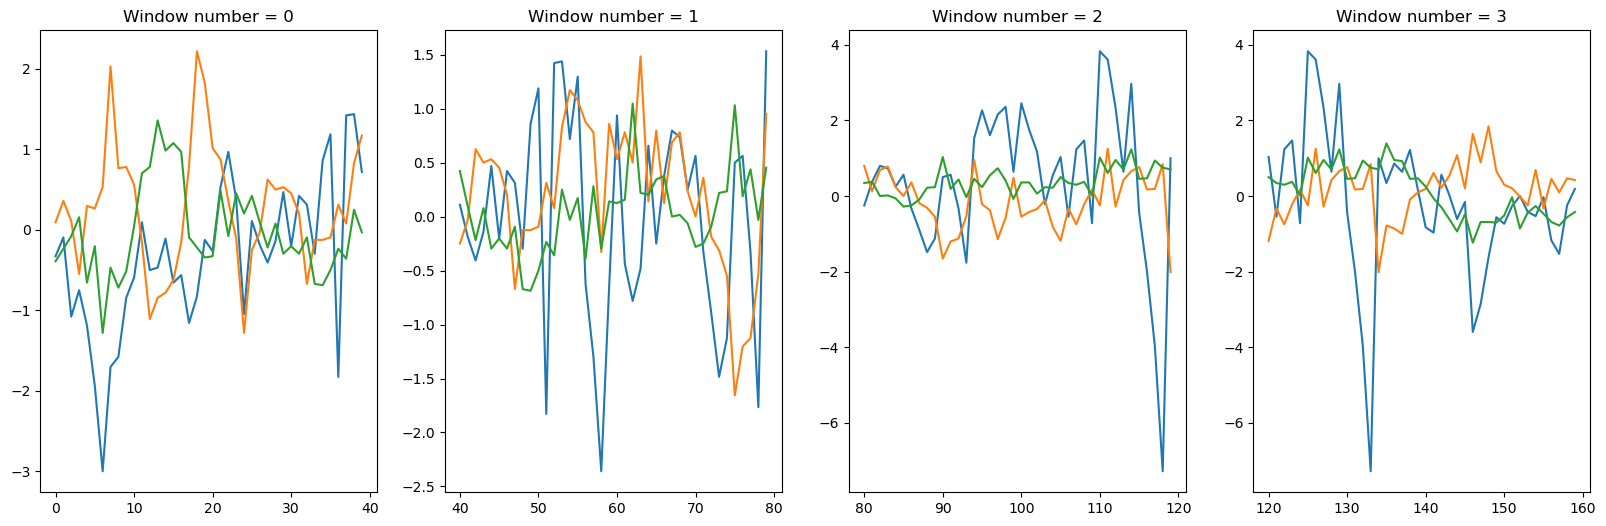

In [18]:
fig, ax = plt.subplots(1, 4, figsize=(20, 6))

for i in range(4):
    ax[i].plot(first_four_windows[i]['gyro_x'])
    ax[i].plot(first_four_windows[i]['gyro_y'])
    ax[i].plot(first_four_windows[i]['gyro_z'])
    ax[i].set_title(f"Window number = {first_four_windows[i].window_id.values[0]}")


It's also interesting to observe the dimensionality of one window. Considering just the accelerometer and gyroscope signals, with all three axes, the resulting dimensionality of one window is:

In [19]:
columns_of_interest = ['accel_x', 'accel_y', 'accel_z', 'gyro_x', 'gyro_y', 'gyro_z']

In [20]:
np.array(first_four_windows[0][columns_of_interest]).shape

(40, 6)

## From sliding windows to datapoints

Each sliding window needs to be further processed in order to represent an appropriate input datapoint. The preprocessing methods might differ depending on which type of model you choose to use. 

You can also do further processing on the signal types and axes, for example smooth the signal, apply axis fusion, eliminate noise etc. 

Here we will discuss simple examples without any preprocessing. 

### Feature extraction with tsfresh

One quick and simple method to consider for HAR is a [Random Forest Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html). It can take a multi-dimensional datapoint as input and can output a classification. 

We can transform each window of data into one single, multidimensional datapoint by applying simple computations using the [tsfresh](https://tsfresh.readthedocs.io/en/latest/text/feature_extraction_settings.html) package.

In [15]:
feature_list = []

for col in columns_of_interest:
    new_features = tsfresh.extract_features(timeseries_container=final_sliding_windows, column_id='window_id',
                        column_value=col, default_fc_parameters=tsfresh.feature_extraction.MinimalFCParameters())
    
    feature_list.append(new_features)
    
feature_list = pd.concat(feature_list, axis=1)

feature_list

Feature Extraction: 100%|██████████| 11/11 [00:00<00:00, 15757.29it/s]


accel_x__sum_values  accel_x__median  accel_x__mean  accel_x__length  \
0            -49.881836        -1.004883      -0.997637             50.0   
1            -49.521484        -0.990723      -0.990430             50.0   
2            -51.131836        -1.004395      -1.022637             50.0   
3            -50.827149        -1.008789      -1.016543             50.0   
4            -49.487305        -0.983887      -0.989746             50.0   
5            -50.258789        -0.986816      -1.005176             50.0   
6            -49.856445        -1.023926      -0.997129             50.0   
7            -49.961914        -1.027832      -0.999238             50.0   
8            -50.881836        -1.027832      -1.017637             50.0   
9            -49.914063        -0.983398      -0.998281             50.0   
10           -49.791016        -1.006836      -0.995820             50.0   

    accel_x__standard_deviation  accel_x__variance  accel_x__maximum  \
0                      0.215343           0.046373         -0.451172   
1                      0.270783           0.073323         -0.451172   
2                      0.272869           0.074457         -0.281250   
3                      0.331682           0.110013         -0.170898   
4                      0.287102           0.082428         -0.170898   
5                      0.297853           0.088716         -0.347656   
6                      0.338230           0.114399         -0.344727   
7                      0.303829           0.092312         -0.303711   
8                      0.301254           0.090754         -0.303711   
9                      0.257541           0.066327         -0.339844   
10                     0.153861           0.023673         -0.621094   

    accel_x__minimum  accel_y__sum_values  accel_y__median  ...  \
0          -1.698242             0.312500        -0.013184  ...   
1          -1.698242            -1.100586        -0.099609  ...   
2          -1.681641            -2.019531        -0.080566  ...   
3          -1.833008            -4.088867        -0.104492  ...   
4          -1.833008            -5.357422        -0.133789  ...   
5          -2.000000            -3.583984        -0.113770  ...   
6          -2.000000            -3.480469        -0.111816  ...   
7          -1.702148            -4.019531        -0.128418  ...   
8          -1.702148            -3.905273        -0.097168  ...   
9          -1.621094            -3.904297        -0.105957  ...   
10         -1.621094            -3.158203        -0.063477  ...   

    gyro_y__maximum  gyro_y__minimum  gyro_z__sum_values  gyro_z__median  \
0          73.03125       -138.53125          -266.78125       -2.406250   
1          99.93750       -138.53125          -224.75000       -4.859375   
2          99.93750       -129.84375          -231.65625       -1.609375   
3         104.96875       -129.84375          -304.37500       -2.937500   
4         104.96875       -114.15625          -843.46875      -15.500000   
5          78.65625       -114.15625         -1223.75000      -34.406250   
6          88.84375       -116.18750          -709.75000      -16.328125   
7          96.21875       -127.09375          -156.56250       -2.062500   
8          96.21875       -127.09375           201.09375       11.546875   
9          85.31250       -116.40625            55.50000        2.843750   
10         70.28125       -116.40625            68.43750        2.312500   

    gyro_z__mean  gyro_z__length  gyro_z__standard_deviation  \
0      -5.335625            50.0                   14.349552   
1      -4.495000            50.0                   24.536754   
2      -4.633125            50.0                   26.407703   
3      -6.087500            50.0                   22.243800   
4     -16.869375            50.0                   27.497826   
5     -24.475000            50.0                   30.689187   
6     -14.195000            50.0                   27.879937

Now the index represents the window ID, and each row in the DataFrame represents a multi-dimensional datapoint which we can use as input to the RFC.

You can use the window ID to refer back to the initial dataframe and get the class (activity type) for each window.

We will now process both recordings so that we have two classes for our classifier. For your own work you should only aim to perform classification on data from one sensor. 

In [16]:
window_size = 50 # 50 datapoints for the window size, which, at 25Hz, means 2 seconds
step_size = 25 # this is 50% overlap

window_number = 0 # start a counter at 0 to keep track of the window number

all_overlapping_windows = []

for rid, group in base_df.groupby("recording_id"):
    print(f"Processing rid = {rid}")
    
    large_enough_windows = [window for window in group.rolling(window=window_size, min_periods=window_size) if len(window) == window_size]
    
    overlapping_windows = large_enough_windows[::step_size] 
    
    # then we will append a window ID to each window
    for window in overlapping_windows:
        window.loc[:, 'window_id'] = window_number
        window_number += 1
    
    
    all_overlapping_windows.append(pd.concat(overlapping_windows).reset_index(drop=True))

/Users/teo/miniconda3/envs/specknet/lib/python3.7/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/teo/miniconda3/envs/specknet/lib/python3.7/site-packages/pandas/core/indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


Processing rid = Respeck_s1234567_Desk work_17-09-2021_13-32-38
Processing rid = Thingy_s1234567_Walking at normal speed_17-09-2021_13-32-12


In [17]:
final_sliding_windows = pd.concat(all_overlapping_windows).reset_index(drop=True)

In [18]:
# now extract all features
feature_list = []

for col in columns_of_interest:
    new_features = tsfresh.extract_features(timeseries_container=final_sliding_windows, column_id='window_id',
                        column_value=col, default_fc_parameters=tsfresh.feature_extraction.MinimalFCParameters())
    
    feature_list.append(new_features)
    
feature_list = pd.concat(feature_list, axis=1)

feature_list

Feature Extraction: 100%|██████████| 21/21 [00:00<00:00, 1969.20it/s]


accel_x__sum_values  accel_x__median  accel_x__mean  accel_x__length  \
0              2.173340         0.041138       0.043467             50.0   
1              2.019043         0.036743       0.040381             50.0   
2              1.920410         0.039795       0.038408             50.0   
3              2.029541         0.041138       0.040591             50.0   
4              2.064941         0.042847       0.041299             50.0   
5              1.926270         0.040527       0.038525             50.0   
6              1.805664         0.035767       0.036113             50.0   
7              1.722412         0.032959       0.034448             50.0   
8              1.535156         0.030518       0.030703             50.0   
9              1.322021         0.024780       0.026440             50.0   
10           -49.881836        -1.004883      -0.997637             50.0   
11           -49.521484        -0.990723      -0.990430             50.0   
12           -51.131836        -1.004395      -1.022637             50.0   
13           -50.827149        -1.008789      -1.016543             50.0   
14           -49.487305        -0.983887      -0.989746             50.0   
15           -50.258789        -0.986816      -1.005176             50.0   
16           -49.856445        -1.023926      -0.997129             50.0   
17           -49.961914        -1.027832      -0.999238             50.0   
18           -50.881836        -1.027832      -1.017637             50.0   
19           -49.914063        -0.983398      -0.998281             50.0   
20           -49.791016        -1.006836      -0.995820             50.0   

    accel_x__standard_deviation  accel_x__variance  accel_x__maximum  \
0                      0.033671           0.001134          0.127930   
1                      0.028599           0.000818          0.127930   
2                      0.019110           0.000365          0.072021   
3                      0.018353           0.000337          0.070557   
4                      0.017287           0.000299          0.078857   
5                      0.016026           0.000257          0.078857   
6                      0.013479           0.000182          0.066895   
7                      0.010858           0.000118          0.061768   
8                      0.009362           0.000088          0.049316   
9                      0.009321           0.000087          0.049561   
10                     0.215343           0.046373         -0.451172   
11                     0.270783           0.073323         -0.451172   
12                     0.272869           0.074457         -0.281250   
13                     0.331682           0.110013         -0.170898   
14                     0.287102           0.082428         -0.170898   
15                     0.297853           0.088716         -0.347656   
16                     0.338230           0.114399         -0.344727   
17                     0.303829           0.092312         -0.303711   
18                     0.301254           0.090754         -0.303711   
19                     0.257541           0.066327         -0.339844   
20                     0.153861           0.023673         -0.621094   

    accel_x__minimum  accel_y__sum_values  accel_y__median  ...  \
0          -0.024414           -49.589477        -0.992004  ...   
1          -0.007812           -49.508667        -0.990417  ...   
2           0.000244           -49.548706        -0.990540  ...   
3           0.005127           -49.592407        -0.993347  ...   
4          -0.004883           -49.580444        -0.991516  ...   
5          -0.004883           -49.612183        -0.992981  ...   
6           0.004639           -49.625366        -0.992371  ...   
7           0.004639           -49.590942        -0.991028  ...   
8           0.010498           -49.583374        -0.992004  ...   
9           0.007812           -49.574585        -0.990784  ...   
10       

Now we also extract the classes from each window

In [21]:
final_sliding_windows.groupby("window_id")[['activity_type']].agg(np.min)

activity_type
window_id                         
0                         Standing
1                         Standing
2                         Standing
3                         Standing
4                         Standing
...                            ...
32075      Walking at normal speed
32076      Walking at normal speed
32077      Walking at normal speed
32078      Walking at normal speed
32079      Walking at normal speed

[32080 rows x 1 columns]

We need to assign a number to each categorical class for the Random Forest Classifer. It is mainly up to you how you categorise your classes. In this example, we will use the labels:
- 0 for Desk work
- 1 for Walking at normal speed

Bear in mind that your classification task will be multi-class, not binary. 

In [22]:
class_labels = {
     'Climbing stairs': 0,
     'Descending stairs': 1,
     'Desk work': 2,
     'Lying down left': 3,
     'Lying down on back': 4,
     'Lying down on stomach': 5,
     'Lying down right': 6,
     'Movement': 7,
     'Running': 8,
     'Sitting': 9,
     'Sitting bent backward': 10,
     'Sitting bent forward': 11,
     'Standing': 12,
     'Walking at normal speed': 13
}

In [23]:
window_id_class_labels = final_sliding_windows.groupby("window_id")[['activity_type']].agg(np.min).replace(class_labels)
window_id_class_labels

activity_type
window_id               
0                     12
1                     12
2                     12
3                     12
4                     12
...                  ...
32075                 13
32076                 13
32077                 13
32078                 13
32079                 13

[32080 rows x 1 columns]

### Quickly training a Random Forest Classifier

We now have all the tools to start training a Random Forest Classifier. We will use the feature_list as inputs and window_id_class_labels as outputs. We will do a basic 80/20 split of the data for demonstration purposes. 

In your project you should split the data into training and tests sets by excluding entire subjects from the training set. This is discussed later on in this notebook.

In [24]:
X_train, X_test, y_train, y_test = train_test_split(feature_list, window_id_class_labels,
                                                    test_size=0.2, train_size=0.8)

NameError: name 'feature_list' is not defined

In [23]:
print(f"Training set: X_train = {X_train.shape}, y_train = {y_train.shape}")
print(f"Test set: X_test = {X_test.shape}, y_test = {y_test.shape}")

Training set: X_train = (16, 48), y_train = (16, 1)
Test set: X_test = (5, 48), y_test = (5, 1)


Now we can build and train the random forest classifier

In [24]:
rfc = RandomForestClassifier(n_estimators=10)

rfc.fit(X_train, y_train)

y_pred = rfc.predict(X_test)

/Users/teo/miniconda3/envs/specknet/lib/python3.7/site-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


In [25]:
print(classification_report(y_pred=y_pred, y_true=y_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         2

    accuracy                           1.00         5
   macro avg       1.00      1.00      1.00         5
weighted avg       1.00      1.00      1.00         5



This is a very easy problem so the classifier learns very quickly. Your actual problem of classifying multiple activities will be much harder.

## Leave-one-subject-out cross-validation

One of the other reason our previous classifier functions so well is that each person performs activities in a very consistent manner. If a subject's data is both in the training set and the test set, it provides the model with an unfair advantage. Moreover, the results that your model will output will be falsely high. When you test your model on a completely new, unseen subject, your accuracy will drop considerably. 

This is why when training a HAR model you will want to do a special kind of cross-validation: Leave-One-Subject-Out (LOSOXV), where we leave one (or more) subject(s) in the testing set at each iteration.

![losoxv](../Images/LOOCV.png "losoxv")

This ensures that the results we get from our classifier are consistent to what we would get in real life, if we were to test the model on a new user.

## Training a simple CNN

There are some different preprocessing techniques you can apply when the resulting "datapoint" is an input to a convolutional neural network. 

You can use two types of convolutional layers:
* 1D Conv Layers - which will work on 1D data, for example a single axis from one single sensor (accel, gyro or mag)
* 2D Conv Layers - suitable if the input data is in the form of an image, for example

We will be demonstrating how to build a simple 1D CNN using 6 channels: the 3 axes of the accelerometer and the 3 axes of the gyroscope.

### Setting up the model

In [36]:
filters = 64
kernel_size = 3
n_features = 6
activation='relu'
n_classes = 14
window_size=40

In [37]:
model = Sequential()

model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='linear', 
                 input_shape=(window_size, n_features)))
model.add(BatchNormalization())
model.add(Activation(activation))

model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='linear'))
model.add(BatchNormalization())
model.add(Activation(activation))

model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='linear'))
model.add(BatchNormalization())
model.add(Activation(activation))

model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(n_classes, activation='softmax'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, 38, 64)            1216      
                                                                 
 batch_normalization_3 (Batc  (None, 38, 64)           256       
 hNormalization)                                                 
                                                                 
 activation_3 (Activation)   (None, 38, 64)            0         
                                                                 
 conv1d_4 (Conv1D)           (None, 36, 64)            12352     
                                                                 
 batch_normalization_4 (Batc  (None, 36, 64)           256       
 hNormalization)                                                 
                                                                 
 activation_4 (Activation)   (None, 36, 64)           

### Re-generating the data in the appropriate format

We need to do a bit more work with our data to bring it into a format fit for training a CNN. 

A CNN will take multi-dimensional arrays as input. We have already specified that the input shape is (window_size, n_features), i.e. (50, 6). 

Remember that we generated sliding windows before. Now we just need to take the raw values from each window and create a training set. 

In [38]:
columns_of_interest

['accel_x', 'accel_y', 'accel_z', 'gyro_x', 'gyro_y', 'gyro_z']

In [39]:
X = []
y = []

for window_id, group in final_sliding_windows.groupby('window_id'):
    print(f"window_id = {window_id}")
    
    shape = group[columns_of_interest].values.shape
    print(f"shape = {shape}")
    
    X.append(group[columns_of_interest].values)
    y.append(class_labels[group["activity_type"].values[0]])

window_id = 0
shape = (40, 6)
window_id = 1
shape = (40, 6)
window_id = 2
shape = (40, 6)
window_id = 3
shape = (40, 6)
window_id = 4
shape = (40, 6)
window_id = 5
shape = (40, 6)
window_id = 6
shape = (40, 6)
window_id = 7
shape = (40, 6)
window_id = 8
shape = (40, 6)
window_id = 9
shape = (40, 6)
window_id = 10
shape = (40, 6)
window_id = 11
shape = (40, 6)
window_id = 12
shape = (40, 6)
window_id = 13
shape = (40, 6)
window_id = 14
shape = (40, 6)
window_id = 15
shape = (40, 6)
window_id = 16
shape = (40, 6)
window_id = 17
shape = (40, 6)
window_id = 18
shape = (40, 6)
window_id = 19
shape = (40, 6)
window_id = 20
shape = (40, 6)
window_id = 21
shape = (40, 6)
window_id = 22
shape = (40, 6)
window_id = 23
shape = (40, 6)
window_id = 24
shape = (40, 6)
window_id = 25
shape = (40, 6)
window_id = 26
shape = (40, 6)
window_id = 27
shape = (40, 6)
window_id = 28
shape = (40, 6)
window_id = 29
shape = (40, 6)
window_id = 30
shape = (40, 6)
window_id = 31
shape = (40, 6)
window_id = 32
sha

shape = (40, 6)
window_id = 389
shape = (40, 6)
window_id = 390
shape = (40, 6)
window_id = 391
shape = (40, 6)
window_id = 392
shape = (40, 6)
window_id = 393
shape = (40, 6)
window_id = 394
shape = (40, 6)
window_id = 395
shape = (40, 6)
window_id = 396
shape = (40, 6)
window_id = 397
shape = (40, 6)
window_id = 398
shape = (40, 6)
window_id = 399
shape = (40, 6)
window_id = 400
shape = (40, 6)
window_id = 401
shape = (40, 6)
window_id = 402
shape = (40, 6)
window_id = 403
shape = (40, 6)
window_id = 404
shape = (40, 6)
window_id = 405
shape = (40, 6)
window_id = 406
shape = (40, 6)
window_id = 407
shape = (40, 6)
window_id = 408
shape = (40, 6)
window_id = 409
shape = (40, 6)
window_id = 410
shape = (40, 6)
window_id = 411
shape = (40, 6)
window_id = 412
shape = (40, 6)
window_id = 413
shape = (40, 6)
window_id = 414
shape = (40, 6)
window_id = 415
shape = (40, 6)
window_id = 416
shape = (40, 6)
window_id = 417
shape = (40, 6)
window_id = 418
shape = (40, 6)
window_id = 419
shape = 

shape = (40, 6)
window_id = 761
shape = (40, 6)
window_id = 762
shape = (40, 6)
window_id = 763
shape = (40, 6)
window_id = 764
shape = (40, 6)
window_id = 765
shape = (40, 6)
window_id = 766
shape = (40, 6)
window_id = 767
shape = (40, 6)
window_id = 768
shape = (40, 6)
window_id = 769
shape = (40, 6)
window_id = 770
shape = (40, 6)
window_id = 771
shape = (40, 6)
window_id = 772
shape = (40, 6)
window_id = 773
shape = (40, 6)
window_id = 774
shape = (40, 6)
window_id = 775
shape = (40, 6)
window_id = 776
shape = (40, 6)
window_id = 777
shape = (40, 6)
window_id = 778
shape = (40, 6)
window_id = 779
shape = (40, 6)
window_id = 780
shape = (40, 6)
window_id = 781
shape = (40, 6)
window_id = 782
shape = (40, 6)
window_id = 783
shape = (40, 6)
window_id = 784
shape = (40, 6)
window_id = 785
shape = (40, 6)
window_id = 786
shape = (40, 6)
window_id = 787
shape = (40, 6)
window_id = 788
shape = (40, 6)
window_id = 789
shape = (40, 6)
window_id = 790
shape = (40, 6)
window_id = 791
shape = 

shape = (40, 6)
window_id = 1183
shape = (40, 6)
window_id = 1184
shape = (40, 6)
window_id = 1185
shape = (40, 6)
window_id = 1186
shape = (40, 6)
window_id = 1187
shape = (40, 6)
window_id = 1188
shape = (40, 6)
window_id = 1189
shape = (40, 6)
window_id = 1190
shape = (40, 6)
window_id = 1191
shape = (40, 6)
window_id = 1192
shape = (40, 6)
window_id = 1193
shape = (40, 6)
window_id = 1194
shape = (40, 6)
window_id = 1195
shape = (40, 6)
window_id = 1196
shape = (40, 6)
window_id = 1197
shape = (40, 6)
window_id = 1198
shape = (40, 6)
window_id = 1199
shape = (40, 6)
window_id = 1200
shape = (40, 6)
window_id = 1201
shape = (40, 6)
window_id = 1202
shape = (40, 6)
window_id = 1203
shape = (40, 6)
window_id = 1204
shape = (40, 6)
window_id = 1205
shape = (40, 6)
window_id = 1206
shape = (40, 6)
window_id = 1207
shape = (40, 6)
window_id = 1208
shape = (40, 6)
window_id = 1209
shape = (40, 6)
window_id = 1210
shape = (40, 6)
window_id = 1211
shape = (40, 6)
window_id = 1212
shape = (4

shape = (40, 6)
window_id = 1559
shape = (40, 6)
window_id = 1560
shape = (40, 6)
window_id = 1561
shape = (40, 6)
window_id = 1562
shape = (40, 6)
window_id = 1563
shape = (40, 6)
window_id = 1564
shape = (40, 6)
window_id = 1565
shape = (40, 6)
window_id = 1566
shape = (40, 6)
window_id = 1567
shape = (40, 6)
window_id = 1568
shape = (40, 6)
window_id = 1569
shape = (40, 6)
window_id = 1570
shape = (40, 6)
window_id = 1571
shape = (40, 6)
window_id = 1572
shape = (40, 6)
window_id = 1573
shape = (40, 6)
window_id = 1574
shape = (40, 6)
window_id = 1575
shape = (40, 6)
window_id = 1576
shape = (40, 6)
window_id = 1577
shape = (40, 6)
window_id = 1578
shape = (40, 6)
window_id = 1579
shape = (40, 6)
window_id = 1580
shape = (40, 6)
window_id = 1581
shape = (40, 6)
window_id = 1582
shape = (40, 6)
window_id = 1583
shape = (40, 6)
window_id = 1584
shape = (40, 6)
window_id = 1585
shape = (40, 6)
window_id = 1586
shape = (40, 6)
window_id = 1587
shape = (40, 6)
window_id = 1588
shape = (4

shape = (40, 6)
window_id = 1983
shape = (40, 6)
window_id = 1984
shape = (40, 6)
window_id = 1985
shape = (40, 6)
window_id = 1986
shape = (40, 6)
window_id = 1987
shape = (40, 6)
window_id = 1988
shape = (40, 6)
window_id = 1989
shape = (40, 6)
window_id = 1990
shape = (40, 6)
window_id = 1991
shape = (40, 6)
window_id = 1992
shape = (40, 6)
window_id = 1993
shape = (40, 6)
window_id = 1994
shape = (40, 6)
window_id = 1995
shape = (40, 6)
window_id = 1996
shape = (40, 6)
window_id = 1997
shape = (40, 6)
window_id = 1998
shape = (40, 6)
window_id = 1999
shape = (40, 6)
window_id = 2000
shape = (40, 6)
window_id = 2001
shape = (40, 6)
window_id = 2002
shape = (40, 6)
window_id = 2003
shape = (40, 6)
window_id = 2004
shape = (40, 6)
window_id = 2005
shape = (40, 6)
window_id = 2006
shape = (40, 6)
window_id = 2007
shape = (40, 6)
window_id = 2008
shape = (40, 6)
window_id = 2009
shape = (40, 6)
window_id = 2010
shape = (40, 6)
window_id = 2011
shape = (40, 6)
window_id = 2012
shape = (4

shape = (40, 6)
window_id = 2378
shape = (40, 6)
window_id = 2379
shape = (40, 6)
window_id = 2380
shape = (40, 6)
window_id = 2381
shape = (40, 6)
window_id = 2382
shape = (40, 6)
window_id = 2383
shape = (40, 6)
window_id = 2384
shape = (40, 6)
window_id = 2385
shape = (40, 6)
window_id = 2386
shape = (40, 6)
window_id = 2387
shape = (40, 6)
window_id = 2388
shape = (40, 6)
window_id = 2389
shape = (40, 6)
window_id = 2390
shape = (40, 6)
window_id = 2391
shape = (40, 6)
window_id = 2392
shape = (40, 6)
window_id = 2393
shape = (40, 6)
window_id = 2394
shape = (40, 6)
window_id = 2395
shape = (40, 6)
window_id = 2396
shape = (40, 6)
window_id = 2397
shape = (40, 6)
window_id = 2398
shape = (40, 6)
window_id = 2399
shape = (40, 6)
window_id = 2400
shape = (40, 6)
window_id = 2401
shape = (40, 6)
window_id = 2402
shape = (40, 6)
window_id = 2403
shape = (40, 6)
window_id = 2404
shape = (40, 6)
window_id = 2405
shape = (40, 6)
window_id = 2406
shape = (40, 6)
window_id = 2407
shape = (4

shape = (40, 6)
window_id = 2771
shape = (40, 6)
window_id = 2772
shape = (40, 6)
window_id = 2773
shape = (40, 6)
window_id = 2774
shape = (40, 6)
window_id = 2775
shape = (40, 6)
window_id = 2776
shape = (40, 6)
window_id = 2777
shape = (40, 6)
window_id = 2778
shape = (40, 6)
window_id = 2779
shape = (40, 6)
window_id = 2780
shape = (40, 6)
window_id = 2781
shape = (40, 6)
window_id = 2782
shape = (40, 6)
window_id = 2783
shape = (40, 6)
window_id = 2784
shape = (40, 6)
window_id = 2785
shape = (40, 6)
window_id = 2786
shape = (40, 6)
window_id = 2787
shape = (40, 6)
window_id = 2788
shape = (40, 6)
window_id = 2789
shape = (40, 6)
window_id = 2790
shape = (40, 6)
window_id = 2791
shape = (40, 6)
window_id = 2792
shape = (40, 6)
window_id = 2793
shape = (40, 6)
window_id = 2794
shape = (40, 6)
window_id = 2795
shape = (40, 6)
window_id = 2796
shape = (40, 6)
window_id = 2797
shape = (40, 6)
window_id = 2798
shape = (40, 6)
window_id = 2799
shape = (40, 6)
window_id = 2800
shape = (4

shape = (40, 6)
window_id = 3159
shape = (40, 6)
window_id = 3160
shape = (40, 6)
window_id = 3161
shape = (40, 6)
window_id = 3162
shape = (40, 6)
window_id = 3163
shape = (40, 6)
window_id = 3164
shape = (40, 6)
window_id = 3165
shape = (40, 6)
window_id = 3166
shape = (40, 6)
window_id = 3167
shape = (40, 6)
window_id = 3168
shape = (40, 6)
window_id = 3169
shape = (40, 6)
window_id = 3170
shape = (40, 6)
window_id = 3171
shape = (40, 6)
window_id = 3172
shape = (40, 6)
window_id = 3173
shape = (40, 6)
window_id = 3174
shape = (40, 6)
window_id = 3175
shape = (40, 6)
window_id = 3176
shape = (40, 6)
window_id = 3177
shape = (40, 6)
window_id = 3178
shape = (40, 6)
window_id = 3179
shape = (40, 6)
window_id = 3180
shape = (40, 6)
window_id = 3181
shape = (40, 6)
window_id = 3182
shape = (40, 6)
window_id = 3183
shape = (40, 6)
window_id = 3184
shape = (40, 6)
window_id = 3185
shape = (40, 6)
window_id = 3186
shape = (40, 6)
window_id = 3187
shape = (40, 6)
window_id = 3188
shape = (4

shape = (40, 6)
window_id = 3554
shape = (40, 6)
window_id = 3555
shape = (40, 6)
window_id = 3556
shape = (40, 6)
window_id = 3557
shape = (40, 6)
window_id = 3558
shape = (40, 6)
window_id = 3559
shape = (40, 6)
window_id = 3560
shape = (40, 6)
window_id = 3561
shape = (40, 6)
window_id = 3562
shape = (40, 6)
window_id = 3563
shape = (40, 6)
window_id = 3564
shape = (40, 6)
window_id = 3565
shape = (40, 6)
window_id = 3566
shape = (40, 6)
window_id = 3567
shape = (40, 6)
window_id = 3568
shape = (40, 6)
window_id = 3569
shape = (40, 6)
window_id = 3570
shape = (40, 6)
window_id = 3571
shape = (40, 6)
window_id = 3572
shape = (40, 6)
window_id = 3573
shape = (40, 6)
window_id = 3574
shape = (40, 6)
window_id = 3575
shape = (40, 6)
window_id = 3576
shape = (40, 6)
window_id = 3577
shape = (40, 6)
window_id = 3578
shape = (40, 6)
window_id = 3579
shape = (40, 6)
window_id = 3580
shape = (40, 6)
window_id = 3581
shape = (40, 6)
window_id = 3582
shape = (40, 6)
window_id = 3583
shape = (4

shape = (40, 6)
window_id = 3927
shape = (40, 6)
window_id = 3928
shape = (40, 6)
window_id = 3929
shape = (40, 6)
window_id = 3930
shape = (40, 6)
window_id = 3931
shape = (40, 6)
window_id = 3932
shape = (40, 6)
window_id = 3933
shape = (40, 6)
window_id = 3934
shape = (40, 6)
window_id = 3935
shape = (40, 6)
window_id = 3936
shape = (40, 6)
window_id = 3937
shape = (40, 6)
window_id = 3938
shape = (40, 6)
window_id = 3939
shape = (40, 6)
window_id = 3940
shape = (40, 6)
window_id = 3941
shape = (40, 6)
window_id = 3942
shape = (40, 6)
window_id = 3943
shape = (40, 6)
window_id = 3944
shape = (40, 6)
window_id = 3945
shape = (40, 6)
window_id = 3946
shape = (40, 6)
window_id = 3947
shape = (40, 6)
window_id = 3948
shape = (40, 6)
window_id = 3949
shape = (40, 6)
window_id = 3950
shape = (40, 6)
window_id = 3951
shape = (40, 6)
window_id = 3952
shape = (40, 6)
window_id = 3953
shape = (40, 6)
window_id = 3954
shape = (40, 6)
window_id = 3955
shape = (40, 6)
window_id = 3956
shape = (4

shape = (40, 6)
window_id = 4321
shape = (40, 6)
window_id = 4322
shape = (40, 6)
window_id = 4323
shape = (40, 6)
window_id = 4324
shape = (40, 6)
window_id = 4325
shape = (40, 6)
window_id = 4326
shape = (40, 6)
window_id = 4327
shape = (40, 6)
window_id = 4328
shape = (40, 6)
window_id = 4329
shape = (40, 6)
window_id = 4330
shape = (40, 6)
window_id = 4331
shape = (40, 6)
window_id = 4332
shape = (40, 6)
window_id = 4333
shape = (40, 6)
window_id = 4334
shape = (40, 6)
window_id = 4335
shape = (40, 6)
window_id = 4336
shape = (40, 6)
window_id = 4337
shape = (40, 6)
window_id = 4338
shape = (40, 6)
window_id = 4339
shape = (40, 6)
window_id = 4340
shape = (40, 6)
window_id = 4341
shape = (40, 6)
window_id = 4342
shape = (40, 6)
window_id = 4343
shape = (40, 6)
window_id = 4344
shape = (40, 6)
window_id = 4345
shape = (40, 6)
window_id = 4346
shape = (40, 6)
window_id = 4347
shape = (40, 6)
window_id = 4348
shape = (40, 6)
window_id = 4349
shape = (40, 6)
window_id = 4350
shape = (4

shape = (40, 6)
window_id = 4731
shape = (40, 6)
window_id = 4732
shape = (40, 6)
window_id = 4733
shape = (40, 6)
window_id = 4734
shape = (40, 6)
window_id = 4735
shape = (40, 6)
window_id = 4736
shape = (40, 6)
window_id = 4737
shape = (40, 6)
window_id = 4738
shape = (40, 6)
window_id = 4739
shape = (40, 6)
window_id = 4740
shape = (40, 6)
window_id = 4741
shape = (40, 6)
window_id = 4742
shape = (40, 6)
window_id = 4743
shape = (40, 6)
window_id = 4744
shape = (40, 6)
window_id = 4745
shape = (40, 6)
window_id = 4746
shape = (40, 6)
window_id = 4747
shape = (40, 6)
window_id = 4748
shape = (40, 6)
window_id = 4749
shape = (40, 6)
window_id = 4750
shape = (40, 6)
window_id = 4751
shape = (40, 6)
window_id = 4752
shape = (40, 6)
window_id = 4753
shape = (40, 6)
window_id = 4754
shape = (40, 6)
window_id = 4755
shape = (40, 6)
window_id = 4756
shape = (40, 6)
window_id = 4757
shape = (40, 6)
window_id = 4758
shape = (40, 6)
window_id = 4759
shape = (40, 6)
window_id = 4760
shape = (4

shape = (40, 6)
window_id = 5135
shape = (40, 6)
window_id = 5136
shape = (40, 6)
window_id = 5137
shape = (40, 6)
window_id = 5138
shape = (40, 6)
window_id = 5139
shape = (40, 6)
window_id = 5140
shape = (40, 6)
window_id = 5141
shape = (40, 6)
window_id = 5142
shape = (40, 6)
window_id = 5143
shape = (40, 6)
window_id = 5144
shape = (40, 6)
window_id = 5145
shape = (40, 6)
window_id = 5146
shape = (40, 6)
window_id = 5147
shape = (40, 6)
window_id = 5148
shape = (40, 6)
window_id = 5149
shape = (40, 6)
window_id = 5150
shape = (40, 6)
window_id = 5151
shape = (40, 6)
window_id = 5152
shape = (40, 6)
window_id = 5153
shape = (40, 6)
window_id = 5154
shape = (40, 6)
window_id = 5155
shape = (40, 6)
window_id = 5156
shape = (40, 6)
window_id = 5157
shape = (40, 6)
window_id = 5158
shape = (40, 6)
window_id = 5159
shape = (40, 6)
window_id = 5160
shape = (40, 6)
window_id = 5161
shape = (40, 6)
window_id = 5162
shape = (40, 6)
window_id = 5163
shape = (40, 6)
window_id = 5164
shape = (4

shape = (40, 6)
window_id = 5505
shape = (40, 6)
window_id = 5506
shape = (40, 6)
window_id = 5507
shape = (40, 6)
window_id = 5508
shape = (40, 6)
window_id = 5509
shape = (40, 6)
window_id = 5510
shape = (40, 6)
window_id = 5511
shape = (40, 6)
window_id = 5512
shape = (40, 6)
window_id = 5513
shape = (40, 6)
window_id = 5514
shape = (40, 6)
window_id = 5515
shape = (40, 6)
window_id = 5516
shape = (40, 6)
window_id = 5517
shape = (40, 6)
window_id = 5518
shape = (40, 6)
window_id = 5519
shape = (40, 6)
window_id = 5520
shape = (40, 6)
window_id = 5521
shape = (40, 6)
window_id = 5522
shape = (40, 6)
window_id = 5523
shape = (40, 6)
window_id = 5524
shape = (40, 6)
window_id = 5525
shape = (40, 6)
window_id = 5526
shape = (40, 6)
window_id = 5527
shape = (40, 6)
window_id = 5528
shape = (40, 6)
window_id = 5529
shape = (40, 6)
window_id = 5530
shape = (40, 6)
window_id = 5531
shape = (40, 6)
window_id = 5532
shape = (40, 6)
window_id = 5533
shape = (40, 6)
window_id = 5534
shape = (4

shape = (40, 6)
window_id = 5888
shape = (40, 6)
window_id = 5889
shape = (40, 6)
window_id = 5890
shape = (40, 6)
window_id = 5891
shape = (40, 6)
window_id = 5892
shape = (40, 6)
window_id = 5893
shape = (40, 6)
window_id = 5894
shape = (40, 6)
window_id = 5895
shape = (40, 6)
window_id = 5896
shape = (40, 6)
window_id = 5897
shape = (40, 6)
window_id = 5898
shape = (40, 6)
window_id = 5899
shape = (40, 6)
window_id = 5900
shape = (40, 6)
window_id = 5901
shape = (40, 6)
window_id = 5902
shape = (40, 6)
window_id = 5903
shape = (40, 6)
window_id = 5904
shape = (40, 6)
window_id = 5905
shape = (40, 6)
window_id = 5906
shape = (40, 6)
window_id = 5907
shape = (40, 6)
window_id = 5908
shape = (40, 6)
window_id = 5909
shape = (40, 6)
window_id = 5910
shape = (40, 6)
window_id = 5911
shape = (40, 6)
window_id = 5912
shape = (40, 6)
window_id = 5913
shape = (40, 6)
window_id = 5914
shape = (40, 6)
window_id = 5915
shape = (40, 6)
window_id = 5916
shape = (40, 6)
window_id = 5917
shape = (4

shape = (40, 6)
window_id = 6338
shape = (40, 6)
window_id = 6339
shape = (40, 6)
window_id = 6340
shape = (40, 6)
window_id = 6341
shape = (40, 6)
window_id = 6342
shape = (40, 6)
window_id = 6343
shape = (40, 6)
window_id = 6344
shape = (40, 6)
window_id = 6345
shape = (40, 6)
window_id = 6346
shape = (40, 6)
window_id = 6347
shape = (40, 6)
window_id = 6348
shape = (40, 6)
window_id = 6349
shape = (40, 6)
window_id = 6350
shape = (40, 6)
window_id = 6351
shape = (40, 6)
window_id = 6352
shape = (40, 6)
window_id = 6353
shape = (40, 6)
window_id = 6354
shape = (40, 6)
window_id = 6355
shape = (40, 6)
window_id = 6356
shape = (40, 6)
window_id = 6357
shape = (40, 6)
window_id = 6358
shape = (40, 6)
window_id = 6359
shape = (40, 6)
window_id = 6360
shape = (40, 6)
window_id = 6361
shape = (40, 6)
window_id = 6362
shape = (40, 6)
window_id = 6363
shape = (40, 6)
window_id = 6364
shape = (40, 6)
window_id = 6365
shape = (40, 6)
window_id = 6366
shape = (40, 6)
window_id = 6367
shape = (4

shape = (40, 6)
window_id = 6767
shape = (40, 6)
window_id = 6768
shape = (40, 6)
window_id = 6769
shape = (40, 6)
window_id = 6770
shape = (40, 6)
window_id = 6771
shape = (40, 6)
window_id = 6772
shape = (40, 6)
window_id = 6773
shape = (40, 6)
window_id = 6774
shape = (40, 6)
window_id = 6775
shape = (40, 6)
window_id = 6776
shape = (40, 6)
window_id = 6777
shape = (40, 6)
window_id = 6778
shape = (40, 6)
window_id = 6779
shape = (40, 6)
window_id = 6780
shape = (40, 6)
window_id = 6781
shape = (40, 6)
window_id = 6782
shape = (40, 6)
window_id = 6783
shape = (40, 6)
window_id = 6784
shape = (40, 6)
window_id = 6785
shape = (40, 6)
window_id = 6786
shape = (40, 6)
window_id = 6787
shape = (40, 6)
window_id = 6788
shape = (40, 6)
window_id = 6789
shape = (40, 6)
window_id = 6790
shape = (40, 6)
window_id = 6791
shape = (40, 6)
window_id = 6792
shape = (40, 6)
window_id = 6793
shape = (40, 6)
window_id = 6794
shape = (40, 6)
window_id = 6795
shape = (40, 6)
window_id = 6796
shape = (4

shape = (40, 6)
window_id = 7170
shape = (40, 6)
window_id = 7171
shape = (40, 6)
window_id = 7172
shape = (40, 6)
window_id = 7173
shape = (40, 6)
window_id = 7174
shape = (40, 6)
window_id = 7175
shape = (40, 6)
window_id = 7176
shape = (40, 6)
window_id = 7177
shape = (40, 6)
window_id = 7178
shape = (40, 6)
window_id = 7179
shape = (40, 6)
window_id = 7180
shape = (40, 6)
window_id = 7181
shape = (40, 6)
window_id = 7182
shape = (40, 6)
window_id = 7183
shape = (40, 6)
window_id = 7184
shape = (40, 6)
window_id = 7185
shape = (40, 6)
window_id = 7186
shape = (40, 6)
window_id = 7187
shape = (40, 6)
window_id = 7188
shape = (40, 6)
window_id = 7189
shape = (40, 6)
window_id = 7190
shape = (40, 6)
window_id = 7191
shape = (40, 6)
window_id = 7192
shape = (40, 6)
window_id = 7193
shape = (40, 6)
window_id = 7194
shape = (40, 6)
window_id = 7195
shape = (40, 6)
window_id = 7196
shape = (40, 6)
window_id = 7197
shape = (40, 6)
window_id = 7198
shape = (40, 6)
window_id = 7199
shape = (4

shape = (40, 6)
window_id = 7550
shape = (40, 6)
window_id = 7551
shape = (40, 6)
window_id = 7552
shape = (40, 6)
window_id = 7553
shape = (40, 6)
window_id = 7554
shape = (40, 6)
window_id = 7555
shape = (40, 6)
window_id = 7556
shape = (40, 6)
window_id = 7557
shape = (40, 6)
window_id = 7558
shape = (40, 6)
window_id = 7559
shape = (40, 6)
window_id = 7560
shape = (40, 6)
window_id = 7561
shape = (40, 6)
window_id = 7562
shape = (40, 6)
window_id = 7563
shape = (40, 6)
window_id = 7564
shape = (40, 6)
window_id = 7565
shape = (40, 6)
window_id = 7566
shape = (40, 6)
window_id = 7567
shape = (40, 6)
window_id = 7568
shape = (40, 6)
window_id = 7569
shape = (40, 6)
window_id = 7570
shape = (40, 6)
window_id = 7571
shape = (40, 6)
window_id = 7572
shape = (40, 6)
window_id = 7573
shape = (40, 6)
window_id = 7574
shape = (40, 6)
window_id = 7575
shape = (40, 6)
window_id = 7576
shape = (40, 6)
window_id = 7577
shape = (40, 6)
window_id = 7578
shape = (40, 6)
window_id = 7579
shape = (4

shape = (40, 6)
window_id = 7954
shape = (40, 6)
window_id = 7955
shape = (40, 6)
window_id = 7956
shape = (40, 6)
window_id = 7957
shape = (40, 6)
window_id = 7958
shape = (40, 6)
window_id = 7959
shape = (40, 6)
window_id = 7960
shape = (40, 6)
window_id = 7961
shape = (40, 6)
window_id = 7962
shape = (40, 6)
window_id = 7963
shape = (40, 6)
window_id = 7964
shape = (40, 6)
window_id = 7965
shape = (40, 6)
window_id = 7966
shape = (40, 6)
window_id = 7967
shape = (40, 6)
window_id = 7968
shape = (40, 6)
window_id = 7969
shape = (40, 6)
window_id = 7970
shape = (40, 6)
window_id = 7971
shape = (40, 6)
window_id = 7972
shape = (40, 6)
window_id = 7973
shape = (40, 6)
window_id = 7974
shape = (40, 6)
window_id = 7975
shape = (40, 6)
window_id = 7976
shape = (40, 6)
window_id = 7977
shape = (40, 6)
window_id = 7978
shape = (40, 6)
window_id = 7979
shape = (40, 6)
window_id = 7980
shape = (40, 6)
window_id = 7981
shape = (40, 6)
window_id = 7982
shape = (40, 6)
window_id = 7983
shape = (4

shape = (40, 6)
window_id = 8387
shape = (40, 6)
window_id = 8388
shape = (40, 6)
window_id = 8389
shape = (40, 6)
window_id = 8390
shape = (40, 6)
window_id = 8391
shape = (40, 6)
window_id = 8392
shape = (40, 6)
window_id = 8393
shape = (40, 6)
window_id = 8394
shape = (40, 6)
window_id = 8395
shape = (40, 6)
window_id = 8396
shape = (40, 6)
window_id = 8397
shape = (40, 6)
window_id = 8398
shape = (40, 6)
window_id = 8399
shape = (40, 6)
window_id = 8400
shape = (40, 6)
window_id = 8401
shape = (40, 6)
window_id = 8402
shape = (40, 6)
window_id = 8403
shape = (40, 6)
window_id = 8404
shape = (40, 6)
window_id = 8405
shape = (40, 6)
window_id = 8406
shape = (40, 6)
window_id = 8407
shape = (40, 6)
window_id = 8408
shape = (40, 6)
window_id = 8409
shape = (40, 6)
window_id = 8410
shape = (40, 6)
window_id = 8411
shape = (40, 6)
window_id = 8412
shape = (40, 6)
window_id = 8413
shape = (40, 6)
window_id = 8414
shape = (40, 6)
window_id = 8415
shape = (40, 6)
window_id = 8416
shape = (4

shape = (40, 6)
window_id = 8790
shape = (40, 6)
window_id = 8791
shape = (40, 6)
window_id = 8792
shape = (40, 6)
window_id = 8793
shape = (40, 6)
window_id = 8794
shape = (40, 6)
window_id = 8795
shape = (40, 6)
window_id = 8796
shape = (40, 6)
window_id = 8797
shape = (40, 6)
window_id = 8798
shape = (40, 6)
window_id = 8799
shape = (40, 6)
window_id = 8800
shape = (40, 6)
window_id = 8801
shape = (40, 6)
window_id = 8802
shape = (40, 6)
window_id = 8803
shape = (40, 6)
window_id = 8804
shape = (40, 6)
window_id = 8805
shape = (40, 6)
window_id = 8806
shape = (40, 6)
window_id = 8807
shape = (40, 6)
window_id = 8808
shape = (40, 6)
window_id = 8809
shape = (40, 6)
window_id = 8810
shape = (40, 6)
window_id = 8811
shape = (40, 6)
window_id = 8812
shape = (40, 6)
window_id = 8813
shape = (40, 6)
window_id = 8814
shape = (40, 6)
window_id = 8815
shape = (40, 6)
window_id = 8816
shape = (40, 6)
window_id = 8817
shape = (40, 6)
window_id = 8818
shape = (40, 6)
window_id = 8819
shape = (4

shape = (40, 6)
window_id = 9205
shape = (40, 6)
window_id = 9206
shape = (40, 6)
window_id = 9207
shape = (40, 6)
window_id = 9208
shape = (40, 6)
window_id = 9209
shape = (40, 6)
window_id = 9210
shape = (40, 6)
window_id = 9211
shape = (40, 6)
window_id = 9212
shape = (40, 6)
window_id = 9213
shape = (40, 6)
window_id = 9214
shape = (40, 6)
window_id = 9215
shape = (40, 6)
window_id = 9216
shape = (40, 6)
window_id = 9217
shape = (40, 6)
window_id = 9218
shape = (40, 6)
window_id = 9219
shape = (40, 6)
window_id = 9220
shape = (40, 6)
window_id = 9221
shape = (40, 6)
window_id = 9222
shape = (40, 6)
window_id = 9223
shape = (40, 6)
window_id = 9224
shape = (40, 6)
window_id = 9225
shape = (40, 6)
window_id = 9226
shape = (40, 6)
window_id = 9227
shape = (40, 6)
window_id = 9228
shape = (40, 6)
window_id = 9229
shape = (40, 6)
window_id = 9230
shape = (40, 6)
window_id = 9231
shape = (40, 6)
window_id = 9232
shape = (40, 6)
window_id = 9233
shape = (40, 6)
window_id = 9234
shape = (4

shape = (40, 6)
window_id = 9653
shape = (40, 6)
window_id = 9654
shape = (40, 6)
window_id = 9655
shape = (40, 6)
window_id = 9656
shape = (40, 6)
window_id = 9657
shape = (40, 6)
window_id = 9658
shape = (40, 6)
window_id = 9659
shape = (40, 6)
window_id = 9660
shape = (40, 6)
window_id = 9661
shape = (40, 6)
window_id = 9662
shape = (40, 6)
window_id = 9663
shape = (40, 6)
window_id = 9664
shape = (40, 6)
window_id = 9665
shape = (40, 6)
window_id = 9666
shape = (40, 6)
window_id = 9667
shape = (40, 6)
window_id = 9668
shape = (40, 6)
window_id = 9669
shape = (40, 6)
window_id = 9670
shape = (40, 6)
window_id = 9671
shape = (40, 6)
window_id = 9672
shape = (40, 6)
window_id = 9673
shape = (40, 6)
window_id = 9674
shape = (40, 6)
window_id = 9675
shape = (40, 6)
window_id = 9676
shape = (40, 6)
window_id = 9677
shape = (40, 6)
window_id = 9678
shape = (40, 6)
window_id = 9679
shape = (40, 6)
window_id = 9680
shape = (40, 6)
window_id = 9681
shape = (40, 6)
window_id = 9682
shape = (4

shape = (40, 6)
window_id = 10109
shape = (40, 6)
window_id = 10110
shape = (40, 6)
window_id = 10111
shape = (40, 6)
window_id = 10112
shape = (40, 6)
window_id = 10113
shape = (40, 6)
window_id = 10114
shape = (40, 6)
window_id = 10115
shape = (40, 6)
window_id = 10116
shape = (40, 6)
window_id = 10117
shape = (40, 6)
window_id = 10118
shape = (40, 6)
window_id = 10119
shape = (40, 6)
window_id = 10120
shape = (40, 6)
window_id = 10121
shape = (40, 6)
window_id = 10122
shape = (40, 6)
window_id = 10123
shape = (40, 6)
window_id = 10124
shape = (40, 6)
window_id = 10125
shape = (40, 6)
window_id = 10126
shape = (40, 6)
window_id = 10127
shape = (40, 6)
window_id = 10128
shape = (40, 6)
window_id = 10129
shape = (40, 6)
window_id = 10130
shape = (40, 6)
window_id = 10131
shape = (40, 6)
window_id = 10132
shape = (40, 6)
window_id = 10133
shape = (40, 6)
window_id = 10134
shape = (40, 6)
window_id = 10135
shape = (40, 6)
window_id = 10136
shape = (40, 6)
window_id = 10137
shape = (40, 6

shape = (40, 6)
window_id = 10563
shape = (40, 6)
window_id = 10564
shape = (40, 6)
window_id = 10565
shape = (40, 6)
window_id = 10566
shape = (40, 6)
window_id = 10567
shape = (40, 6)
window_id = 10568
shape = (40, 6)
window_id = 10569
shape = (40, 6)
window_id = 10570
shape = (40, 6)
window_id = 10571
shape = (40, 6)
window_id = 10572
shape = (40, 6)
window_id = 10573
shape = (40, 6)
window_id = 10574
shape = (40, 6)
window_id = 10575
shape = (40, 6)
window_id = 10576
shape = (40, 6)
window_id = 10577
shape = (40, 6)
window_id = 10578
shape = (40, 6)
window_id = 10579
shape = (40, 6)
window_id = 10580
shape = (40, 6)
window_id = 10581
shape = (40, 6)
window_id = 10582
shape = (40, 6)
window_id = 10583
shape = (40, 6)
window_id = 10584
shape = (40, 6)
window_id = 10585
shape = (40, 6)
window_id = 10586
shape = (40, 6)
window_id = 10587
shape = (40, 6)
window_id = 10588
shape = (40, 6)
window_id = 10589
shape = (40, 6)
window_id = 10590
shape = (40, 6)
window_id = 10591
shape = (40, 6

shape = (40, 6)
window_id = 10960
shape = (40, 6)
window_id = 10961
shape = (40, 6)
window_id = 10962
shape = (40, 6)
window_id = 10963
shape = (40, 6)
window_id = 10964
shape = (40, 6)
window_id = 10965
shape = (40, 6)
window_id = 10966
shape = (40, 6)
window_id = 10967
shape = (40, 6)
window_id = 10968
shape = (40, 6)
window_id = 10969
shape = (40, 6)
window_id = 10970
shape = (40, 6)
window_id = 10971
shape = (40, 6)
window_id = 10972
shape = (40, 6)
window_id = 10973
shape = (40, 6)
window_id = 10974
shape = (40, 6)
window_id = 10975
shape = (40, 6)
window_id = 10976
shape = (40, 6)
window_id = 10977
shape = (40, 6)
window_id = 10978
shape = (40, 6)
window_id = 10979
shape = (40, 6)
window_id = 10980
shape = (40, 6)
window_id = 10981
shape = (40, 6)
window_id = 10982
shape = (40, 6)
window_id = 10983
shape = (40, 6)
window_id = 10984
shape = (40, 6)
window_id = 10985
shape = (40, 6)
window_id = 10986
shape = (40, 6)
window_id = 10987
shape = (40, 6)
window_id = 10988
shape = (40, 6

shape = (40, 6)
window_id = 11356
shape = (40, 6)
window_id = 11357
shape = (40, 6)
window_id = 11358
shape = (40, 6)
window_id = 11359
shape = (40, 6)
window_id = 11360
shape = (40, 6)
window_id = 11361
shape = (40, 6)
window_id = 11362
shape = (40, 6)
window_id = 11363
shape = (40, 6)
window_id = 11364
shape = (40, 6)
window_id = 11365
shape = (40, 6)
window_id = 11366
shape = (40, 6)
window_id = 11367
shape = (40, 6)
window_id = 11368
shape = (40, 6)
window_id = 11369
shape = (40, 6)
window_id = 11370
shape = (40, 6)
window_id = 11371
shape = (40, 6)
window_id = 11372
shape = (40, 6)
window_id = 11373
shape = (40, 6)
window_id = 11374
shape = (40, 6)
window_id = 11375
shape = (40, 6)
window_id = 11376
shape = (40, 6)
window_id = 11377
shape = (40, 6)
window_id = 11378
shape = (40, 6)
window_id = 11379
shape = (40, 6)
window_id = 11380
shape = (40, 6)
window_id = 11381
shape = (40, 6)
window_id = 11382
shape = (40, 6)
window_id = 11383
shape = (40, 6)
window_id = 11384
shape = (40, 6

shape = (40, 6)
window_id = 11724
shape = (40, 6)
window_id = 11725
shape = (40, 6)
window_id = 11726
shape = (40, 6)
window_id = 11727
shape = (40, 6)
window_id = 11728
shape = (40, 6)
window_id = 11729
shape = (40, 6)
window_id = 11730
shape = (40, 6)
window_id = 11731
shape = (40, 6)
window_id = 11732
shape = (40, 6)
window_id = 11733
shape = (40, 6)
window_id = 11734
shape = (40, 6)
window_id = 11735
shape = (40, 6)
window_id = 11736
shape = (40, 6)
window_id = 11737
shape = (40, 6)
window_id = 11738
shape = (40, 6)
window_id = 11739
shape = (40, 6)
window_id = 11740
shape = (40, 6)
window_id = 11741
shape = (40, 6)
window_id = 11742
shape = (40, 6)
window_id = 11743
shape = (40, 6)
window_id = 11744
shape = (40, 6)
window_id = 11745
shape = (40, 6)
window_id = 11746
shape = (40, 6)
window_id = 11747
shape = (40, 6)
window_id = 11748
shape = (40, 6)
window_id = 11749
shape = (40, 6)
window_id = 11750
shape = (40, 6)
window_id = 11751
shape = (40, 6)
window_id = 11752
shape = (40, 6

shape = (40, 6)
window_id = 12121
shape = (40, 6)
window_id = 12122
shape = (40, 6)
window_id = 12123
shape = (40, 6)
window_id = 12124
shape = (40, 6)
window_id = 12125
shape = (40, 6)
window_id = 12126
shape = (40, 6)
window_id = 12127
shape = (40, 6)
window_id = 12128
shape = (40, 6)
window_id = 12129
shape = (40, 6)
window_id = 12130
shape = (40, 6)
window_id = 12131
shape = (40, 6)
window_id = 12132
shape = (40, 6)
window_id = 12133
shape = (40, 6)
window_id = 12134
shape = (40, 6)
window_id = 12135
shape = (40, 6)
window_id = 12136
shape = (40, 6)
window_id = 12137
shape = (40, 6)
window_id = 12138
shape = (40, 6)
window_id = 12139
shape = (40, 6)
window_id = 12140
shape = (40, 6)
window_id = 12141
shape = (40, 6)
window_id = 12142
shape = (40, 6)
window_id = 12143
shape = (40, 6)
window_id = 12144
shape = (40, 6)
window_id = 12145
shape = (40, 6)
window_id = 12146
shape = (40, 6)
window_id = 12147
shape = (40, 6)
window_id = 12148
shape = (40, 6)
window_id = 12149
shape = (40, 6

shape = (40, 6)
window_id = 12579
shape = (40, 6)
window_id = 12580
shape = (40, 6)
window_id = 12581
shape = (40, 6)
window_id = 12582
shape = (40, 6)
window_id = 12583
shape = (40, 6)
window_id = 12584
shape = (40, 6)
window_id = 12585
shape = (40, 6)
window_id = 12586
shape = (40, 6)
window_id = 12587
shape = (40, 6)
window_id = 12588
shape = (40, 6)
window_id = 12589
shape = (40, 6)
window_id = 12590
shape = (40, 6)
window_id = 12591
shape = (40, 6)
window_id = 12592
shape = (40, 6)
window_id = 12593
shape = (40, 6)
window_id = 12594
shape = (40, 6)
window_id = 12595
shape = (40, 6)
window_id = 12596
shape = (40, 6)
window_id = 12597
shape = (40, 6)
window_id = 12598
shape = (40, 6)
window_id = 12599
shape = (40, 6)
window_id = 12600
shape = (40, 6)
window_id = 12601
shape = (40, 6)
window_id = 12602
shape = (40, 6)
window_id = 12603
shape = (40, 6)
window_id = 12604
shape = (40, 6)
window_id = 12605
shape = (40, 6)
window_id = 12606
shape = (40, 6)
window_id = 12607
shape = (40, 6

shape = (40, 6)
window_id = 12979
shape = (40, 6)
window_id = 12980
shape = (40, 6)
window_id = 12981
shape = (40, 6)
window_id = 12982
shape = (40, 6)
window_id = 12983
shape = (40, 6)
window_id = 12984
shape = (40, 6)
window_id = 12985
shape = (40, 6)
window_id = 12986
shape = (40, 6)
window_id = 12987
shape = (40, 6)
window_id = 12988
shape = (40, 6)
window_id = 12989
shape = (40, 6)
window_id = 12990
shape = (40, 6)
window_id = 12991
shape = (40, 6)
window_id = 12992
shape = (40, 6)
window_id = 12993
shape = (40, 6)
window_id = 12994
shape = (40, 6)
window_id = 12995
shape = (40, 6)
window_id = 12996
shape = (40, 6)
window_id = 12997
shape = (40, 6)
window_id = 12998
shape = (40, 6)
window_id = 12999
shape = (40, 6)
window_id = 13000
shape = (40, 6)
window_id = 13001
shape = (40, 6)
window_id = 13002
shape = (40, 6)
window_id = 13003
shape = (40, 6)
window_id = 13004
shape = (40, 6)
window_id = 13005
shape = (40, 6)
window_id = 13006
shape = (40, 6)
window_id = 13007
shape = (40, 6

shape = (40, 6)
window_id = 13358
shape = (40, 6)
window_id = 13359
shape = (40, 6)
window_id = 13360
shape = (40, 6)
window_id = 13361
shape = (40, 6)
window_id = 13362
shape = (40, 6)
window_id = 13363
shape = (40, 6)
window_id = 13364
shape = (40, 6)
window_id = 13365
shape = (40, 6)
window_id = 13366
shape = (40, 6)
window_id = 13367
shape = (40, 6)
window_id = 13368
shape = (40, 6)
window_id = 13369
shape = (40, 6)
window_id = 13370
shape = (40, 6)
window_id = 13371
shape = (40, 6)
window_id = 13372
shape = (40, 6)
window_id = 13373
shape = (40, 6)
window_id = 13374
shape = (40, 6)
window_id = 13375
shape = (40, 6)
window_id = 13376
shape = (40, 6)
window_id = 13377
shape = (40, 6)
window_id = 13378
shape = (40, 6)
window_id = 13379
shape = (40, 6)
window_id = 13380
shape = (40, 6)
window_id = 13381
shape = (40, 6)
window_id = 13382
shape = (40, 6)
window_id = 13383
shape = (40, 6)
window_id = 13384
shape = (40, 6)
window_id = 13385
shape = (40, 6)
window_id = 13386
shape = (40, 6

shape = (40, 6)
window_id = 13745
shape = (40, 6)
window_id = 13746
shape = (40, 6)
window_id = 13747
shape = (40, 6)
window_id = 13748
shape = (40, 6)
window_id = 13749
shape = (40, 6)
window_id = 13750
shape = (40, 6)
window_id = 13751
shape = (40, 6)
window_id = 13752
shape = (40, 6)
window_id = 13753
shape = (40, 6)
window_id = 13754
shape = (40, 6)
window_id = 13755
shape = (40, 6)
window_id = 13756
shape = (40, 6)
window_id = 13757
shape = (40, 6)
window_id = 13758
shape = (40, 6)
window_id = 13759
shape = (40, 6)
window_id = 13760
shape = (40, 6)
window_id = 13761
shape = (40, 6)
window_id = 13762
shape = (40, 6)
window_id = 13763
shape = (40, 6)
window_id = 13764
shape = (40, 6)
window_id = 13765
shape = (40, 6)
window_id = 13766
shape = (40, 6)
window_id = 13767
shape = (40, 6)
window_id = 13768
shape = (40, 6)
window_id = 13769
shape = (40, 6)
window_id = 13770
shape = (40, 6)
window_id = 13771
shape = (40, 6)
window_id = 13772
shape = (40, 6)
window_id = 13773
shape = (40, 6

shape = (40, 6)
window_id = 14173
shape = (40, 6)
window_id = 14174
shape = (40, 6)
window_id = 14175
shape = (40, 6)
window_id = 14176
shape = (40, 6)
window_id = 14177
shape = (40, 6)
window_id = 14178
shape = (40, 6)
window_id = 14179
shape = (40, 6)
window_id = 14180
shape = (40, 6)
window_id = 14181
shape = (40, 6)
window_id = 14182
shape = (40, 6)
window_id = 14183
shape = (40, 6)
window_id = 14184
shape = (40, 6)
window_id = 14185
shape = (40, 6)
window_id = 14186
shape = (40, 6)
window_id = 14187
shape = (40, 6)
window_id = 14188
shape = (40, 6)
window_id = 14189
shape = (40, 6)
window_id = 14190
shape = (40, 6)
window_id = 14191
shape = (40, 6)
window_id = 14192
shape = (40, 6)
window_id = 14193
shape = (40, 6)
window_id = 14194
shape = (40, 6)
window_id = 14195
shape = (40, 6)
window_id = 14196
shape = (40, 6)
window_id = 14197
shape = (40, 6)
window_id = 14198
shape = (40, 6)
window_id = 14199
shape = (40, 6)
window_id = 14200
shape = (40, 6)
window_id = 14201
shape = (40, 6

shape = (40, 6)
window_id = 14588
shape = (40, 6)
window_id = 14589
shape = (40, 6)
window_id = 14590
shape = (40, 6)
window_id = 14591
shape = (40, 6)
window_id = 14592
shape = (40, 6)
window_id = 14593
shape = (40, 6)
window_id = 14594
shape = (40, 6)
window_id = 14595
shape = (40, 6)
window_id = 14596
shape = (40, 6)
window_id = 14597
shape = (40, 6)
window_id = 14598
shape = (40, 6)
window_id = 14599
shape = (40, 6)
window_id = 14600
shape = (40, 6)
window_id = 14601
shape = (40, 6)
window_id = 14602
shape = (40, 6)
window_id = 14603
shape = (40, 6)
window_id = 14604
shape = (40, 6)
window_id = 14605
shape = (40, 6)
window_id = 14606
shape = (40, 6)
window_id = 14607
shape = (40, 6)
window_id = 14608
shape = (40, 6)
window_id = 14609
shape = (40, 6)
window_id = 14610
shape = (40, 6)
window_id = 14611
shape = (40, 6)
window_id = 14612
shape = (40, 6)
window_id = 14613
shape = (40, 6)
window_id = 14614
shape = (40, 6)
window_id = 14615
shape = (40, 6)
window_id = 14616
shape = (40, 6

shape = (40, 6)
window_id = 14977
shape = (40, 6)
window_id = 14978
shape = (40, 6)
window_id = 14979
shape = (40, 6)
window_id = 14980
shape = (40, 6)
window_id = 14981
shape = (40, 6)
window_id = 14982
shape = (40, 6)
window_id = 14983
shape = (40, 6)
window_id = 14984
shape = (40, 6)
window_id = 14985
shape = (40, 6)
window_id = 14986
shape = (40, 6)
window_id = 14987
shape = (40, 6)
window_id = 14988
shape = (40, 6)
window_id = 14989
shape = (40, 6)
window_id = 14990
shape = (40, 6)
window_id = 14991
shape = (40, 6)
window_id = 14992
shape = (40, 6)
window_id = 14993
shape = (40, 6)
window_id = 14994
shape = (40, 6)
window_id = 14995
shape = (40, 6)
window_id = 14996
shape = (40, 6)
window_id = 14997
shape = (40, 6)
window_id = 14998
shape = (40, 6)
window_id = 14999
shape = (40, 6)
window_id = 15000
shape = (40, 6)
window_id = 15001
shape = (40, 6)
window_id = 15002
shape = (40, 6)
window_id = 15003
shape = (40, 6)
window_id = 15004
shape = (40, 6)
window_id = 15005
shape = (40, 6

shape = (40, 6)
window_id = 15370
shape = (40, 6)
window_id = 15371
shape = (40, 6)
window_id = 15372
shape = (40, 6)
window_id = 15373
shape = (40, 6)
window_id = 15374
shape = (40, 6)
window_id = 15375
shape = (40, 6)
window_id = 15376
shape = (40, 6)
window_id = 15377
shape = (40, 6)
window_id = 15378
shape = (40, 6)
window_id = 15379
shape = (40, 6)
window_id = 15380
shape = (40, 6)
window_id = 15381
shape = (40, 6)
window_id = 15382
shape = (40, 6)
window_id = 15383
shape = (40, 6)
window_id = 15384
shape = (40, 6)
window_id = 15385
shape = (40, 6)
window_id = 15386
shape = (40, 6)
window_id = 15387
shape = (40, 6)
window_id = 15388
shape = (40, 6)
window_id = 15389
shape = (40, 6)
window_id = 15390
shape = (40, 6)
window_id = 15391
shape = (40, 6)
window_id = 15392
shape = (40, 6)
window_id = 15393
shape = (40, 6)
window_id = 15394
shape = (40, 6)
window_id = 15395
shape = (40, 6)
window_id = 15396
shape = (40, 6)
window_id = 15397
shape = (40, 6)
window_id = 15398
shape = (40, 6

shape = (40, 6)
window_id = 15754
shape = (40, 6)
window_id = 15755
shape = (40, 6)
window_id = 15756
shape = (40, 6)
window_id = 15757
shape = (40, 6)
window_id = 15758
shape = (40, 6)
window_id = 15759
shape = (40, 6)
window_id = 15760
shape = (40, 6)
window_id = 15761
shape = (40, 6)
window_id = 15762
shape = (40, 6)
window_id = 15763
shape = (40, 6)
window_id = 15764
shape = (40, 6)
window_id = 15765
shape = (40, 6)
window_id = 15766
shape = (40, 6)
window_id = 15767
shape = (40, 6)
window_id = 15768
shape = (40, 6)
window_id = 15769
shape = (40, 6)
window_id = 15770
shape = (40, 6)
window_id = 15771
shape = (40, 6)
window_id = 15772
shape = (40, 6)
window_id = 15773
shape = (40, 6)
window_id = 15774
shape = (40, 6)
window_id = 15775
shape = (40, 6)
window_id = 15776
shape = (40, 6)
window_id = 15777
shape = (40, 6)
window_id = 15778
shape = (40, 6)
window_id = 15779
shape = (40, 6)
window_id = 15780
shape = (40, 6)
window_id = 15781
shape = (40, 6)
window_id = 15782
shape = (40, 6

shape = (40, 6)
window_id = 16127
shape = (40, 6)
window_id = 16128
shape = (40, 6)
window_id = 16129
shape = (40, 6)
window_id = 16130
shape = (40, 6)
window_id = 16131
shape = (40, 6)
window_id = 16132
shape = (40, 6)
window_id = 16133
shape = (40, 6)
window_id = 16134
shape = (40, 6)
window_id = 16135
shape = (40, 6)
window_id = 16136
shape = (40, 6)
window_id = 16137
shape = (40, 6)
window_id = 16138
shape = (40, 6)
window_id = 16139
shape = (40, 6)
window_id = 16140
shape = (40, 6)
window_id = 16141
shape = (40, 6)
window_id = 16142
shape = (40, 6)
window_id = 16143
shape = (40, 6)
window_id = 16144
shape = (40, 6)
window_id = 16145
shape = (40, 6)
window_id = 16146
shape = (40, 6)
window_id = 16147
shape = (40, 6)
window_id = 16148
shape = (40, 6)
window_id = 16149
shape = (40, 6)
window_id = 16150
shape = (40, 6)
window_id = 16151
shape = (40, 6)
window_id = 16152
shape = (40, 6)
window_id = 16153
shape = (40, 6)
window_id = 16154
shape = (40, 6)
window_id = 16155
shape = (40, 6

shape = (40, 6)
window_id = 16537
shape = (40, 6)
window_id = 16538
shape = (40, 6)
window_id = 16539
shape = (40, 6)
window_id = 16540
shape = (40, 6)
window_id = 16541
shape = (40, 6)
window_id = 16542
shape = (40, 6)
window_id = 16543
shape = (40, 6)
window_id = 16544
shape = (40, 6)
window_id = 16545
shape = (40, 6)
window_id = 16546
shape = (40, 6)
window_id = 16547
shape = (40, 6)
window_id = 16548
shape = (40, 6)
window_id = 16549
shape = (40, 6)
window_id = 16550
shape = (40, 6)
window_id = 16551
shape = (40, 6)
window_id = 16552
shape = (40, 6)
window_id = 16553
shape = (40, 6)
window_id = 16554
shape = (40, 6)
window_id = 16555
shape = (40, 6)
window_id = 16556
shape = (40, 6)
window_id = 16557
shape = (40, 6)
window_id = 16558
shape = (40, 6)
window_id = 16559
shape = (40, 6)
window_id = 16560
shape = (40, 6)
window_id = 16561
shape = (40, 6)
window_id = 16562
shape = (40, 6)
window_id = 16563
shape = (40, 6)
window_id = 16564
shape = (40, 6)
window_id = 16565
shape = (40, 6

shape = (40, 6)
window_id = 16927
shape = (40, 6)
window_id = 16928
shape = (40, 6)
window_id = 16929
shape = (40, 6)
window_id = 16930
shape = (40, 6)
window_id = 16931
shape = (40, 6)
window_id = 16932
shape = (40, 6)
window_id = 16933
shape = (40, 6)
window_id = 16934
shape = (40, 6)
window_id = 16935
shape = (40, 6)
window_id = 16936
shape = (40, 6)
window_id = 16937
shape = (40, 6)
window_id = 16938
shape = (40, 6)
window_id = 16939
shape = (40, 6)
window_id = 16940
shape = (40, 6)
window_id = 16941
shape = (40, 6)
window_id = 16942
shape = (40, 6)
window_id = 16943
shape = (40, 6)
window_id = 16944
shape = (40, 6)
window_id = 16945
shape = (40, 6)
window_id = 16946
shape = (40, 6)
window_id = 16947
shape = (40, 6)
window_id = 16948
shape = (40, 6)
window_id = 16949
shape = (40, 6)
window_id = 16950
shape = (40, 6)
window_id = 16951
shape = (40, 6)
window_id = 16952
shape = (40, 6)
window_id = 16953
shape = (40, 6)
window_id = 16954
shape = (40, 6)
window_id = 16955
shape = (40, 6

shape = (40, 6)
window_id = 17316
shape = (40, 6)
window_id = 17317
shape = (40, 6)
window_id = 17318
shape = (40, 6)
window_id = 17319
shape = (40, 6)
window_id = 17320
shape = (40, 6)
window_id = 17321
shape = (40, 6)
window_id = 17322
shape = (40, 6)
window_id = 17323
shape = (40, 6)
window_id = 17324
shape = (40, 6)
window_id = 17325
shape = (40, 6)
window_id = 17326
shape = (40, 6)
window_id = 17327
shape = (40, 6)
window_id = 17328
shape = (40, 6)
window_id = 17329
shape = (40, 6)
window_id = 17330
shape = (40, 6)
window_id = 17331
shape = (40, 6)
window_id = 17332
shape = (40, 6)
window_id = 17333
shape = (40, 6)
window_id = 17334
shape = (40, 6)
window_id = 17335
shape = (40, 6)
window_id = 17336
shape = (40, 6)
window_id = 17337
shape = (40, 6)
window_id = 17338
shape = (40, 6)
window_id = 17339
shape = (40, 6)
window_id = 17340
shape = (40, 6)
window_id = 17341
shape = (40, 6)
window_id = 17342
shape = (40, 6)
window_id = 17343
shape = (40, 6)
window_id = 17344
shape = (40, 6

shape = (40, 6)
window_id = 17742
shape = (40, 6)
window_id = 17743
shape = (40, 6)
window_id = 17744
shape = (40, 6)
window_id = 17745
shape = (40, 6)
window_id = 17746
shape = (40, 6)
window_id = 17747
shape = (40, 6)
window_id = 17748
shape = (40, 6)
window_id = 17749
shape = (40, 6)
window_id = 17750
shape = (40, 6)
window_id = 17751
shape = (40, 6)
window_id = 17752
shape = (40, 6)
window_id = 17753
shape = (40, 6)
window_id = 17754
shape = (40, 6)
window_id = 17755
shape = (40, 6)
window_id = 17756
shape = (40, 6)
window_id = 17757
shape = (40, 6)
window_id = 17758
shape = (40, 6)
window_id = 17759
shape = (40, 6)
window_id = 17760
shape = (40, 6)
window_id = 17761
shape = (40, 6)
window_id = 17762
shape = (40, 6)
window_id = 17763
shape = (40, 6)
window_id = 17764
shape = (40, 6)
window_id = 17765
shape = (40, 6)
window_id = 17766
shape = (40, 6)
window_id = 17767
shape = (40, 6)
window_id = 17768
shape = (40, 6)
window_id = 17769
shape = (40, 6)
window_id = 17770
shape = (40, 6

shape = (40, 6)
window_id = 18203
shape = (40, 6)
window_id = 18204
shape = (40, 6)
window_id = 18205
shape = (40, 6)
window_id = 18206
shape = (40, 6)
window_id = 18207
shape = (40, 6)
window_id = 18208
shape = (40, 6)
window_id = 18209
shape = (40, 6)
window_id = 18210
shape = (40, 6)
window_id = 18211
shape = (40, 6)
window_id = 18212
shape = (40, 6)
window_id = 18213
shape = (40, 6)
window_id = 18214
shape = (40, 6)
window_id = 18215
shape = (40, 6)
window_id = 18216
shape = (40, 6)
window_id = 18217
shape = (40, 6)
window_id = 18218
shape = (40, 6)
window_id = 18219
shape = (40, 6)
window_id = 18220
shape = (40, 6)
window_id = 18221
shape = (40, 6)
window_id = 18222
shape = (40, 6)
window_id = 18223
shape = (40, 6)
window_id = 18224
shape = (40, 6)
window_id = 18225
shape = (40, 6)
window_id = 18226
shape = (40, 6)
window_id = 18227
shape = (40, 6)
window_id = 18228
shape = (40, 6)
window_id = 18229
shape = (40, 6)
window_id = 18230
shape = (40, 6)
window_id = 18231
shape = (40, 6

shape = (40, 6)
window_id = 18608
shape = (40, 6)
window_id = 18609
shape = (40, 6)
window_id = 18610
shape = (40, 6)
window_id = 18611
shape = (40, 6)
window_id = 18612
shape = (40, 6)
window_id = 18613
shape = (40, 6)
window_id = 18614
shape = (40, 6)
window_id = 18615
shape = (40, 6)
window_id = 18616
shape = (40, 6)
window_id = 18617
shape = (40, 6)
window_id = 18618
shape = (40, 6)
window_id = 18619
shape = (40, 6)
window_id = 18620
shape = (40, 6)
window_id = 18621
shape = (40, 6)
window_id = 18622
shape = (40, 6)
window_id = 18623
shape = (40, 6)
window_id = 18624
shape = (40, 6)
window_id = 18625
shape = (40, 6)
window_id = 18626
shape = (40, 6)
window_id = 18627
shape = (40, 6)
window_id = 18628
shape = (40, 6)
window_id = 18629
shape = (40, 6)
window_id = 18630
shape = (40, 6)
window_id = 18631
shape = (40, 6)
window_id = 18632
shape = (40, 6)
window_id = 18633
shape = (40, 6)
window_id = 18634
shape = (40, 6)
window_id = 18635
shape = (40, 6)
window_id = 18636
shape = (40, 6

shape = (40, 6)
window_id = 19032
shape = (40, 6)
window_id = 19033
shape = (40, 6)
window_id = 19034
shape = (40, 6)
window_id = 19035
shape = (40, 6)
window_id = 19036
shape = (40, 6)
window_id = 19037
shape = (40, 6)
window_id = 19038
shape = (40, 6)
window_id = 19039
shape = (40, 6)
window_id = 19040
shape = (40, 6)
window_id = 19041
shape = (40, 6)
window_id = 19042
shape = (40, 6)
window_id = 19043
shape = (40, 6)
window_id = 19044
shape = (40, 6)
window_id = 19045
shape = (40, 6)
window_id = 19046
shape = (40, 6)
window_id = 19047
shape = (40, 6)
window_id = 19048
shape = (40, 6)
window_id = 19049
shape = (40, 6)
window_id = 19050
shape = (40, 6)
window_id = 19051
shape = (40, 6)
window_id = 19052
shape = (40, 6)
window_id = 19053
shape = (40, 6)
window_id = 19054
shape = (40, 6)
window_id = 19055
shape = (40, 6)
window_id = 19056
shape = (40, 6)
window_id = 19057
shape = (40, 6)
window_id = 19058
shape = (40, 6)
window_id = 19059
shape = (40, 6)
window_id = 19060
shape = (40, 6

shape = (40, 6)
window_id = 19415
shape = (40, 6)
window_id = 19416
shape = (40, 6)
window_id = 19417
shape = (40, 6)
window_id = 19418
shape = (40, 6)
window_id = 19419
shape = (40, 6)
window_id = 19420
shape = (40, 6)
window_id = 19421
shape = (40, 6)
window_id = 19422
shape = (40, 6)
window_id = 19423
shape = (40, 6)
window_id = 19424
shape = (40, 6)
window_id = 19425
shape = (40, 6)
window_id = 19426
shape = (40, 6)
window_id = 19427
shape = (40, 6)
window_id = 19428
shape = (40, 6)
window_id = 19429
shape = (40, 6)
window_id = 19430
shape = (40, 6)
window_id = 19431
shape = (40, 6)
window_id = 19432
shape = (40, 6)
window_id = 19433
shape = (40, 6)
window_id = 19434
shape = (40, 6)
window_id = 19435
shape = (40, 6)
window_id = 19436
shape = (40, 6)
window_id = 19437
shape = (40, 6)
window_id = 19438
shape = (40, 6)
window_id = 19439
shape = (40, 6)
window_id = 19440
shape = (40, 6)
window_id = 19441
shape = (40, 6)
window_id = 19442
shape = (40, 6)
window_id = 19443
shape = (40, 6

shape = (40, 6)
window_id = 19811
shape = (40, 6)
window_id = 19812
shape = (40, 6)
window_id = 19813
shape = (40, 6)
window_id = 19814
shape = (40, 6)
window_id = 19815
shape = (40, 6)
window_id = 19816
shape = (40, 6)
window_id = 19817
shape = (40, 6)
window_id = 19818
shape = (40, 6)
window_id = 19819
shape = (40, 6)
window_id = 19820
shape = (40, 6)
window_id = 19821
shape = (40, 6)
window_id = 19822
shape = (40, 6)
window_id = 19823
shape = (40, 6)
window_id = 19824
shape = (40, 6)
window_id = 19825
shape = (40, 6)
window_id = 19826
shape = (40, 6)
window_id = 19827
shape = (40, 6)
window_id = 19828
shape = (40, 6)
window_id = 19829
shape = (40, 6)
window_id = 19830
shape = (40, 6)
window_id = 19831
shape = (40, 6)
window_id = 19832
shape = (40, 6)
window_id = 19833
shape = (40, 6)
window_id = 19834
shape = (40, 6)
window_id = 19835
shape = (40, 6)
window_id = 19836
shape = (40, 6)
window_id = 19837
shape = (40, 6)
window_id = 19838
shape = (40, 6)
window_id = 19839
shape = (40, 6

shape = (40, 6)
window_id = 20195
shape = (40, 6)
window_id = 20196
shape = (40, 6)
window_id = 20197
shape = (40, 6)
window_id = 20198
shape = (40, 6)
window_id = 20199
shape = (40, 6)
window_id = 20200
shape = (40, 6)
window_id = 20201
shape = (40, 6)
window_id = 20202
shape = (40, 6)
window_id = 20203
shape = (40, 6)
window_id = 20204
shape = (40, 6)
window_id = 20205
shape = (40, 6)
window_id = 20206
shape = (40, 6)
window_id = 20207
shape = (40, 6)
window_id = 20208
shape = (40, 6)
window_id = 20209
shape = (40, 6)
window_id = 20210
shape = (40, 6)
window_id = 20211
shape = (40, 6)
window_id = 20212
shape = (40, 6)
window_id = 20213
shape = (40, 6)
window_id = 20214
shape = (40, 6)
window_id = 20215
shape = (40, 6)
window_id = 20216
shape = (40, 6)
window_id = 20217
shape = (40, 6)
window_id = 20218
shape = (40, 6)
window_id = 20219
shape = (40, 6)
window_id = 20220
shape = (40, 6)
window_id = 20221
shape = (40, 6)
window_id = 20222
shape = (40, 6)
window_id = 20223
shape = (40, 6

shape = (40, 6)
window_id = 20588
shape = (40, 6)
window_id = 20589
shape = (40, 6)
window_id = 20590
shape = (40, 6)
window_id = 20591
shape = (40, 6)
window_id = 20592
shape = (40, 6)
window_id = 20593
shape = (40, 6)
window_id = 20594
shape = (40, 6)
window_id = 20595
shape = (40, 6)
window_id = 20596
shape = (40, 6)
window_id = 20597
shape = (40, 6)
window_id = 20598
shape = (40, 6)
window_id = 20599
shape = (40, 6)
window_id = 20600
shape = (40, 6)
window_id = 20601
shape = (40, 6)
window_id = 20602
shape = (40, 6)
window_id = 20603
shape = (40, 6)
window_id = 20604
shape = (40, 6)
window_id = 20605
shape = (40, 6)
window_id = 20606
shape = (40, 6)
window_id = 20607
shape = (40, 6)
window_id = 20608
shape = (40, 6)
window_id = 20609
shape = (40, 6)
window_id = 20610
shape = (40, 6)
window_id = 20611
shape = (40, 6)
window_id = 20612
shape = (40, 6)
window_id = 20613
shape = (40, 6)
window_id = 20614
shape = (40, 6)
window_id = 20615
shape = (40, 6)
window_id = 20616
shape = (40, 6

shape = (40, 6)
window_id = 21022
shape = (40, 6)
window_id = 21023
shape = (40, 6)
window_id = 21024
shape = (40, 6)
window_id = 21025
shape = (40, 6)
window_id = 21026
shape = (40, 6)
window_id = 21027
shape = (40, 6)
window_id = 21028
shape = (40, 6)
window_id = 21029
shape = (40, 6)
window_id = 21030
shape = (40, 6)
window_id = 21031
shape = (40, 6)
window_id = 21032
shape = (40, 6)
window_id = 21033
shape = (40, 6)
window_id = 21034
shape = (40, 6)
window_id = 21035
shape = (40, 6)
window_id = 21036
shape = (40, 6)
window_id = 21037
shape = (40, 6)
window_id = 21038
shape = (40, 6)
window_id = 21039
shape = (40, 6)
window_id = 21040
shape = (40, 6)
window_id = 21041
shape = (40, 6)
window_id = 21042
shape = (40, 6)
window_id = 21043
shape = (40, 6)
window_id = 21044
shape = (40, 6)
window_id = 21045
shape = (40, 6)
window_id = 21046
shape = (40, 6)
window_id = 21047
shape = (40, 6)
window_id = 21048
shape = (40, 6)
window_id = 21049
shape = (40, 6)
window_id = 21050
shape = (40, 6

shape = (40, 6)
window_id = 21430
shape = (40, 6)
window_id = 21431
shape = (40, 6)
window_id = 21432
shape = (40, 6)
window_id = 21433
shape = (40, 6)
window_id = 21434
shape = (40, 6)
window_id = 21435
shape = (40, 6)
window_id = 21436
shape = (40, 6)
window_id = 21437
shape = (40, 6)
window_id = 21438
shape = (40, 6)
window_id = 21439
shape = (40, 6)
window_id = 21440
shape = (40, 6)
window_id = 21441
shape = (40, 6)
window_id = 21442
shape = (40, 6)
window_id = 21443
shape = (40, 6)
window_id = 21444
shape = (40, 6)
window_id = 21445
shape = (40, 6)
window_id = 21446
shape = (40, 6)
window_id = 21447
shape = (40, 6)
window_id = 21448
shape = (40, 6)
window_id = 21449
shape = (40, 6)
window_id = 21450
shape = (40, 6)
window_id = 21451
shape = (40, 6)
window_id = 21452
shape = (40, 6)
window_id = 21453
shape = (40, 6)
window_id = 21454
shape = (40, 6)
window_id = 21455
shape = (40, 6)
window_id = 21456
shape = (40, 6)
window_id = 21457
shape = (40, 6)
window_id = 21458
shape = (40, 6

shape = (40, 6)
window_id = 21827
shape = (40, 6)
window_id = 21828
shape = (40, 6)
window_id = 21829
shape = (40, 6)
window_id = 21830
shape = (40, 6)
window_id = 21831
shape = (40, 6)
window_id = 21832
shape = (40, 6)
window_id = 21833
shape = (40, 6)
window_id = 21834
shape = (40, 6)
window_id = 21835
shape = (40, 6)
window_id = 21836
shape = (40, 6)
window_id = 21837
shape = (40, 6)
window_id = 21838
shape = (40, 6)
window_id = 21839
shape = (40, 6)
window_id = 21840
shape = (40, 6)
window_id = 21841
shape = (40, 6)
window_id = 21842
shape = (40, 6)
window_id = 21843
shape = (40, 6)
window_id = 21844
shape = (40, 6)
window_id = 21845
shape = (40, 6)
window_id = 21846
shape = (40, 6)
window_id = 21847
shape = (40, 6)
window_id = 21848
shape = (40, 6)
window_id = 21849
shape = (40, 6)
window_id = 21850
shape = (40, 6)
window_id = 21851
shape = (40, 6)
window_id = 21852
shape = (40, 6)
window_id = 21853
shape = (40, 6)
window_id = 21854
shape = (40, 6)
window_id = 21855
shape = (40, 6

shape = (40, 6)
window_id = 22250
shape = (40, 6)
window_id = 22251
shape = (40, 6)
window_id = 22252
shape = (40, 6)
window_id = 22253
shape = (40, 6)
window_id = 22254
shape = (40, 6)
window_id = 22255
shape = (40, 6)
window_id = 22256
shape = (40, 6)
window_id = 22257
shape = (40, 6)
window_id = 22258
shape = (40, 6)
window_id = 22259
shape = (40, 6)
window_id = 22260
shape = (40, 6)
window_id = 22261
shape = (40, 6)
window_id = 22262
shape = (40, 6)
window_id = 22263
shape = (40, 6)
window_id = 22264
shape = (40, 6)
window_id = 22265
shape = (40, 6)
window_id = 22266
shape = (40, 6)
window_id = 22267
shape = (40, 6)
window_id = 22268
shape = (40, 6)
window_id = 22269
shape = (40, 6)
window_id = 22270
shape = (40, 6)
window_id = 22271
shape = (40, 6)
window_id = 22272
shape = (40, 6)
window_id = 22273
shape = (40, 6)
window_id = 22274
shape = (40, 6)
window_id = 22275
shape = (40, 6)
window_id = 22276
shape = (40, 6)
window_id = 22277
shape = (40, 6)
window_id = 22278
shape = (40, 6

shape = (40, 6)
window_id = 22615
shape = (40, 6)
window_id = 22616
shape = (40, 6)
window_id = 22617
shape = (40, 6)
window_id = 22618
shape = (40, 6)
window_id = 22619
shape = (40, 6)
window_id = 22620
shape = (40, 6)
window_id = 22621
shape = (40, 6)
window_id = 22622
shape = (40, 6)
window_id = 22623
shape = (40, 6)
window_id = 22624
shape = (40, 6)
window_id = 22625
shape = (40, 6)
window_id = 22626
shape = (40, 6)
window_id = 22627
shape = (40, 6)
window_id = 22628
shape = (40, 6)
window_id = 22629
shape = (40, 6)
window_id = 22630
shape = (40, 6)
window_id = 22631
shape = (40, 6)
window_id = 22632
shape = (40, 6)
window_id = 22633
shape = (40, 6)
window_id = 22634
shape = (40, 6)
window_id = 22635
shape = (40, 6)
window_id = 22636
shape = (40, 6)
window_id = 22637
shape = (40, 6)
window_id = 22638
shape = (40, 6)
window_id = 22639
shape = (40, 6)
window_id = 22640
shape = (40, 6)
window_id = 22641
shape = (40, 6)
window_id = 22642
shape = (40, 6)
window_id = 22643
shape = (40, 6

shape = (40, 6)
window_id = 23003
shape = (40, 6)
window_id = 23004
shape = (40, 6)
window_id = 23005
shape = (40, 6)
window_id = 23006
shape = (40, 6)
window_id = 23007
shape = (40, 6)
window_id = 23008
shape = (40, 6)
window_id = 23009
shape = (40, 6)
window_id = 23010
shape = (40, 6)
window_id = 23011
shape = (40, 6)
window_id = 23012
shape = (40, 6)
window_id = 23013
shape = (40, 6)
window_id = 23014
shape = (40, 6)
window_id = 23015
shape = (40, 6)
window_id = 23016
shape = (40, 6)
window_id = 23017
shape = (40, 6)
window_id = 23018
shape = (40, 6)
window_id = 23019
shape = (40, 6)
window_id = 23020
shape = (40, 6)
window_id = 23021
shape = (40, 6)
window_id = 23022
shape = (40, 6)
window_id = 23023
shape = (40, 6)
window_id = 23024
shape = (40, 6)
window_id = 23025
shape = (40, 6)
window_id = 23026
shape = (40, 6)
window_id = 23027
shape = (40, 6)
window_id = 23028
shape = (40, 6)
window_id = 23029
shape = (40, 6)
window_id = 23030
shape = (40, 6)
window_id = 23031
shape = (40, 6

shape = (40, 6)
window_id = 23396
shape = (40, 6)
window_id = 23397
shape = (40, 6)
window_id = 23398
shape = (40, 6)
window_id = 23399
shape = (40, 6)
window_id = 23400
shape = (40, 6)
window_id = 23401
shape = (40, 6)
window_id = 23402
shape = (40, 6)
window_id = 23403
shape = (40, 6)
window_id = 23404
shape = (40, 6)
window_id = 23405
shape = (40, 6)
window_id = 23406
shape = (40, 6)
window_id = 23407
shape = (40, 6)
window_id = 23408
shape = (40, 6)
window_id = 23409
shape = (40, 6)
window_id = 23410
shape = (40, 6)
window_id = 23411
shape = (40, 6)
window_id = 23412
shape = (40, 6)
window_id = 23413
shape = (40, 6)
window_id = 23414
shape = (40, 6)
window_id = 23415
shape = (40, 6)
window_id = 23416
shape = (40, 6)
window_id = 23417
shape = (40, 6)
window_id = 23418
shape = (40, 6)
window_id = 23419
shape = (40, 6)
window_id = 23420
shape = (40, 6)
window_id = 23421
shape = (40, 6)
window_id = 23422
shape = (40, 6)
window_id = 23423
shape = (40, 6)
window_id = 23424
shape = (40, 6

shape = (40, 6)
window_id = 23806
shape = (40, 6)
window_id = 23807
shape = (40, 6)
window_id = 23808
shape = (40, 6)
window_id = 23809
shape = (40, 6)
window_id = 23810
shape = (40, 6)
window_id = 23811
shape = (40, 6)
window_id = 23812
shape = (40, 6)
window_id = 23813
shape = (40, 6)
window_id = 23814
shape = (40, 6)
window_id = 23815
shape = (40, 6)
window_id = 23816
shape = (40, 6)
window_id = 23817
shape = (40, 6)
window_id = 23818
shape = (40, 6)
window_id = 23819
shape = (40, 6)
window_id = 23820
shape = (40, 6)
window_id = 23821
shape = (40, 6)
window_id = 23822
shape = (40, 6)
window_id = 23823
shape = (40, 6)
window_id = 23824
shape = (40, 6)
window_id = 23825
shape = (40, 6)
window_id = 23826
shape = (40, 6)
window_id = 23827
shape = (40, 6)
window_id = 23828
shape = (40, 6)
window_id = 23829
shape = (40, 6)
window_id = 23830
shape = (40, 6)
window_id = 23831
shape = (40, 6)
window_id = 23832
shape = (40, 6)
window_id = 23833
shape = (40, 6)
window_id = 23834
shape = (40, 6

shape = (40, 6)
window_id = 24204
shape = (40, 6)
window_id = 24205
shape = (40, 6)
window_id = 24206
shape = (40, 6)
window_id = 24207
shape = (40, 6)
window_id = 24208
shape = (40, 6)
window_id = 24209
shape = (40, 6)
window_id = 24210
shape = (40, 6)
window_id = 24211
shape = (40, 6)
window_id = 24212
shape = (40, 6)
window_id = 24213
shape = (40, 6)
window_id = 24214
shape = (40, 6)
window_id = 24215
shape = (40, 6)
window_id = 24216
shape = (40, 6)
window_id = 24217
shape = (40, 6)
window_id = 24218
shape = (40, 6)
window_id = 24219
shape = (40, 6)
window_id = 24220
shape = (40, 6)
window_id = 24221
shape = (40, 6)
window_id = 24222
shape = (40, 6)
window_id = 24223
shape = (40, 6)
window_id = 24224
shape = (40, 6)
window_id = 24225
shape = (40, 6)
window_id = 24226
shape = (40, 6)
window_id = 24227
shape = (40, 6)
window_id = 24228
shape = (40, 6)
window_id = 24229
shape = (40, 6)
window_id = 24230
shape = (40, 6)
window_id = 24231
shape = (40, 6)
window_id = 24232
shape = (40, 6

shape = (40, 6)
window_id = 24606
shape = (40, 6)
window_id = 24607
shape = (40, 6)
window_id = 24608
shape = (40, 6)
window_id = 24609
shape = (40, 6)
window_id = 24610
shape = (40, 6)
window_id = 24611
shape = (40, 6)
window_id = 24612
shape = (40, 6)
window_id = 24613
shape = (40, 6)
window_id = 24614
shape = (40, 6)
window_id = 24615
shape = (40, 6)
window_id = 24616
shape = (40, 6)
window_id = 24617
shape = (40, 6)
window_id = 24618
shape = (40, 6)
window_id = 24619
shape = (40, 6)
window_id = 24620
shape = (40, 6)
window_id = 24621
shape = (40, 6)
window_id = 24622
shape = (40, 6)
window_id = 24623
shape = (40, 6)
window_id = 24624
shape = (40, 6)
window_id = 24625
shape = (40, 6)
window_id = 24626
shape = (40, 6)
window_id = 24627
shape = (40, 6)
window_id = 24628
shape = (40, 6)
window_id = 24629
shape = (40, 6)
window_id = 24630
shape = (40, 6)
window_id = 24631
shape = (40, 6)
window_id = 24632
shape = (40, 6)
window_id = 24633
shape = (40, 6)
window_id = 24634
shape = (40, 6

shape = (40, 6)
window_id = 25069
shape = (40, 6)
window_id = 25070
shape = (40, 6)
window_id = 25071
shape = (40, 6)
window_id = 25072
shape = (40, 6)
window_id = 25073
shape = (40, 6)
window_id = 25074
shape = (40, 6)
window_id = 25075
shape = (40, 6)
window_id = 25076
shape = (40, 6)
window_id = 25077
shape = (40, 6)
window_id = 25078
shape = (40, 6)
window_id = 25079
shape = (40, 6)
window_id = 25080
shape = (40, 6)
window_id = 25081
shape = (40, 6)
window_id = 25082
shape = (40, 6)
window_id = 25083
shape = (40, 6)
window_id = 25084
shape = (40, 6)
window_id = 25085
shape = (40, 6)
window_id = 25086
shape = (40, 6)
window_id = 25087
shape = (40, 6)
window_id = 25088
shape = (40, 6)
window_id = 25089
shape = (40, 6)
window_id = 25090
shape = (40, 6)
window_id = 25091
shape = (40, 6)
window_id = 25092
shape = (40, 6)
window_id = 25093
shape = (40, 6)
window_id = 25094
shape = (40, 6)
window_id = 25095
shape = (40, 6)
window_id = 25096
shape = (40, 6)
window_id = 25097
shape = (40, 6

shape = (40, 6)
window_id = 25464
shape = (40, 6)
window_id = 25465
shape = (40, 6)
window_id = 25466
shape = (40, 6)
window_id = 25467
shape = (40, 6)
window_id = 25468
shape = (40, 6)
window_id = 25469
shape = (40, 6)
window_id = 25470
shape = (40, 6)
window_id = 25471
shape = (40, 6)
window_id = 25472
shape = (40, 6)
window_id = 25473
shape = (40, 6)
window_id = 25474
shape = (40, 6)
window_id = 25475
shape = (40, 6)
window_id = 25476
shape = (40, 6)
window_id = 25477
shape = (40, 6)
window_id = 25478
shape = (40, 6)
window_id = 25479
shape = (40, 6)
window_id = 25480
shape = (40, 6)
window_id = 25481
shape = (40, 6)
window_id = 25482
shape = (40, 6)
window_id = 25483
shape = (40, 6)
window_id = 25484
shape = (40, 6)
window_id = 25485
shape = (40, 6)
window_id = 25486
shape = (40, 6)
window_id = 25487
shape = (40, 6)
window_id = 25488
shape = (40, 6)
window_id = 25489
shape = (40, 6)
window_id = 25490
shape = (40, 6)
window_id = 25491
shape = (40, 6)
window_id = 25492
shape = (40, 6

shape = (40, 6)
window_id = 25862
shape = (40, 6)
window_id = 25863
shape = (40, 6)
window_id = 25864
shape = (40, 6)
window_id = 25865
shape = (40, 6)
window_id = 25866
shape = (40, 6)
window_id = 25867
shape = (40, 6)
window_id = 25868
shape = (40, 6)
window_id = 25869
shape = (40, 6)
window_id = 25870
shape = (40, 6)
window_id = 25871
shape = (40, 6)
window_id = 25872
shape = (40, 6)
window_id = 25873
shape = (40, 6)
window_id = 25874
shape = (40, 6)
window_id = 25875
shape = (40, 6)
window_id = 25876
shape = (40, 6)
window_id = 25877
shape = (40, 6)
window_id = 25878
shape = (40, 6)
window_id = 25879
shape = (40, 6)
window_id = 25880
shape = (40, 6)
window_id = 25881
shape = (40, 6)
window_id = 25882
shape = (40, 6)
window_id = 25883
shape = (40, 6)
window_id = 25884
shape = (40, 6)
window_id = 25885
shape = (40, 6)
window_id = 25886
shape = (40, 6)
window_id = 25887
shape = (40, 6)
window_id = 25888
shape = (40, 6)
window_id = 25889
shape = (40, 6)
window_id = 25890
shape = (40, 6

shape = (40, 6)
window_id = 26270
shape = (40, 6)
window_id = 26271
shape = (40, 6)
window_id = 26272
shape = (40, 6)
window_id = 26273
shape = (40, 6)
window_id = 26274
shape = (40, 6)
window_id = 26275
shape = (40, 6)
window_id = 26276
shape = (40, 6)
window_id = 26277
shape = (40, 6)
window_id = 26278
shape = (40, 6)
window_id = 26279
shape = (40, 6)
window_id = 26280
shape = (40, 6)
window_id = 26281
shape = (40, 6)
window_id = 26282
shape = (40, 6)
window_id = 26283
shape = (40, 6)
window_id = 26284
shape = (40, 6)
window_id = 26285
shape = (40, 6)
window_id = 26286
shape = (40, 6)
window_id = 26287
shape = (40, 6)
window_id = 26288
shape = (40, 6)
window_id = 26289
shape = (40, 6)
window_id = 26290
shape = (40, 6)
window_id = 26291
shape = (40, 6)
window_id = 26292
shape = (40, 6)
window_id = 26293
shape = (40, 6)
window_id = 26294
shape = (40, 6)
window_id = 26295
shape = (40, 6)
window_id = 26296
shape = (40, 6)
window_id = 26297
shape = (40, 6)
window_id = 26298
shape = (40, 6

shape = (40, 6)
window_id = 26719
shape = (40, 6)
window_id = 26720
shape = (40, 6)
window_id = 26721
shape = (40, 6)
window_id = 26722
shape = (40, 6)
window_id = 26723
shape = (40, 6)
window_id = 26724
shape = (40, 6)
window_id = 26725
shape = (40, 6)
window_id = 26726
shape = (40, 6)
window_id = 26727
shape = (40, 6)
window_id = 26728
shape = (40, 6)
window_id = 26729
shape = (40, 6)
window_id = 26730
shape = (40, 6)
window_id = 26731
shape = (40, 6)
window_id = 26732
shape = (40, 6)
window_id = 26733
shape = (40, 6)
window_id = 26734
shape = (40, 6)
window_id = 26735
shape = (40, 6)
window_id = 26736
shape = (40, 6)
window_id = 26737
shape = (40, 6)
window_id = 26738
shape = (40, 6)
window_id = 26739
shape = (40, 6)
window_id = 26740
shape = (40, 6)
window_id = 26741
shape = (40, 6)
window_id = 26742
shape = (40, 6)
window_id = 26743
shape = (40, 6)
window_id = 26744
shape = (40, 6)
window_id = 26745
shape = (40, 6)
window_id = 26746
shape = (40, 6)
window_id = 26747
shape = (40, 6

shape = (40, 6)
window_id = 27102
shape = (40, 6)
window_id = 27103
shape = (40, 6)
window_id = 27104
shape = (40, 6)
window_id = 27105
shape = (40, 6)
window_id = 27106
shape = (40, 6)
window_id = 27107
shape = (40, 6)
window_id = 27108
shape = (40, 6)
window_id = 27109
shape = (40, 6)
window_id = 27110
shape = (40, 6)
window_id = 27111
shape = (40, 6)
window_id = 27112
shape = (40, 6)
window_id = 27113
shape = (40, 6)
window_id = 27114
shape = (40, 6)
window_id = 27115
shape = (40, 6)
window_id = 27116
shape = (40, 6)
window_id = 27117
shape = (40, 6)
window_id = 27118
shape = (40, 6)
window_id = 27119
shape = (40, 6)
window_id = 27120
shape = (40, 6)
window_id = 27121
shape = (40, 6)
window_id = 27122
shape = (40, 6)
window_id = 27123
shape = (40, 6)
window_id = 27124
shape = (40, 6)
window_id = 27125
shape = (40, 6)
window_id = 27126
shape = (40, 6)
window_id = 27127
shape = (40, 6)
window_id = 27128
shape = (40, 6)
window_id = 27129
shape = (40, 6)
window_id = 27130
shape = (40, 6

shape = (40, 6)
window_id = 27530
shape = (40, 6)
window_id = 27531
shape = (40, 6)
window_id = 27532
shape = (40, 6)
window_id = 27533
shape = (40, 6)
window_id = 27534
shape = (40, 6)
window_id = 27535
shape = (40, 6)
window_id = 27536
shape = (40, 6)
window_id = 27537
shape = (40, 6)
window_id = 27538
shape = (40, 6)
window_id = 27539
shape = (40, 6)
window_id = 27540
shape = (40, 6)
window_id = 27541
shape = (40, 6)
window_id = 27542
shape = (40, 6)
window_id = 27543
shape = (40, 6)
window_id = 27544
shape = (40, 6)
window_id = 27545
shape = (40, 6)
window_id = 27546
shape = (40, 6)
window_id = 27547
shape = (40, 6)
window_id = 27548
shape = (40, 6)
window_id = 27549
shape = (40, 6)
window_id = 27550
shape = (40, 6)
window_id = 27551
shape = (40, 6)
window_id = 27552
shape = (40, 6)
window_id = 27553
shape = (40, 6)
window_id = 27554
shape = (40, 6)
window_id = 27555
shape = (40, 6)
window_id = 27556
shape = (40, 6)
window_id = 27557
shape = (40, 6)
window_id = 27558
shape = (40, 6

shape = (40, 6)
window_id = 27912
shape = (40, 6)
window_id = 27913
shape = (40, 6)
window_id = 27914
shape = (40, 6)
window_id = 27915
shape = (40, 6)
window_id = 27916
shape = (40, 6)
window_id = 27917
shape = (40, 6)
window_id = 27918
shape = (40, 6)
window_id = 27919
shape = (40, 6)
window_id = 27920
shape = (40, 6)
window_id = 27921
shape = (40, 6)
window_id = 27922
shape = (40, 6)
window_id = 27923
shape = (40, 6)
window_id = 27924
shape = (40, 6)
window_id = 27925
shape = (40, 6)
window_id = 27926
shape = (40, 6)
window_id = 27927
shape = (40, 6)
window_id = 27928
shape = (40, 6)
window_id = 27929
shape = (40, 6)
window_id = 27930
shape = (40, 6)
window_id = 27931
shape = (40, 6)
window_id = 27932
shape = (40, 6)
window_id = 27933
shape = (40, 6)
window_id = 27934
shape = (40, 6)
window_id = 27935
shape = (40, 6)
window_id = 27936
shape = (40, 6)
window_id = 27937
shape = (40, 6)
window_id = 27938
shape = (40, 6)
window_id = 27939
shape = (40, 6)
window_id = 27940
shape = (40, 6

shape = (40, 6)
window_id = 28279
shape = (40, 6)
window_id = 28280
shape = (40, 6)
window_id = 28281
shape = (40, 6)
window_id = 28282
shape = (40, 6)
window_id = 28283
shape = (40, 6)
window_id = 28284
shape = (40, 6)
window_id = 28285
shape = (40, 6)
window_id = 28286
shape = (40, 6)
window_id = 28287
shape = (40, 6)
window_id = 28288
shape = (40, 6)
window_id = 28289
shape = (40, 6)
window_id = 28290
shape = (40, 6)
window_id = 28291
shape = (40, 6)
window_id = 28292
shape = (40, 6)
window_id = 28293
shape = (40, 6)
window_id = 28294
shape = (40, 6)
window_id = 28295
shape = (40, 6)
window_id = 28296
shape = (40, 6)
window_id = 28297
shape = (40, 6)
window_id = 28298
shape = (40, 6)
window_id = 28299
shape = (40, 6)
window_id = 28300
shape = (40, 6)
window_id = 28301
shape = (40, 6)
window_id = 28302
shape = (40, 6)
window_id = 28303
shape = (40, 6)
window_id = 28304
shape = (40, 6)
window_id = 28305
shape = (40, 6)
window_id = 28306
shape = (40, 6)
window_id = 28307
shape = (40, 6

shape = (40, 6)
window_id = 28678
shape = (40, 6)
window_id = 28679
shape = (40, 6)
window_id = 28680
shape = (40, 6)
window_id = 28681
shape = (40, 6)
window_id = 28682
shape = (40, 6)
window_id = 28683
shape = (40, 6)
window_id = 28684
shape = (40, 6)
window_id = 28685
shape = (40, 6)
window_id = 28686
shape = (40, 6)
window_id = 28687
shape = (40, 6)
window_id = 28688
shape = (40, 6)
window_id = 28689
shape = (40, 6)
window_id = 28690
shape = (40, 6)
window_id = 28691
shape = (40, 6)
window_id = 28692
shape = (40, 6)
window_id = 28693
shape = (40, 6)
window_id = 28694
shape = (40, 6)
window_id = 28695
shape = (40, 6)
window_id = 28696
shape = (40, 6)
window_id = 28697
shape = (40, 6)
window_id = 28698
shape = (40, 6)
window_id = 28699
shape = (40, 6)
window_id = 28700
shape = (40, 6)
window_id = 28701
shape = (40, 6)
window_id = 28702
shape = (40, 6)
window_id = 28703
shape = (40, 6)
window_id = 28704
shape = (40, 6)
window_id = 28705
shape = (40, 6)
window_id = 28706
shape = (40, 6

shape = (40, 6)
window_id = 29098
shape = (40, 6)
window_id = 29099
shape = (40, 6)
window_id = 29100
shape = (40, 6)
window_id = 29101
shape = (40, 6)
window_id = 29102
shape = (40, 6)
window_id = 29103
shape = (40, 6)
window_id = 29104
shape = (40, 6)
window_id = 29105
shape = (40, 6)
window_id = 29106
shape = (40, 6)
window_id = 29107
shape = (40, 6)
window_id = 29108
shape = (40, 6)
window_id = 29109
shape = (40, 6)
window_id = 29110
shape = (40, 6)
window_id = 29111
shape = (40, 6)
window_id = 29112
shape = (40, 6)
window_id = 29113
shape = (40, 6)
window_id = 29114
shape = (40, 6)
window_id = 29115
shape = (40, 6)
window_id = 29116
shape = (40, 6)
window_id = 29117
shape = (40, 6)
window_id = 29118
shape = (40, 6)
window_id = 29119
shape = (40, 6)
window_id = 29120
shape = (40, 6)
window_id = 29121
shape = (40, 6)
window_id = 29122
shape = (40, 6)
window_id = 29123
shape = (40, 6)
window_id = 29124
shape = (40, 6)
window_id = 29125
shape = (40, 6)
window_id = 29126
shape = (40, 6

shape = (40, 6)
window_id = 29516
shape = (40, 6)
window_id = 29517
shape = (40, 6)
window_id = 29518
shape = (40, 6)
window_id = 29519
shape = (40, 6)
window_id = 29520
shape = (40, 6)
window_id = 29521
shape = (40, 6)
window_id = 29522
shape = (40, 6)
window_id = 29523
shape = (40, 6)
window_id = 29524
shape = (40, 6)
window_id = 29525
shape = (40, 6)
window_id = 29526
shape = (40, 6)
window_id = 29527
shape = (40, 6)
window_id = 29528
shape = (40, 6)
window_id = 29529
shape = (40, 6)
window_id = 29530
shape = (40, 6)
window_id = 29531
shape = (40, 6)
window_id = 29532
shape = (40, 6)
window_id = 29533
shape = (40, 6)
window_id = 29534
shape = (40, 6)
window_id = 29535
shape = (40, 6)
window_id = 29536
shape = (40, 6)
window_id = 29537
shape = (40, 6)
window_id = 29538
shape = (40, 6)
window_id = 29539
shape = (40, 6)
window_id = 29540
shape = (40, 6)
window_id = 29541
shape = (40, 6)
window_id = 29542
shape = (40, 6)
window_id = 29543
shape = (40, 6)
window_id = 29544
shape = (40, 6

shape = (40, 6)
window_id = 29925
shape = (40, 6)
window_id = 29926
shape = (40, 6)
window_id = 29927
shape = (40, 6)
window_id = 29928
shape = (40, 6)
window_id = 29929
shape = (40, 6)
window_id = 29930
shape = (40, 6)
window_id = 29931
shape = (40, 6)
window_id = 29932
shape = (40, 6)
window_id = 29933
shape = (40, 6)
window_id = 29934
shape = (40, 6)
window_id = 29935
shape = (40, 6)
window_id = 29936
shape = (40, 6)
window_id = 29937
shape = (40, 6)
window_id = 29938
shape = (40, 6)
window_id = 29939
shape = (40, 6)
window_id = 29940
shape = (40, 6)
window_id = 29941
shape = (40, 6)
window_id = 29942
shape = (40, 6)
window_id = 29943
shape = (40, 6)
window_id = 29944
shape = (40, 6)
window_id = 29945
shape = (40, 6)
window_id = 29946
shape = (40, 6)
window_id = 29947
shape = (40, 6)
window_id = 29948
shape = (40, 6)
window_id = 29949
shape = (40, 6)
window_id = 29950
shape = (40, 6)
window_id = 29951
shape = (40, 6)
window_id = 29952
shape = (40, 6)
window_id = 29953
shape = (40, 6

shape = (40, 6)
window_id = 30299
shape = (40, 6)
window_id = 30300
shape = (40, 6)
window_id = 30301
shape = (40, 6)
window_id = 30302
shape = (40, 6)
window_id = 30303
shape = (40, 6)
window_id = 30304
shape = (40, 6)
window_id = 30305
shape = (40, 6)
window_id = 30306
shape = (40, 6)
window_id = 30307
shape = (40, 6)
window_id = 30308
shape = (40, 6)
window_id = 30309
shape = (40, 6)
window_id = 30310
shape = (40, 6)
window_id = 30311
shape = (40, 6)
window_id = 30312
shape = (40, 6)
window_id = 30313
shape = (40, 6)
window_id = 30314
shape = (40, 6)
window_id = 30315
shape = (40, 6)
window_id = 30316
shape = (40, 6)
window_id = 30317
shape = (40, 6)
window_id = 30318
shape = (40, 6)
window_id = 30319
shape = (40, 6)
window_id = 30320
shape = (40, 6)
window_id = 30321
shape = (40, 6)
window_id = 30322
shape = (40, 6)
window_id = 30323
shape = (40, 6)
window_id = 30324
shape = (40, 6)
window_id = 30325
shape = (40, 6)
window_id = 30326
shape = (40, 6)
window_id = 30327
shape = (40, 6

shape = (40, 6)
window_id = 30685
shape = (40, 6)
window_id = 30686
shape = (40, 6)
window_id = 30687
shape = (40, 6)
window_id = 30688
shape = (40, 6)
window_id = 30689
shape = (40, 6)
window_id = 30690
shape = (40, 6)
window_id = 30691
shape = (40, 6)
window_id = 30692
shape = (40, 6)
window_id = 30693
shape = (40, 6)
window_id = 30694
shape = (40, 6)
window_id = 30695
shape = (40, 6)
window_id = 30696
shape = (40, 6)
window_id = 30697
shape = (40, 6)
window_id = 30698
shape = (40, 6)
window_id = 30699
shape = (40, 6)
window_id = 30700
shape = (40, 6)
window_id = 30701
shape = (40, 6)
window_id = 30702
shape = (40, 6)
window_id = 30703
shape = (40, 6)
window_id = 30704
shape = (40, 6)
window_id = 30705
shape = (40, 6)
window_id = 30706
shape = (40, 6)
window_id = 30707
shape = (40, 6)
window_id = 30708
shape = (40, 6)
window_id = 30709
shape = (40, 6)
window_id = 30710
shape = (40, 6)
window_id = 30711
shape = (40, 6)
window_id = 30712
shape = (40, 6)
window_id = 30713
shape = (40, 6

shape = (40, 6)
window_id = 31067
shape = (40, 6)
window_id = 31068
shape = (40, 6)
window_id = 31069
shape = (40, 6)
window_id = 31070
shape = (40, 6)
window_id = 31071
shape = (40, 6)
window_id = 31072
shape = (40, 6)
window_id = 31073
shape = (40, 6)
window_id = 31074
shape = (40, 6)
window_id = 31075
shape = (40, 6)
window_id = 31076
shape = (40, 6)
window_id = 31077
shape = (40, 6)
window_id = 31078
shape = (40, 6)
window_id = 31079
shape = (40, 6)
window_id = 31080
shape = (40, 6)
window_id = 31081
shape = (40, 6)
window_id = 31082
shape = (40, 6)
window_id = 31083
shape = (40, 6)
window_id = 31084
shape = (40, 6)
window_id = 31085
shape = (40, 6)
window_id = 31086
shape = (40, 6)
window_id = 31087
shape = (40, 6)
window_id = 31088
shape = (40, 6)
window_id = 31089
shape = (40, 6)
window_id = 31090
shape = (40, 6)
window_id = 31091
shape = (40, 6)
window_id = 31092
shape = (40, 6)
window_id = 31093
shape = (40, 6)
window_id = 31094
shape = (40, 6)
window_id = 31095
shape = (40, 6

shape = (40, 6)
window_id = 31474
shape = (40, 6)
window_id = 31475
shape = (40, 6)
window_id = 31476
shape = (40, 6)
window_id = 31477
shape = (40, 6)
window_id = 31478
shape = (40, 6)
window_id = 31479
shape = (40, 6)
window_id = 31480
shape = (40, 6)
window_id = 31481
shape = (40, 6)
window_id = 31482
shape = (40, 6)
window_id = 31483
shape = (40, 6)
window_id = 31484
shape = (40, 6)
window_id = 31485
shape = (40, 6)
window_id = 31486
shape = (40, 6)
window_id = 31487
shape = (40, 6)
window_id = 31488
shape = (40, 6)
window_id = 31489
shape = (40, 6)
window_id = 31490
shape = (40, 6)
window_id = 31491
shape = (40, 6)
window_id = 31492
shape = (40, 6)
window_id = 31493
shape = (40, 6)
window_id = 31494
shape = (40, 6)
window_id = 31495
shape = (40, 6)
window_id = 31496
shape = (40, 6)
window_id = 31497
shape = (40, 6)
window_id = 31498
shape = (40, 6)
window_id = 31499
shape = (40, 6)
window_id = 31500
shape = (40, 6)
window_id = 31501
shape = (40, 6)
window_id = 31502
shape = (40, 6

shape = (40, 6)
window_id = 31870
shape = (40, 6)
window_id = 31871
shape = (40, 6)
window_id = 31872
shape = (40, 6)
window_id = 31873
shape = (40, 6)
window_id = 31874
shape = (40, 6)
window_id = 31875
shape = (40, 6)
window_id = 31876
shape = (40, 6)
window_id = 31877
shape = (40, 6)
window_id = 31878
shape = (40, 6)
window_id = 31879
shape = (40, 6)
window_id = 31880
shape = (40, 6)
window_id = 31881
shape = (40, 6)
window_id = 31882
shape = (40, 6)
window_id = 31883
shape = (40, 6)
window_id = 31884
shape = (40, 6)
window_id = 31885
shape = (40, 6)
window_id = 31886
shape = (40, 6)
window_id = 31887
shape = (40, 6)
window_id = 31888
shape = (40, 6)
window_id = 31889
shape = (40, 6)
window_id = 31890
shape = (40, 6)
window_id = 31891
shape = (40, 6)
window_id = 31892
shape = (40, 6)
window_id = 31893
shape = (40, 6)
window_id = 31894
shape = (40, 6)
window_id = 31895
shape = (40, 6)
window_id = 31896
shape = (40, 6)
window_id = 31897
shape = (40, 6)
window_id = 31898
shape = (40, 6

In [40]:
X = np.asarray(X)
y = np.asarray(y)

print(f"X shape = {X.shape}")
print(f"y shape = {y.shape}")

X shape = (32080, 40, 6)
y shape = (32080,)


We can do a similar test/train split for demonstration purposes. Remember that you will have to split your data by subjects, not radomly.

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2, train_size=0.8)

y_train = np.asarray(pd.get_dummies(y_train), dtype=np.float32)
y_test = np.asarray(pd.get_dummies(y_test), dtype=np.float32)

In [42]:
print(f"X_train shape = {X_train.shape}")
print(f"y_train shape = {y_train.shape}")

print(f"X_test shape = {X_test.shape}")
print(f"y_test shape = {y_test.shape}")

X_train shape = (25664, 40, 6)
y_train shape = (25664, 14)
X_test shape = (6416, 40, 6)
y_test shape = (6416, 14)


Now we are ready to start the training process

In [43]:
model.compile(
    optimizer=optimizers.SGD(lr=0.001),
    loss='binary_crossentropy',
    metrics = ['accuracy'])

In [44]:
model.fit(X_train, y_train,
        batch_size=2, epochs=10)

Epoch 1/10
12832/12832 [==============================] - 16s 1ms/step - loss: 0.2612 - accuracy: 0.1505
Epoch 2/10
12832/12832 [==============================] - 15s 1ms/step - loss: 0.2250 - accuracy: 0.2633
Epoch 3/10
12832/12832 [==============================] - 15s 1ms/step - loss: 0.2121 - accuracy: 0.3137
Epoch 4/10
12832/12832 [==============================] - 15s 1ms/step - loss: 0.2018 - accuracy: 0.3581
Epoch 5/10
12832/12832 [==============================] - 15s 1ms/step - loss: 0.1937 - accuracy: 0.3910
Epoch 6/10
12832/12832 [==============================] - 15s 1ms/step - loss: 0.1885 - accuracy: 0.4109
Epoch 7/10
12832/12832 [==============================] - 15s 1ms/step - loss: 0.1823 - accuracy: 0.4307
Epoch 8/10
12832/12832 [==============================] - 15s 1ms/step - loss: 0.1796 - accuracy: 0.4414
Epoch 9/10
12832/12832 [==============================] - 15s 1ms/step - loss: 0.1757 - accuracy: 0.4509
Epoch 10/10
12832/12832 [==============================

We can now view the accuracy of our model on the test dataset.

In [45]:
# stats
y_pred_ohe = model.predict(X_test)
y_pred_labels = np.argmax(y_pred_ohe, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

201/201 [==============================] - 0s 1ms/step


In [46]:
print("*" * 80)
print("Classification report")
print("*" * 80)
print(classification_report(y_true_labels, y_pred_labels))

********************************************************************************
Classification report
********************************************************************************
              precision    recall  f1-score   support

           0       0.44      0.28      0.34       473
           1       0.42      0.25      0.31       467
           2       0.02      0.00      0.00       444
           3       0.99      0.92      0.95       449
           4       0.92      0.95      0.93       475
           5       0.90      0.56      0.69       454
           6       0.93      0.96      0.95       493
           7       0.67      0.41      0.51       445
           8       0.87      0.81      0.84       435
           9       0.17      0.50      0.25       442
          10       0.71      0.44      0.54       476
          11       0.58      0.76      0.66       466
          12       0.22      0.51      0.31       450
          13       0.41      0.14      0.20       447

    

In [9]:
from tensorflow import lite
converter = lite.TFLiteConverter.from_keras_model(model)

converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.experimental_new_converter=True
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS,
tf.lite.OpsSet.SELECT_TF_OPS]

tfmodel = converter.convert()
open('model.tflite', 'wb').write(tfmodel)

INFO:tensorflow:Assets written to: C:\Users\EzrealW\AppData\Local\Temp\tmpxxmvvi2w\assets


INFO:tensorflow:Assets written to: C:\Users\EzrealW\AppData\Local\Temp\tmpxxmvvi2w\assets


179944

In [7]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open('model.tflite', 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\EzrealW\AppData\Local\Temp\tmp2b3lwqgu\assets


INFO:tensorflow:Assets written to: C:\Users\EzrealW\AppData\Local\Temp\tmp2b3lwqgu\assets


ConverterError: /Users/ezreal/opt/anaconda3/envs/pdiot/lib/python3.7/site-packages/tensorflow/python/saved_model/save.py:1268:0: error: 'tf.TensorListReserve' op requires element_shape to be static during TF Lite transformation pass
<unknown>:0: note: loc(fused["StatefulPartitionedCall:", "StatefulPartitionedCall"]): called from
/Users/ezreal/opt/anaconda3/envs/pdiot/lib/python3.7/site-packages/tensorflow/python/saved_model/save.py:1268:0: error: failed to legalize operation 'tf.TensorListReserve' that was explicitly marked illegal
<unknown>:0: note: loc(fused["StatefulPartitionedCall:", "StatefulPartitionedCall"]): called from
<unknown>:0: error: Lowering tensor list ops is failed. Please consider using Select TF ops and disabling `_experimental_lower_tensor_list_ops` flag in the TFLite converter object. For example, converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]\n converter._experimental_lower_tensor_list_ops = False


## Conclusion

You are now ready to start developing your own models for HAR. There are numerous tutorials online which you can follow to build models like LSTMs, CNNs, RFCs and many others. 

You have a wide choice of ways to solve this classification model. Here are a few things to think about:

* What type of preprocessing do you want to apply to your data? Examples include:
    * smoothing the sensor axes
    * performing axis fusion
    * extracting scalograms from the signal
    * manually extracting features from the signal
    * choosing to leave out certain axes

* What type of model do you want to train?
    * simple ML model
    * deep learning model
    
* Do you want a hierarchical model or a flat model?
    * hierarchical models means you don't have to train the same type of model for each activity
    * a flat model might be faster to train and apply in real time